<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

Train is pre 2010 and test is 2010
saleprice is target

Look for fixed qualities and seperate from conditions
center and standardise variables and justify
look at interactions- inspect this from scatter diagrams

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')
#lower case column names
house.columns=[column.lower() for column in house.columns]
house.head()

id  mssubclass mszoning  lotfrontage  lotarea street alley lotshape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  landcontour utilities  ... poolarea poolqc fence miscfeature miscval mosold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  yrsold  saletype  salecondition  saleprice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

Much of the data is discrete and classified, so to help with EDA I will convert string data to integer. In some cases such as lotshape I will assign a value from 0-3 as described in the data file. In other cases I will assign values of 0 or 1 in cases like garage or fireplace to indicate the house has one.


Note: for predictors like pool, alley, garage, basement: use the interaction of whether there is one instead of them raw.

In [59]:
house.isna().sum().sort_values(ascending=False)[0:20]

poolqc          1453
miscfeature     1406
alley           1369
fence           1179
fireplacequ      690
garagecond        81
garagetype        81
garagequal        81
garagefinish      81
bsmtfintype2      38
bsmtexposure      38
bsmtfintype1      37
bsmtcond          37
bsmtqual          37
masvnrtype         8
electrical         1
masvnrarea         0
exterqual          0
remod_age          0
extercond          0
dtype: int64

A lot of na values, but in most cases it is because that feature isn't present at that property. Later, I will fill those in with 0's to indicate there isn't one present.

In [3]:
#Keeping only resedential properties
house=house[(house['mszoning']!='A')&(house['mszoning']!='C')&(house['mszoning']!='I')]

In [4]:
#Creating new features to show presence of certain changeable fixtures
house['porch_tot']=house.openporchsf+house['3ssnporch'] +house.screenporch
house['porch_present']=house.porch_tot.apply(lambda x: 1 if x>0 else 0)
house['tennis_present']=house.miscfeature.apply(lambda x: 1 if x=='TenC' else 0)
house['shed_present']=house.miscfeature.apply(lambda x: 1 if x=='Shed' else 0)
house['elevator_present']=house.miscfeature.apply(lambda x: 1 if x=='Elev' else 0)


In [5]:
#Filling in na and creating feature to show ages, as opposed to year
house.garageyrblt.fillna(0,inplace=True)
house.lotfrontage.fillna(0,inplace=True)
house.masvnrarea.fillna(0,inplace=True)
house['garage_age']=[2010 - i for i in house.garageyrblt]
house['house_age']=[2010 - i for i in house.yearbuilt]
house['remod_age']=[2010 - i for i in house.yearremodadd]

In [203]:
#Function to allow me to quickly create dataframes later
def predict_sort(df):
    output=[]
    for column in df.columns:
        query=input('Keep ' + column +'? ')
        if query=='y':
            output.append(column)
    frame=df[output]
    return frame

To save me running the above code again, I have printed the kept columns below.

['mssubclass', 'lotfrontage', 'lotarea', 'street', 'alley', 'lotshape',
       'landcontour', 'lotconfig', 'landslope', 'neighborhood', 'condition1',
       'condition2', 'bldgtype', 'housestyle', 'foundation', 'bsmtqual',
       'bsmtfintype1', 'bsmtfintype2', 'totalbsmtsf', '1stflrsf', '2ndflrsf',
       'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces',
       'garagetype', 'garagecars', 'garagearea', 'poolarea', 'yrsold',
       'saleprice', 'garage_present', 'pool_present', 'fence_present',
       'deck_present', 'basement_present', 'alley_present', 'porch_tot',
       'porch_present', 'tennis_present', 'shed_present', 'elevator_present',
       'garage_age', 'house_age', 'remod_age']

In [6]:
fixed_df=house[['mssubclass', 'lotfrontage', 'lotarea', 'street', 'alley', 'lotshape',
       'landcontour', 'lotconfig', 'landslope', 'neighborhood', 'condition1',
       'condition2', 'bldgtype', 'housestyle', 'foundation', 'bsmtqual',
       'bsmtfintype1', 'bsmtfintype2', 'totalbsmtsf', '1stflrsf', '2ndflrsf',
       'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces',
       'garagetype', 'garagearea', 'poolarea', 'yrsold',
       'saleprice', 
      'house_age', 'remod_age','overallqual']]

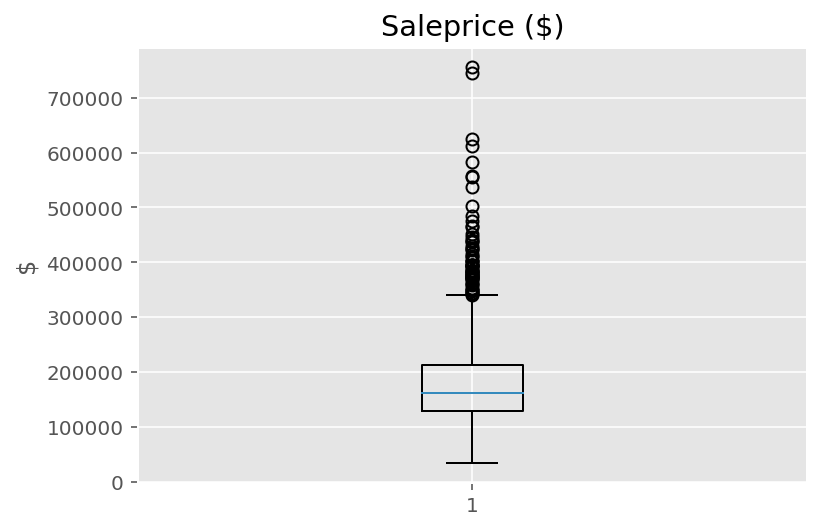

In [491]:
plt.boxplot(house.saleprice)
plt.title('Saleprice ($)')
plt.ylabel('$')
plt.show()

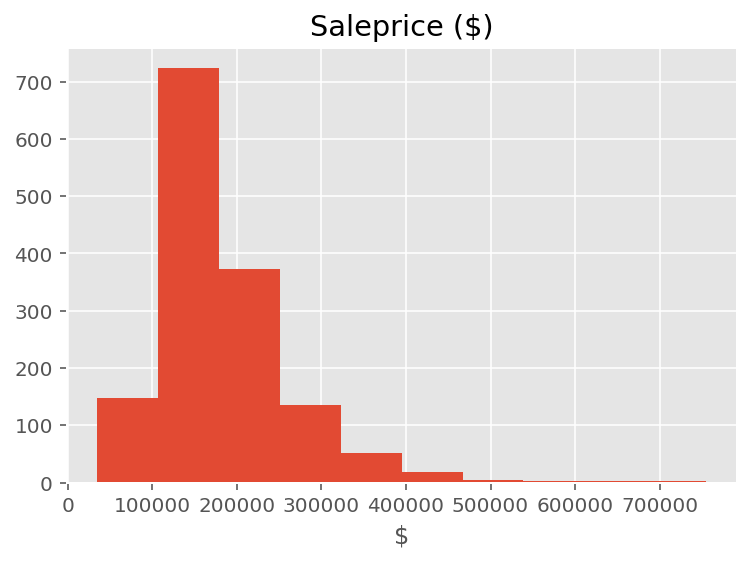

In [493]:
plt.hist(fixed_df.saleprice)
plt.title('Saleprice ($)')
plt.xlabel('$')
plt.show()

Looking at boxplot and histogram of target variable it is clear a tail of outliers is present. To improve accuracy of model, I will restrict saleprices to below $400000. The outliers still present are much more closely bunched together and not as pronounced as the those that were removed

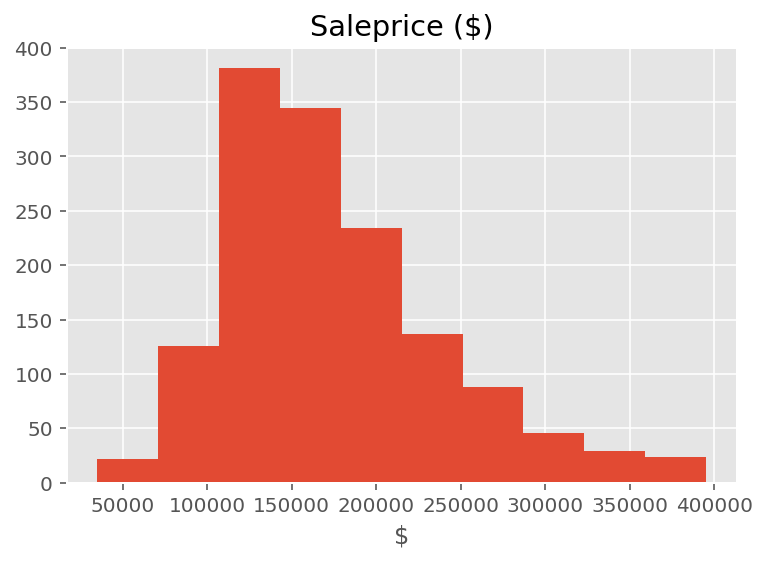

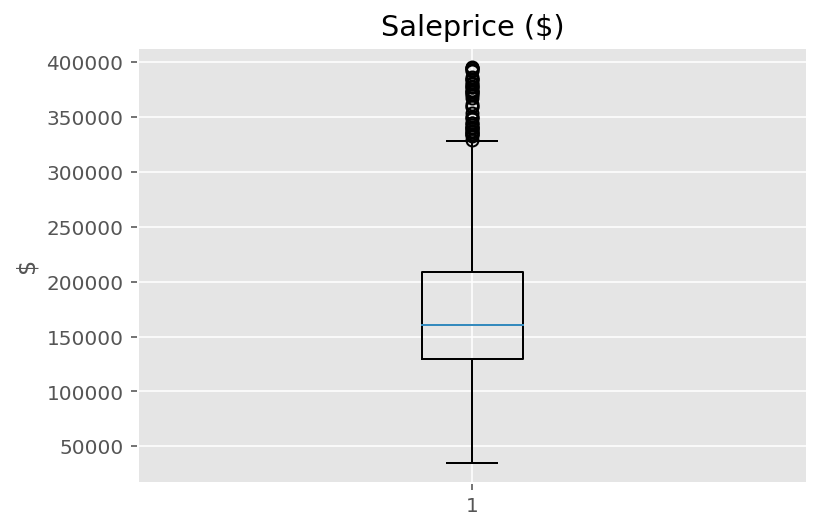

In [7]:
fixed_df_n=fixed_df[fixed_df.saleprice<400000]
plt.hist(fixed_df_n.saleprice)
plt.title('Saleprice ($)')
plt.xlabel('$')
plt.show()
plt.boxplot(fixed_df_n.saleprice)
plt.title('Saleprice ($)')
plt.ylabel('$')
plt.show()

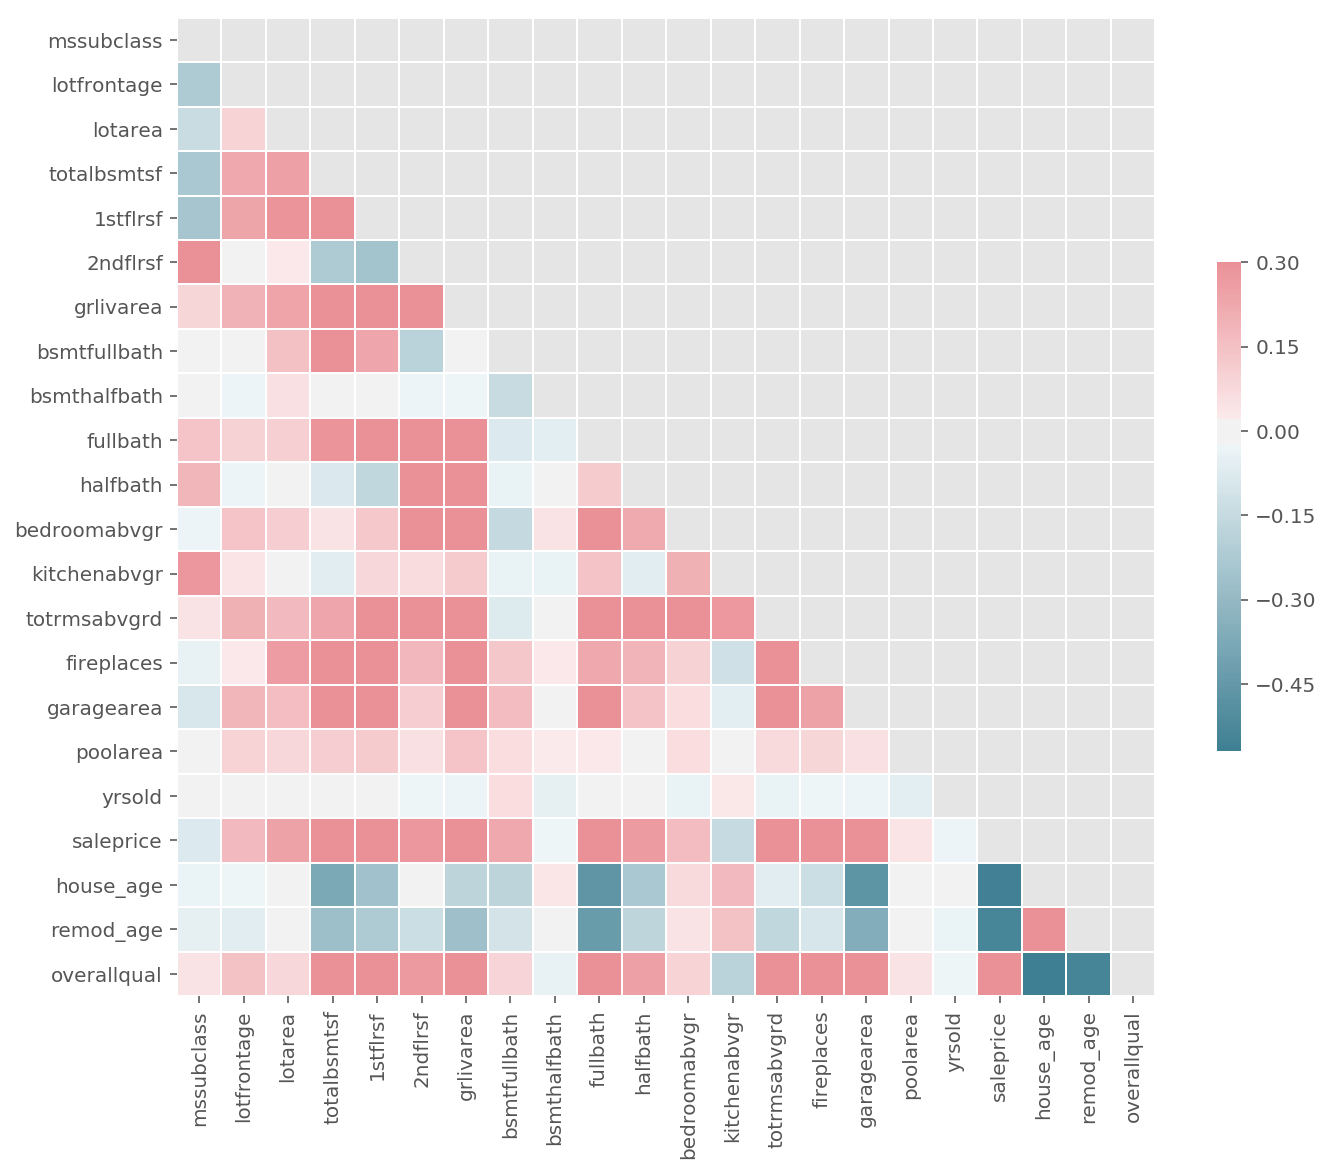

In [495]:
corr=fixed_df_n.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))


cmap = sns.diverging_palette(220, 10, as_cmap=True)


sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

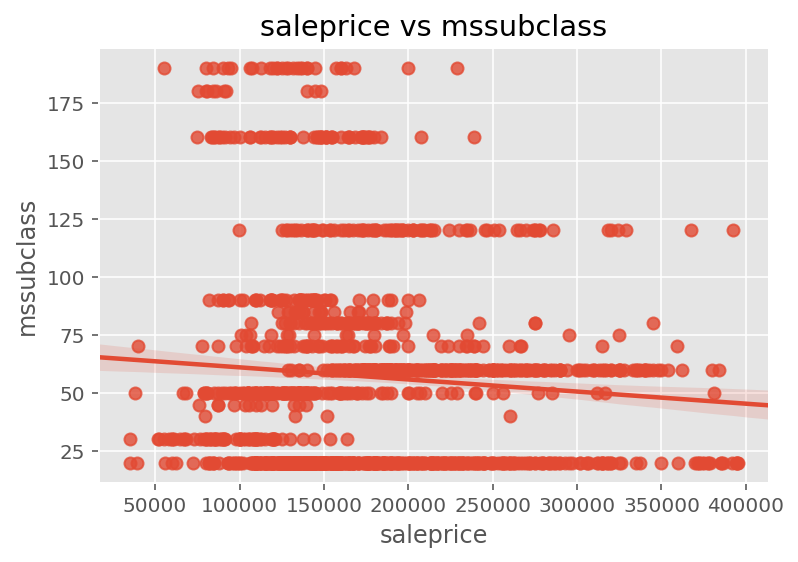

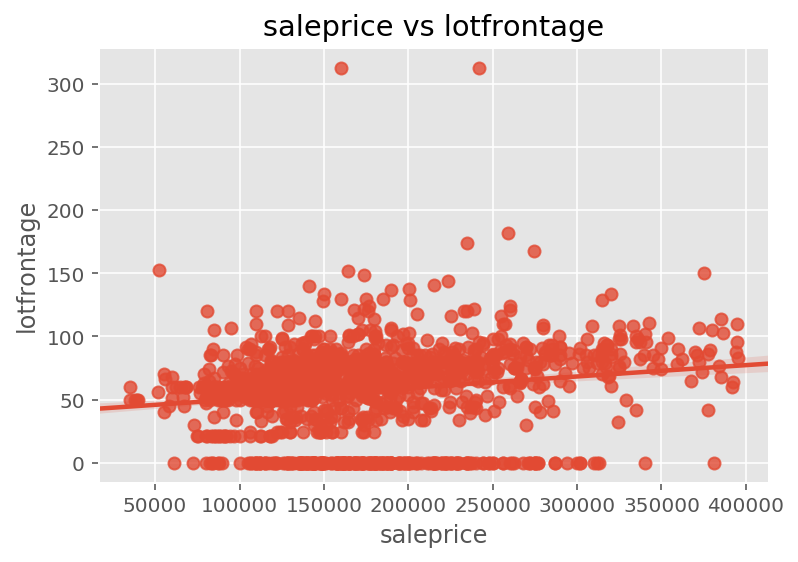

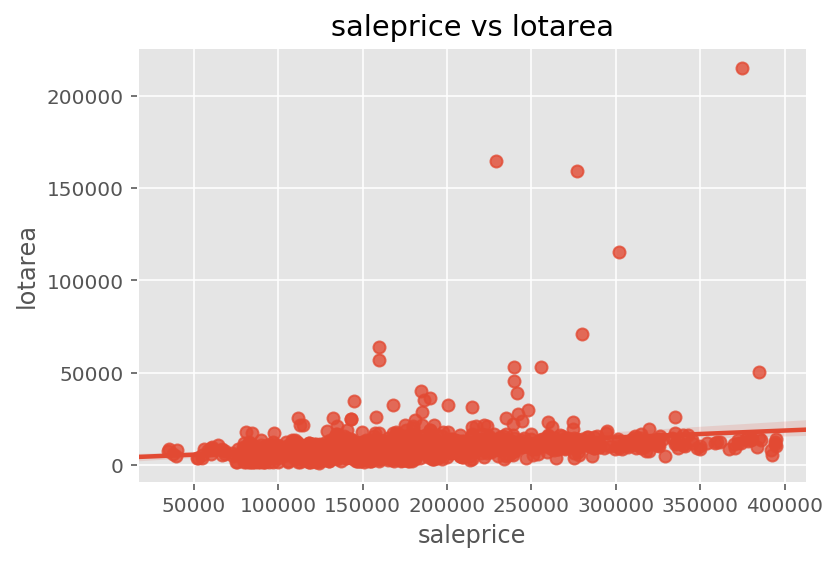

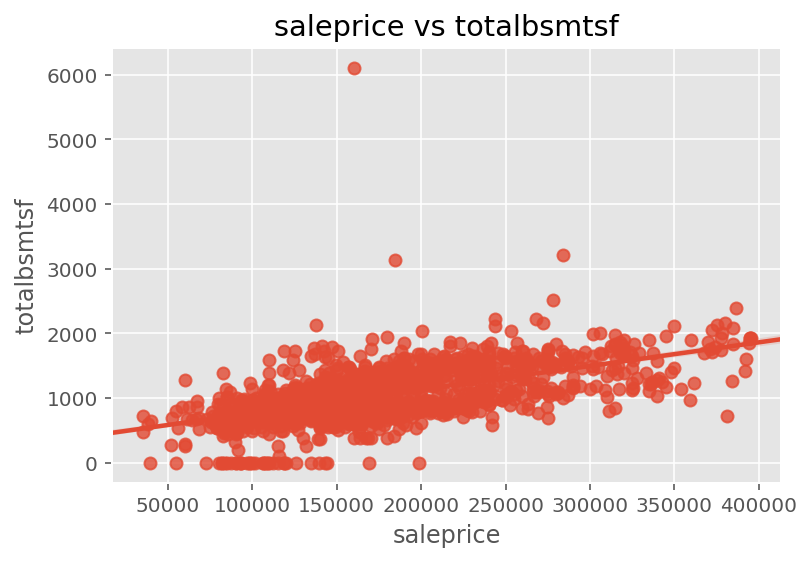

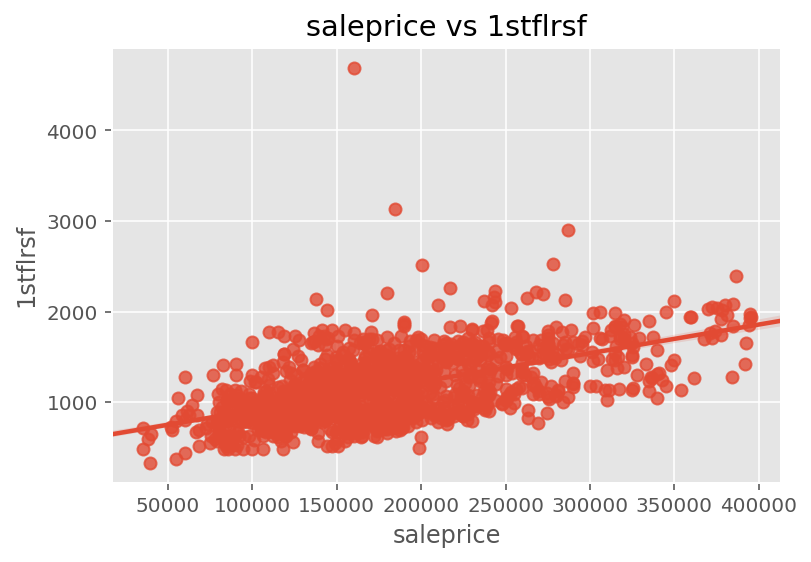

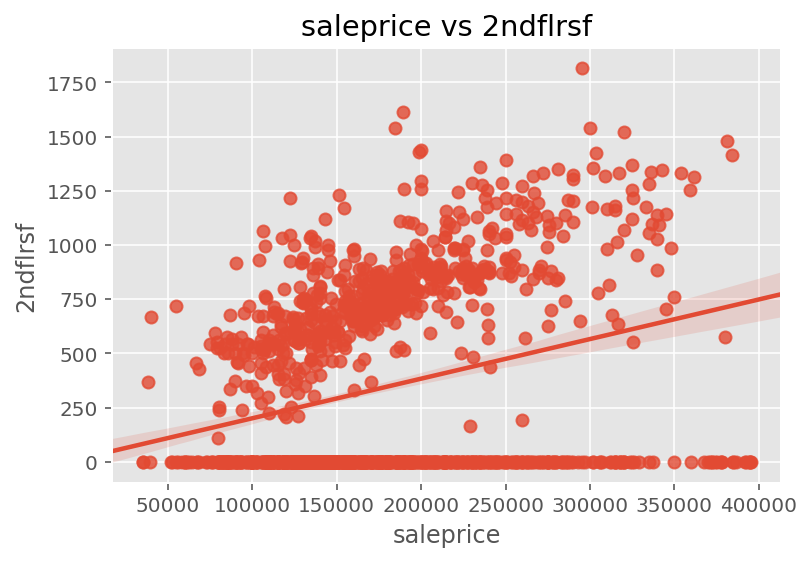

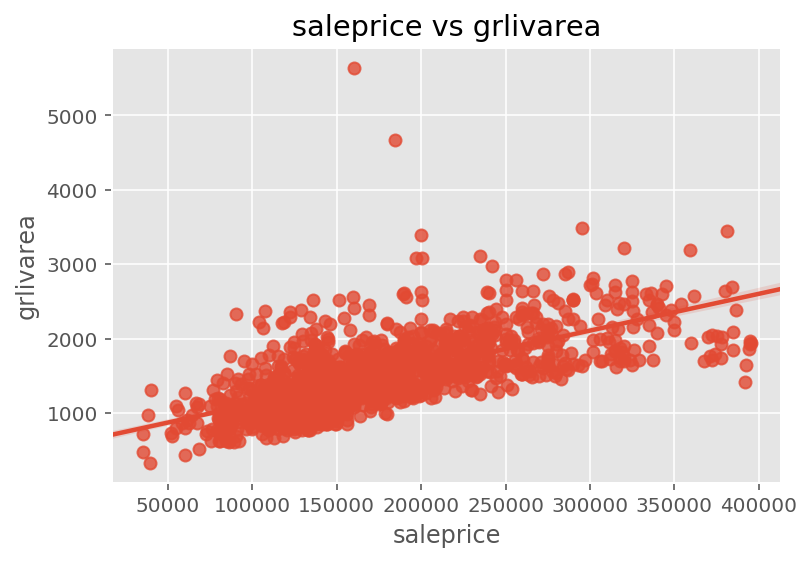

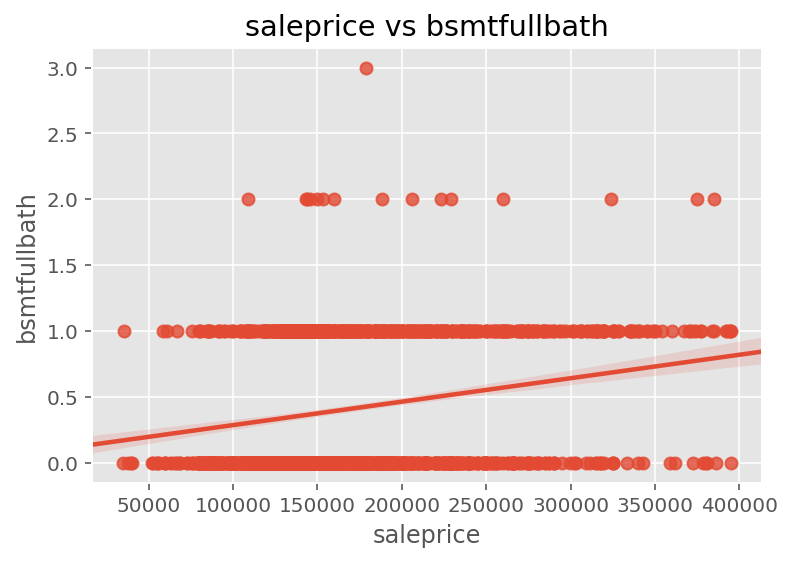

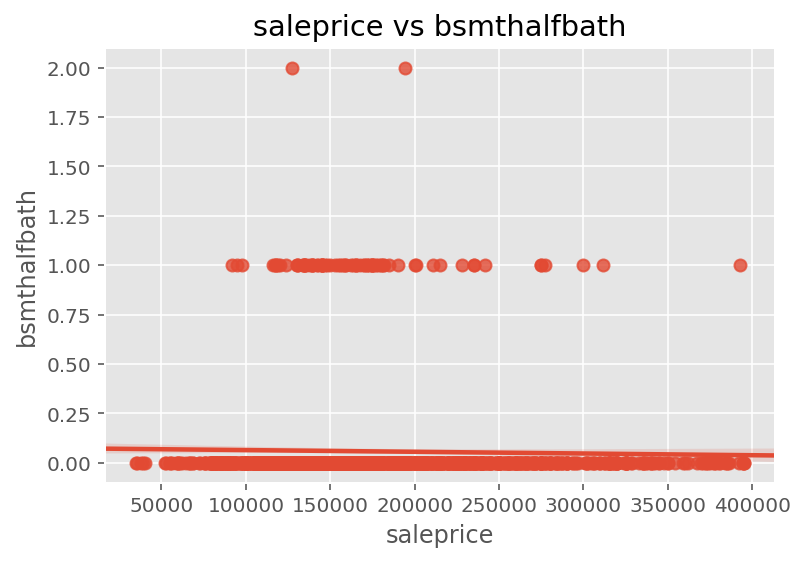

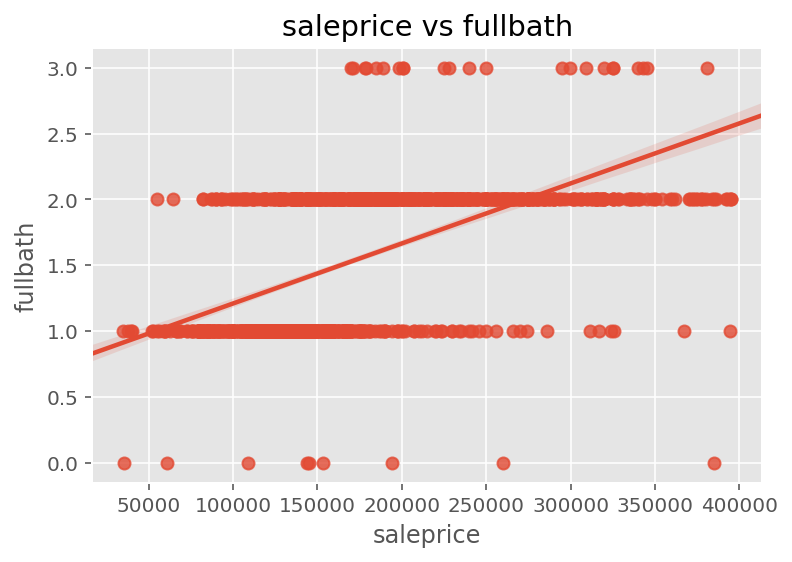

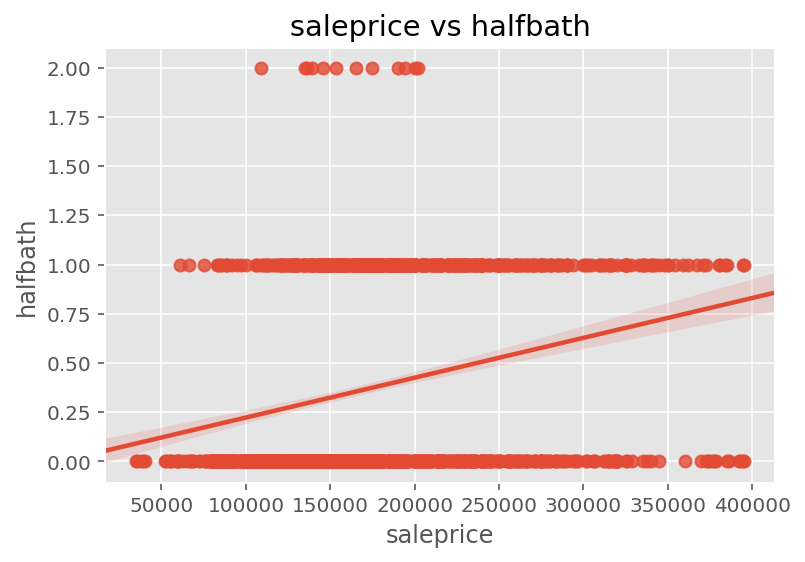

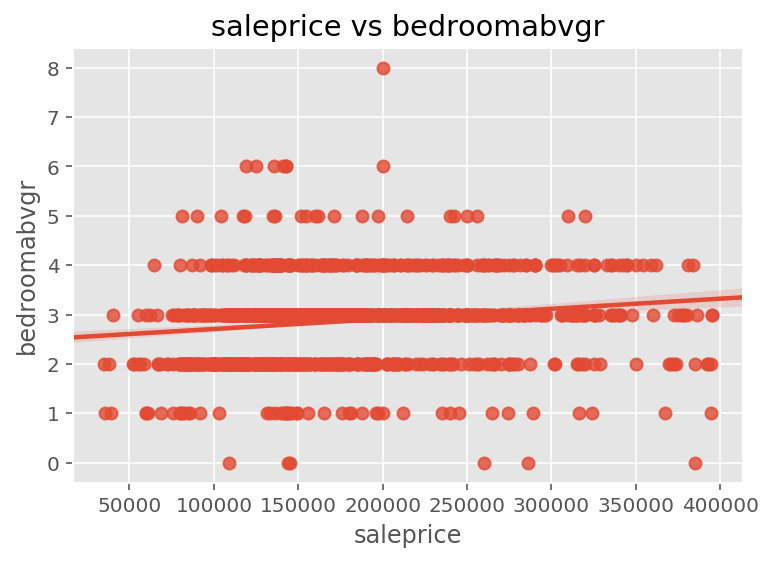

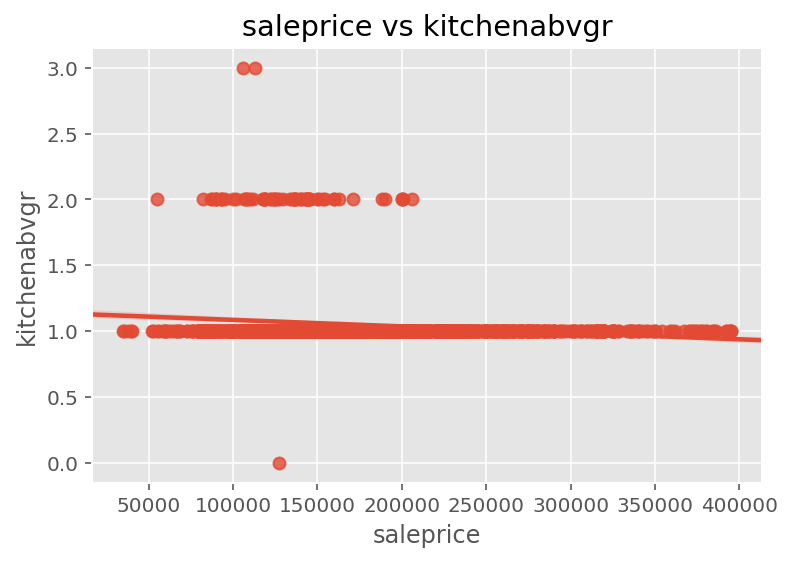

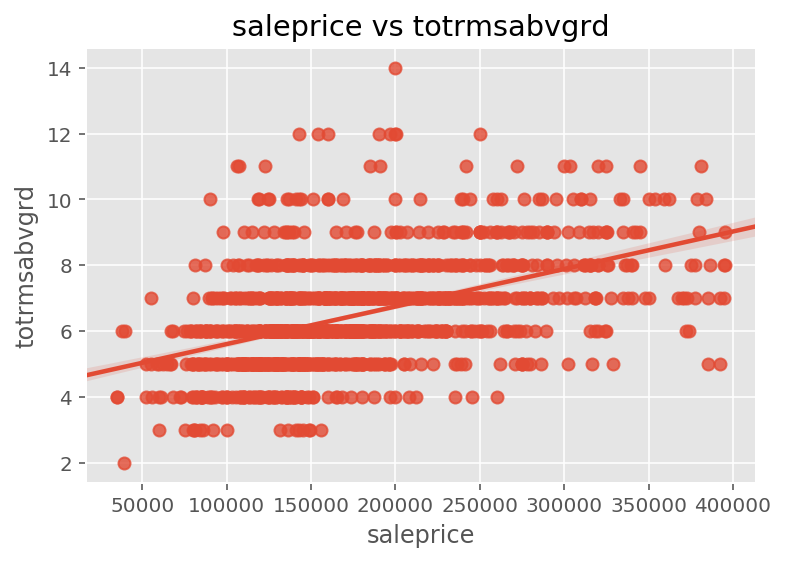

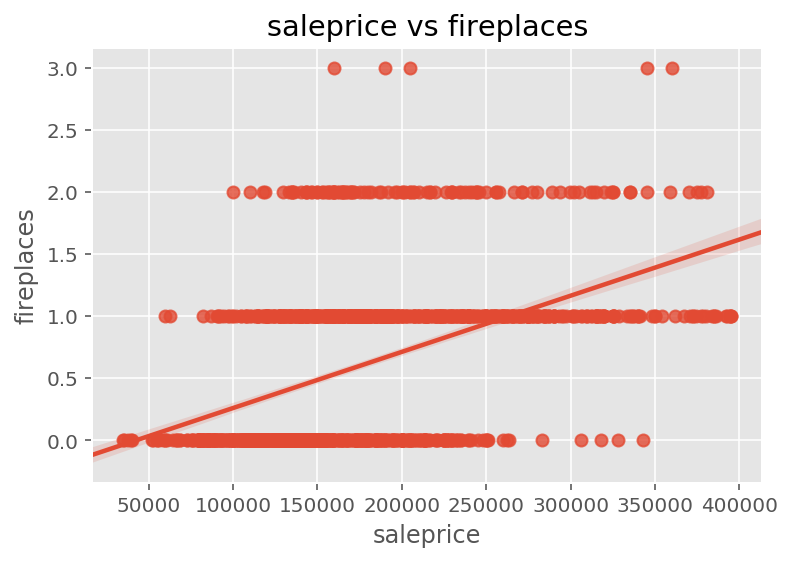

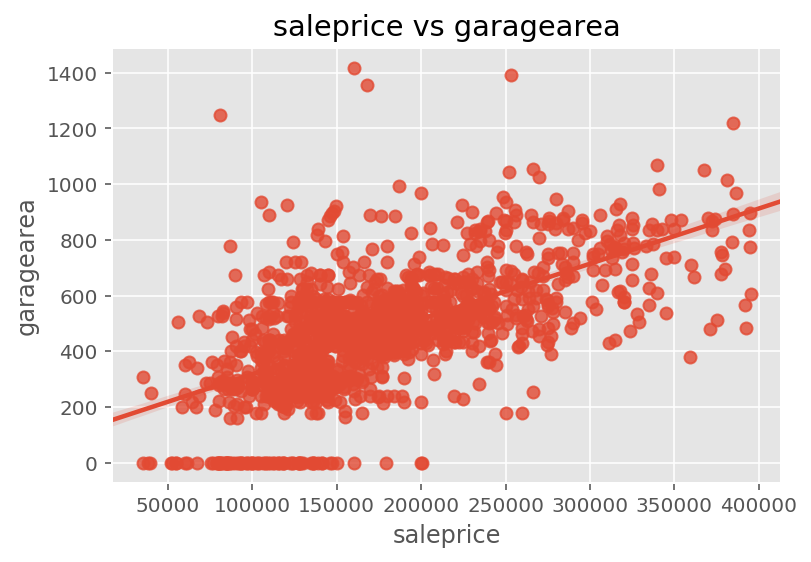

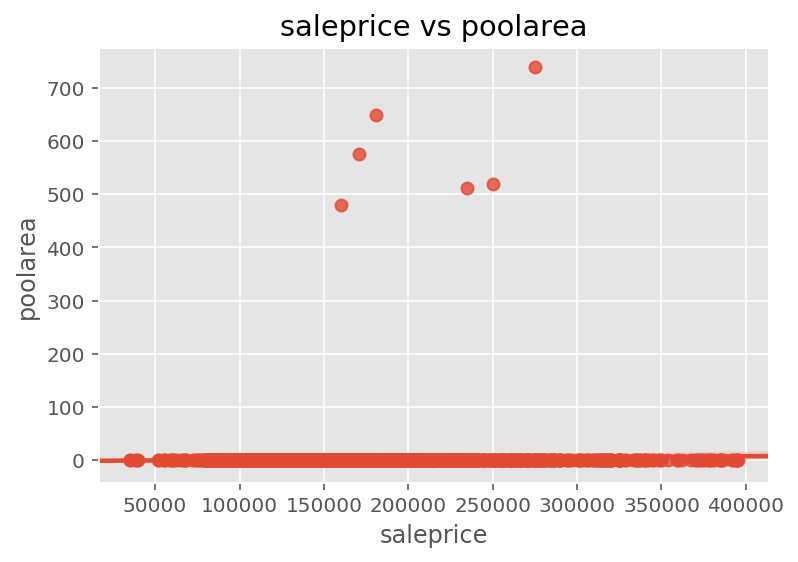

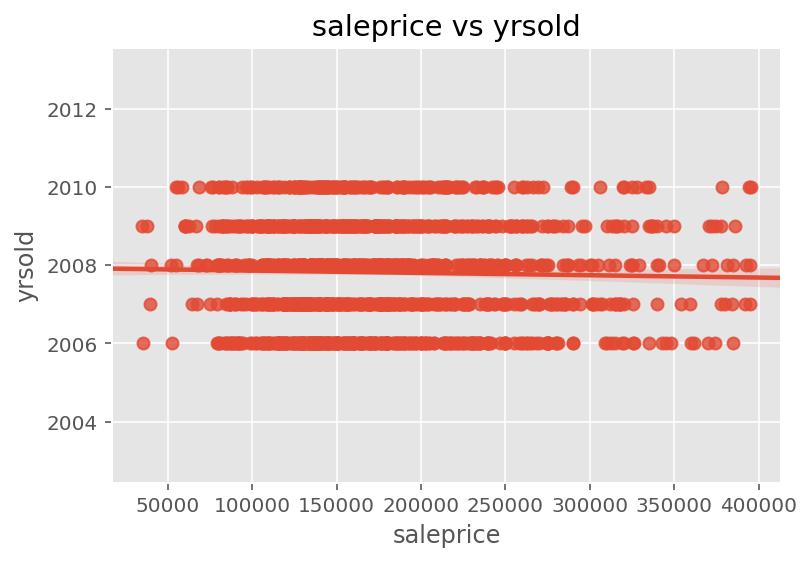

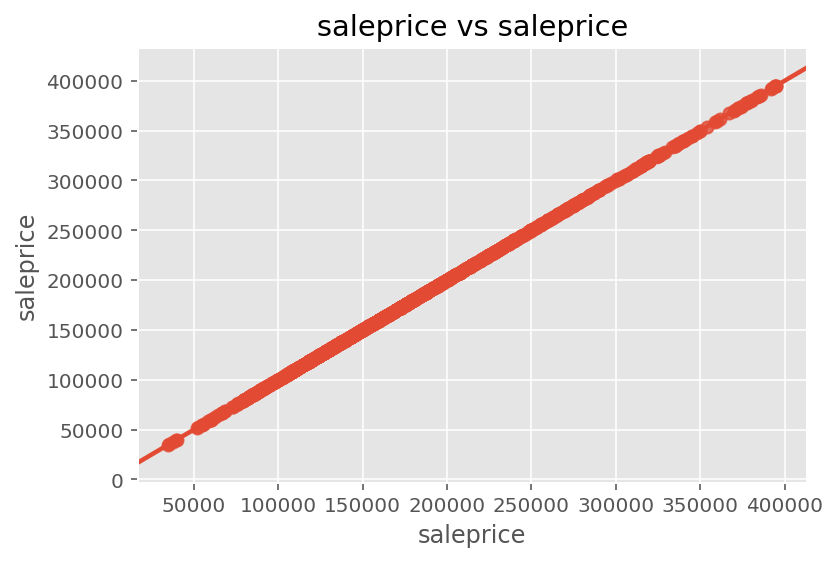

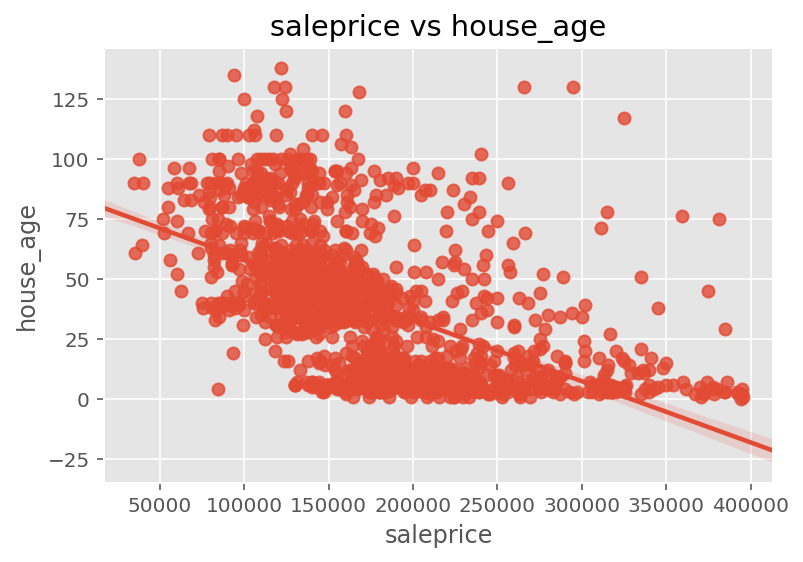

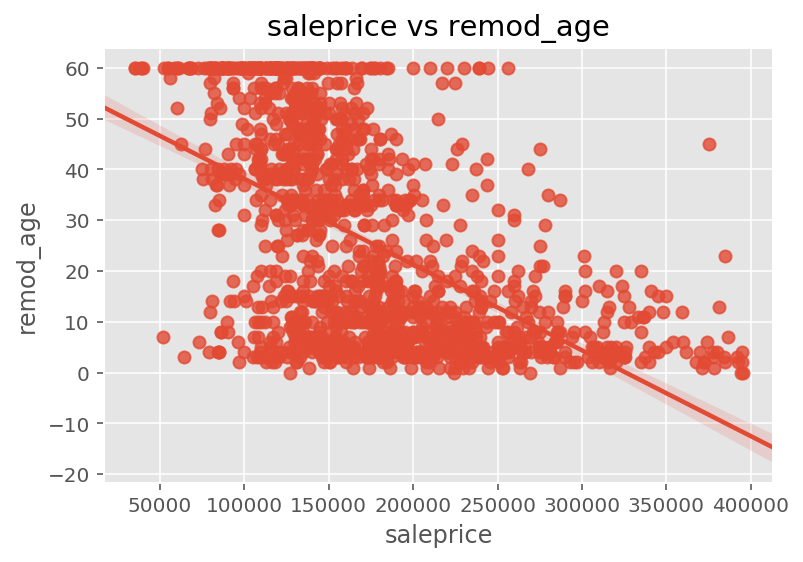

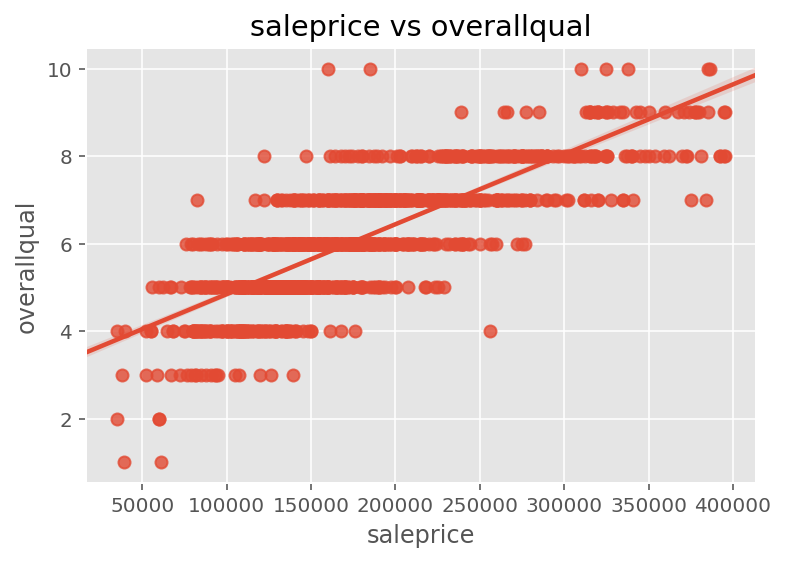

In [496]:
for i in fixed_df_n.columns:
    if fixed_df_n[i].dtypes!='O':
        sns.regplot(x="saleprice", y=i,data=fixed_df_n)
        plt.xlabel('saleprice')
        plt.ylabel(i)
        plt.title('saleprice vs ' + i)
        plt.show()

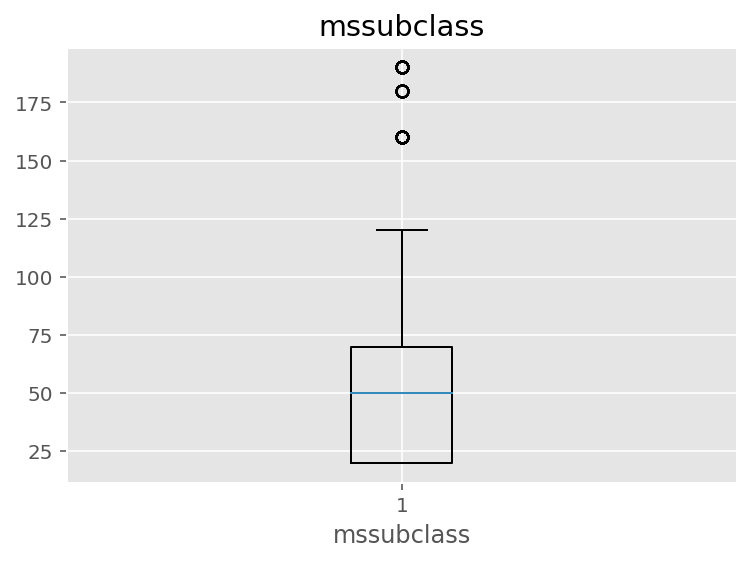

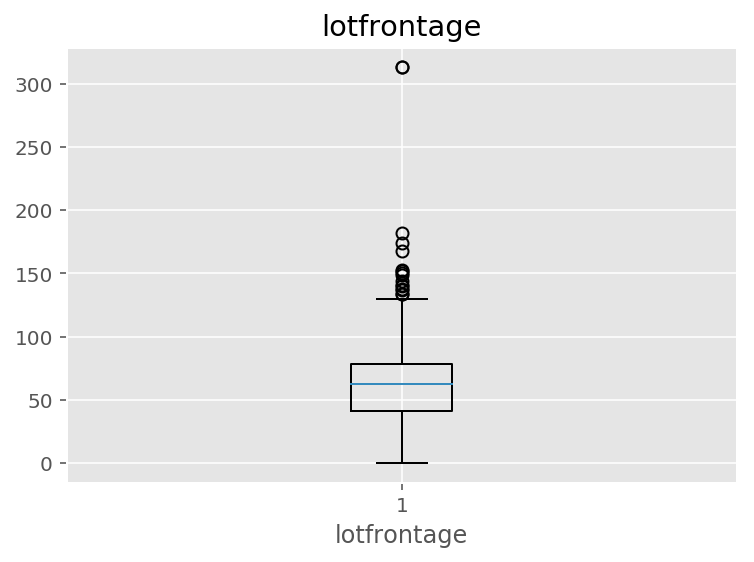

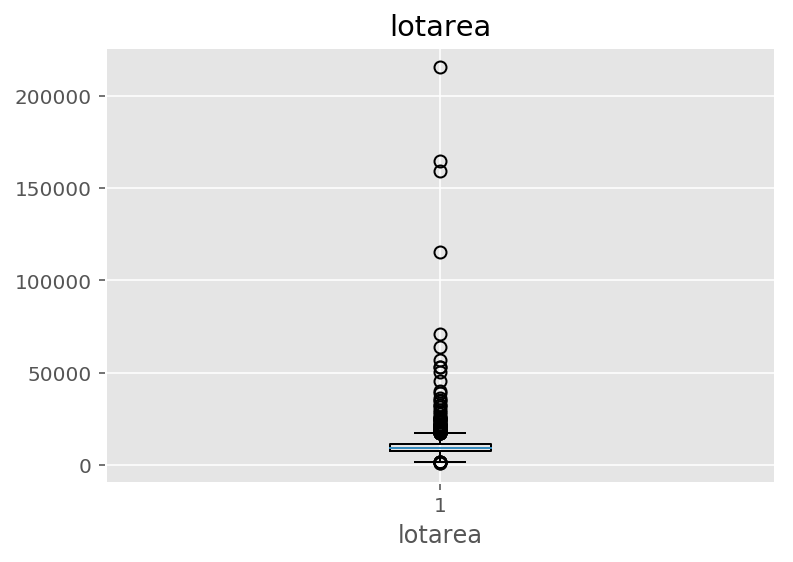

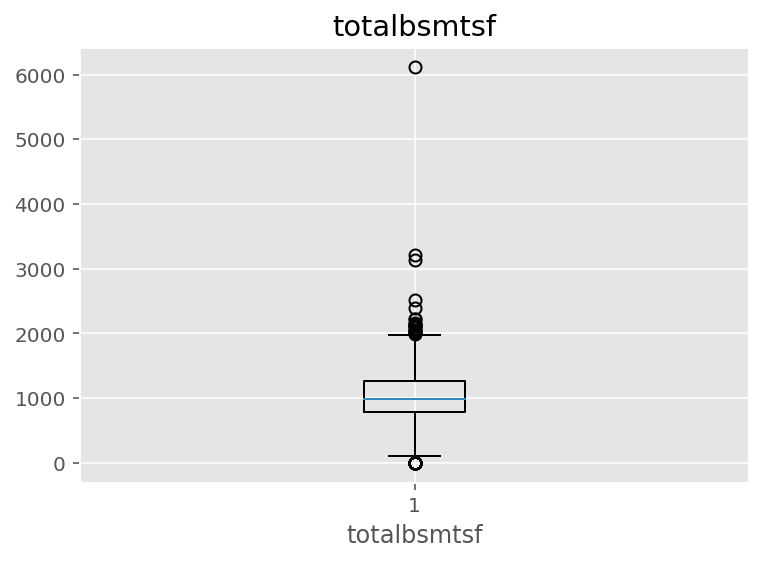

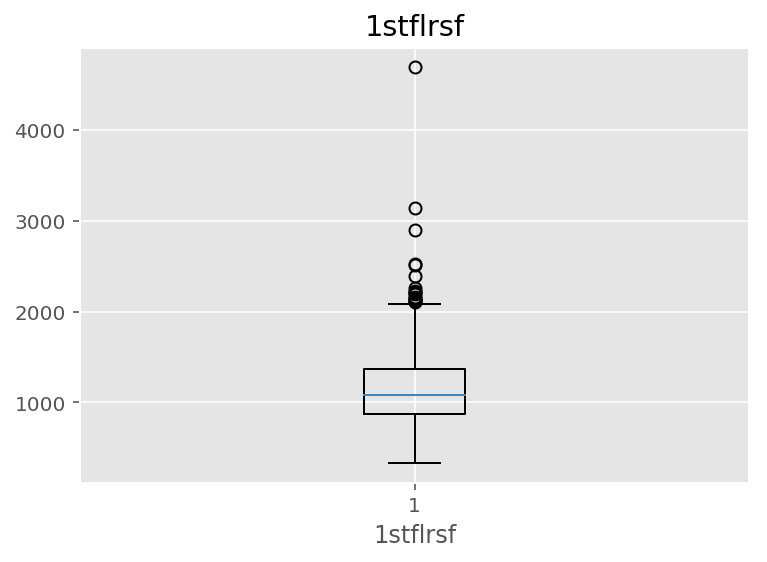

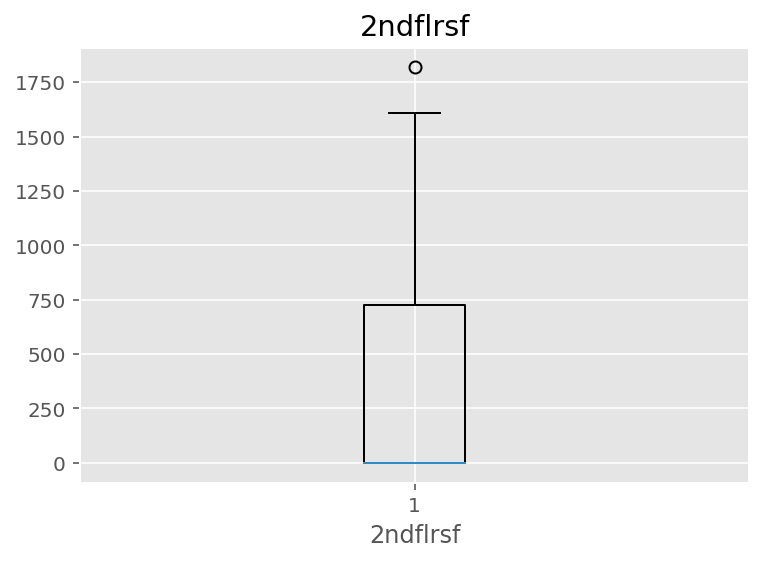

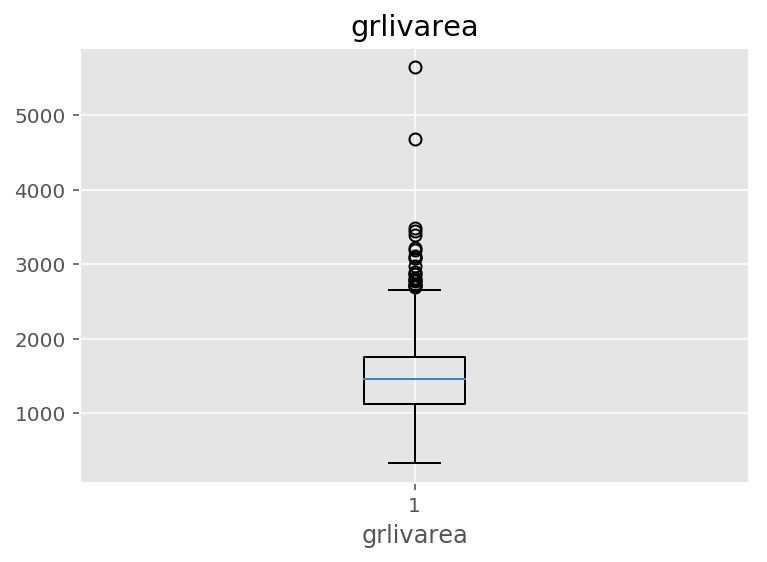

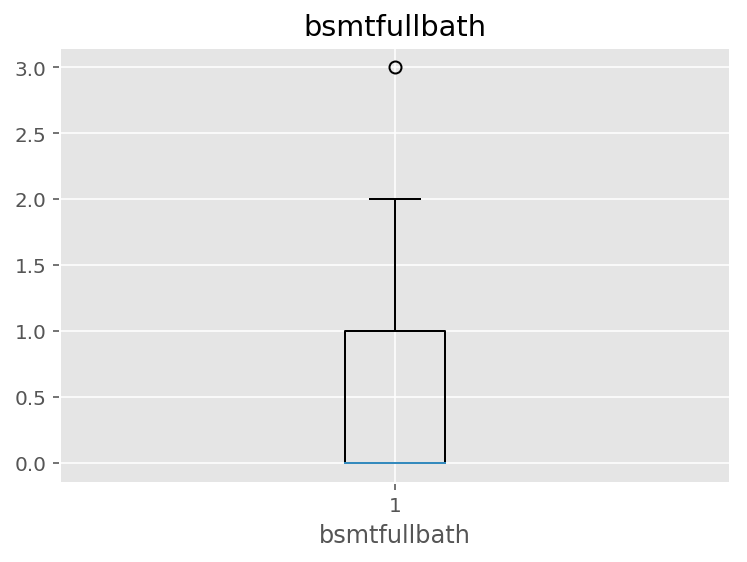

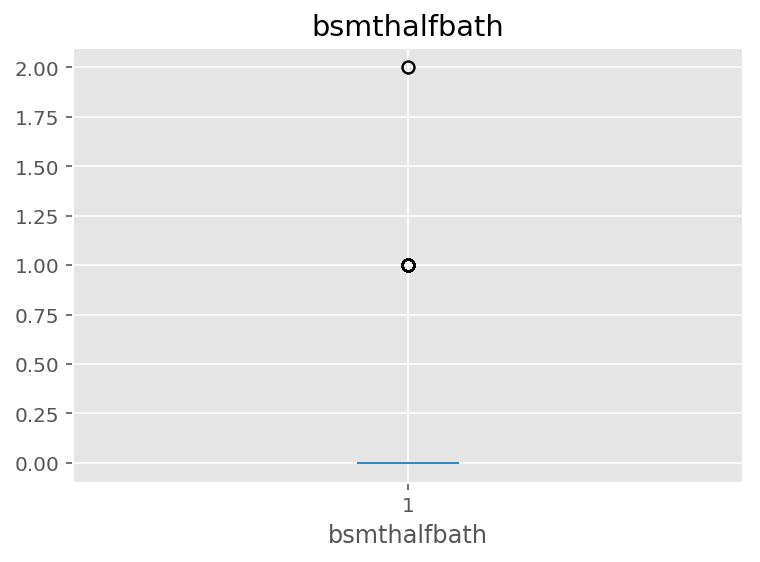

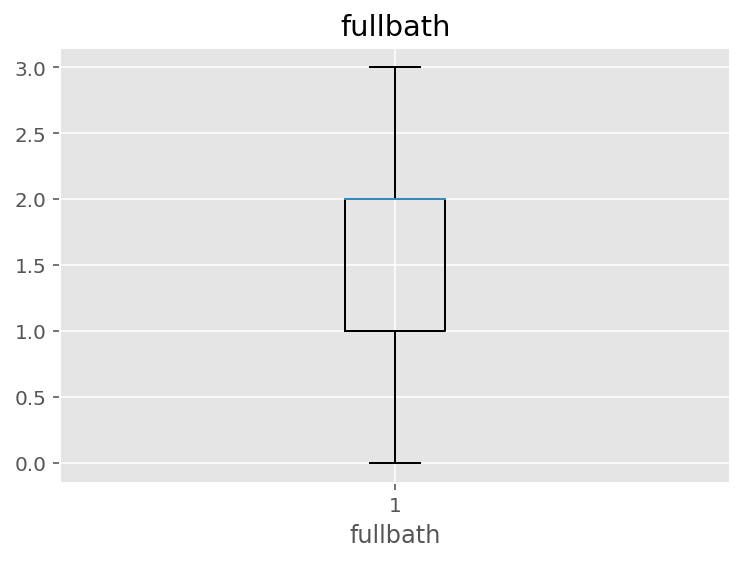

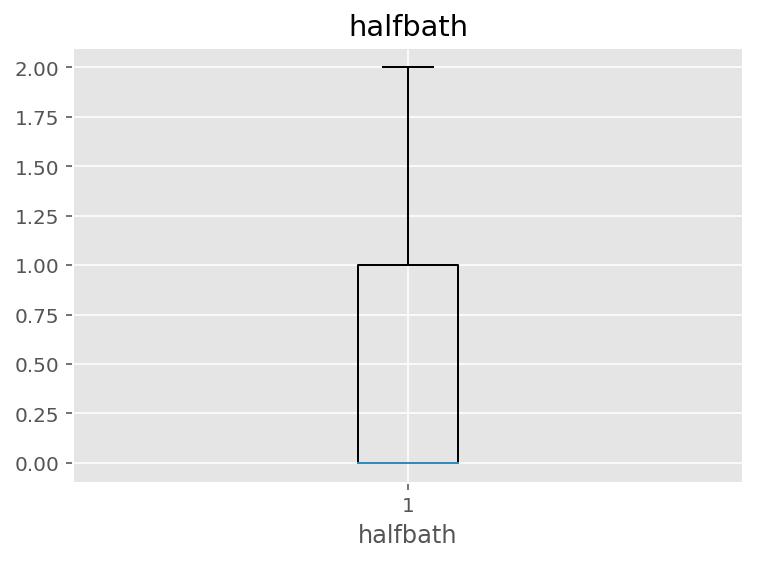

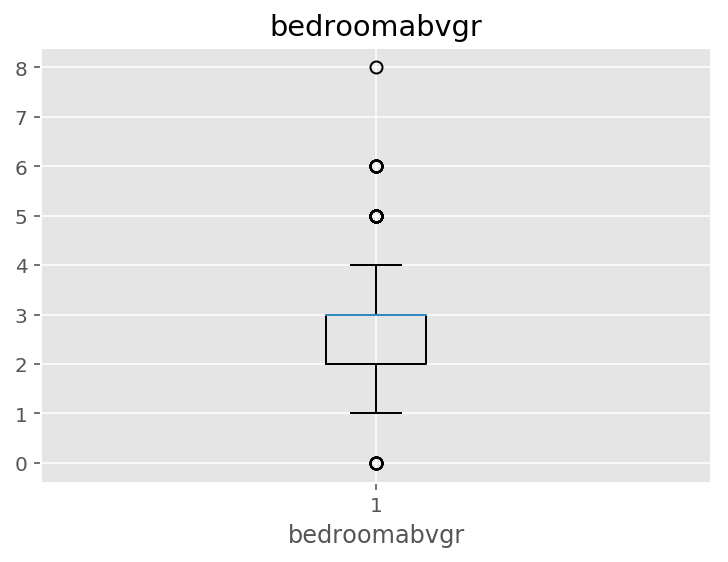

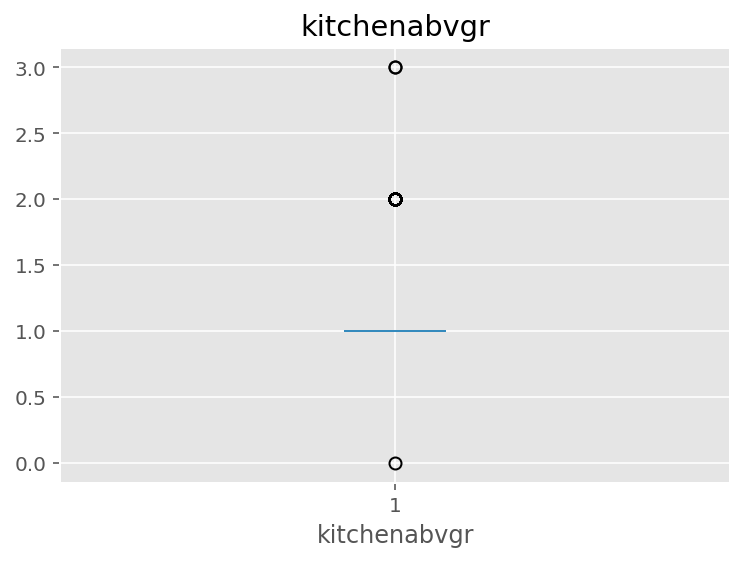

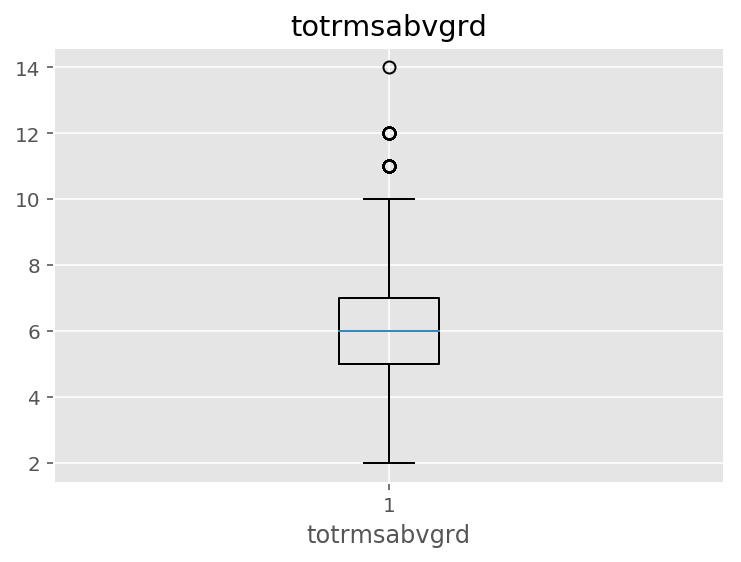

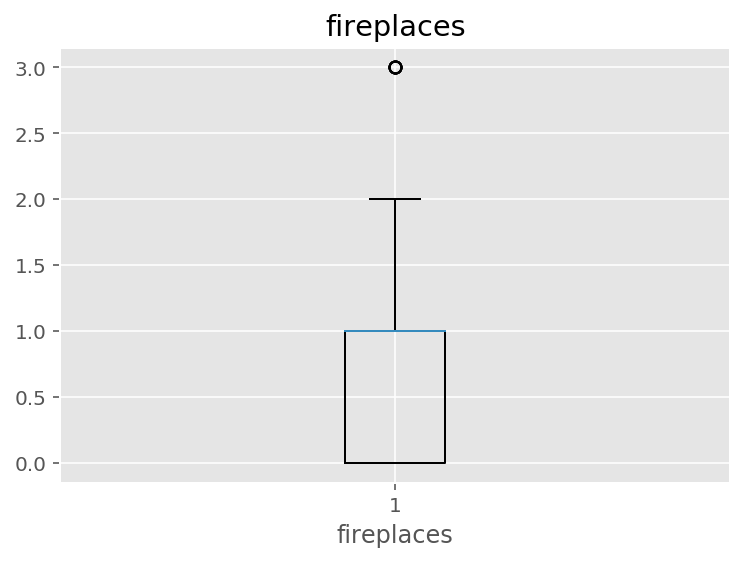

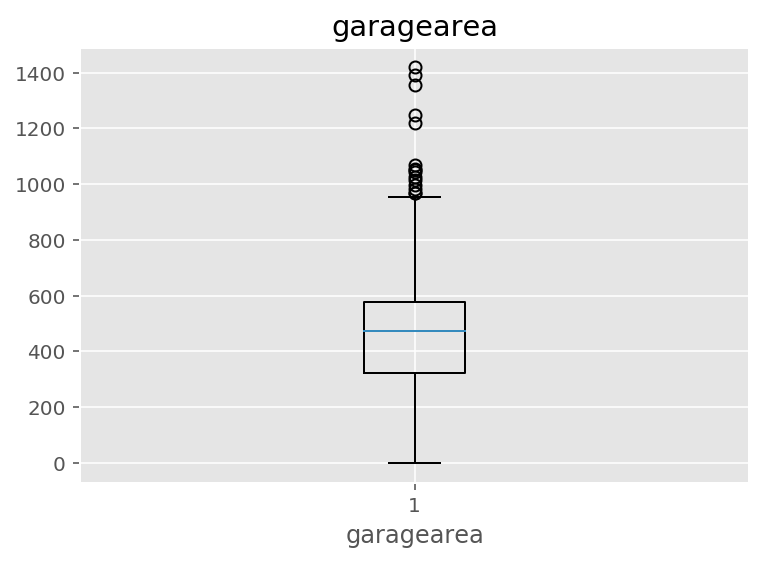

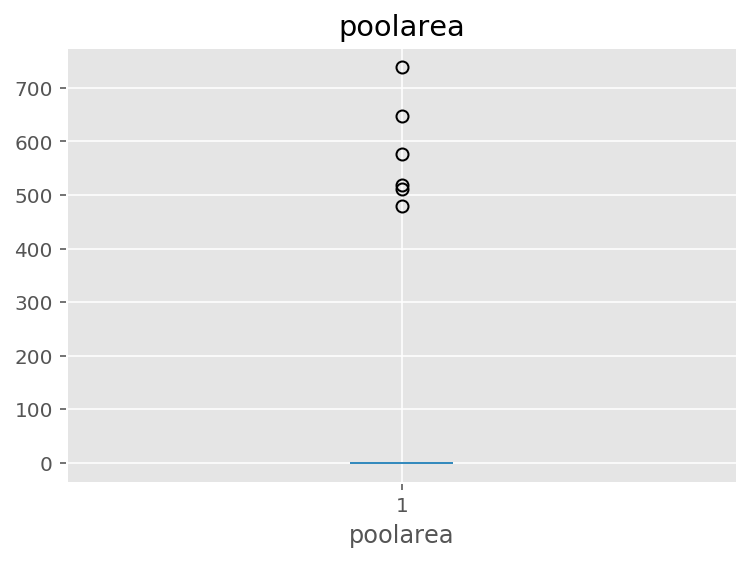

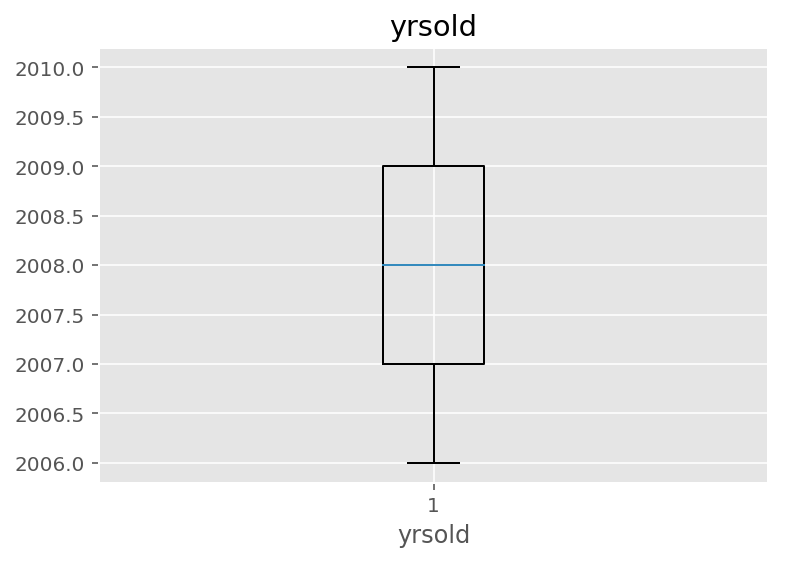

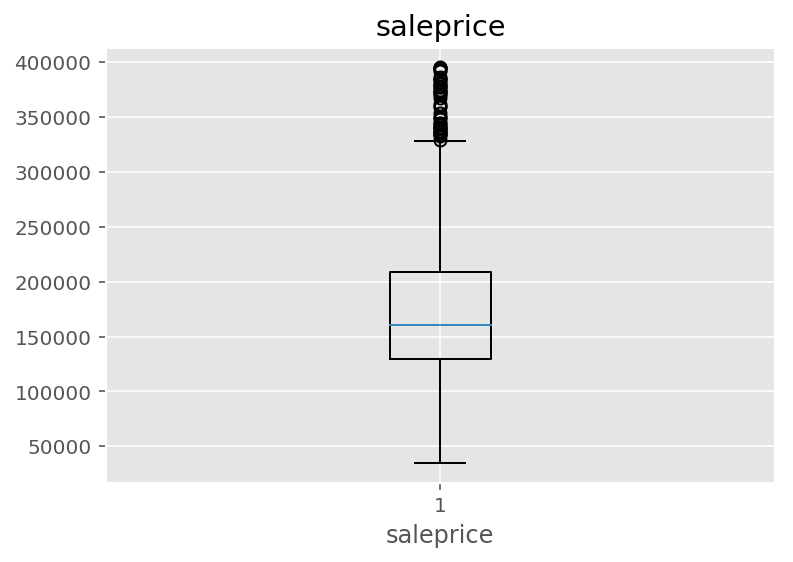

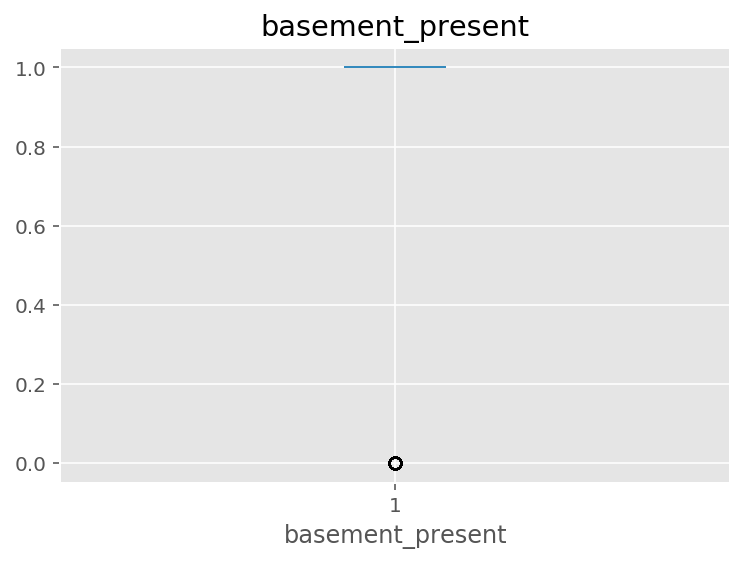

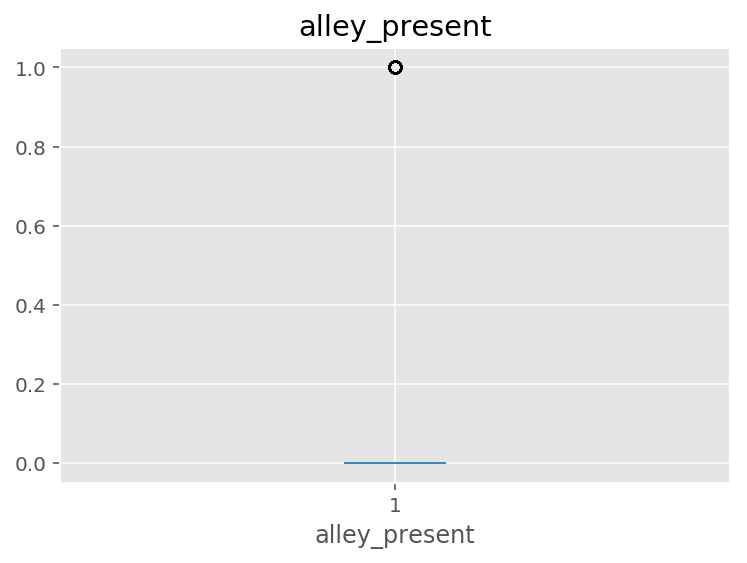

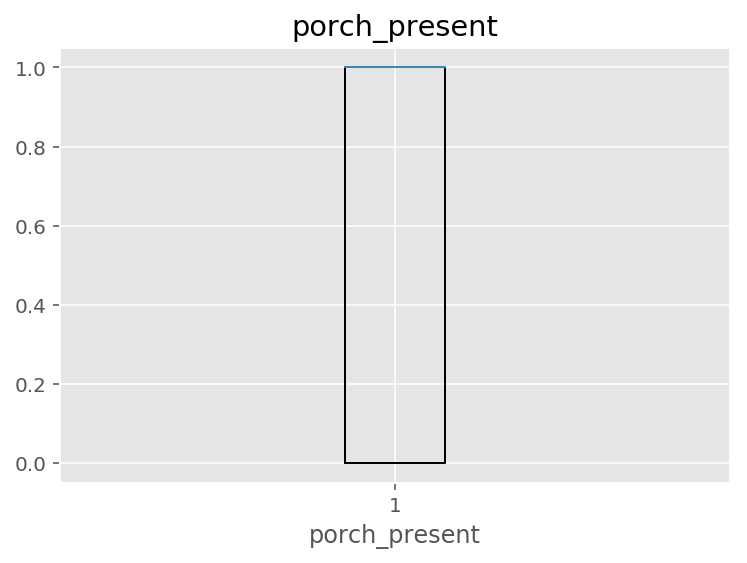

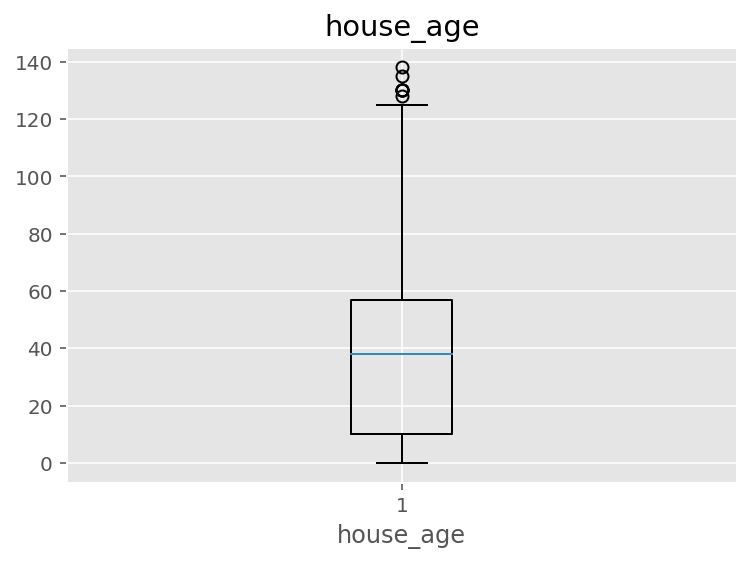

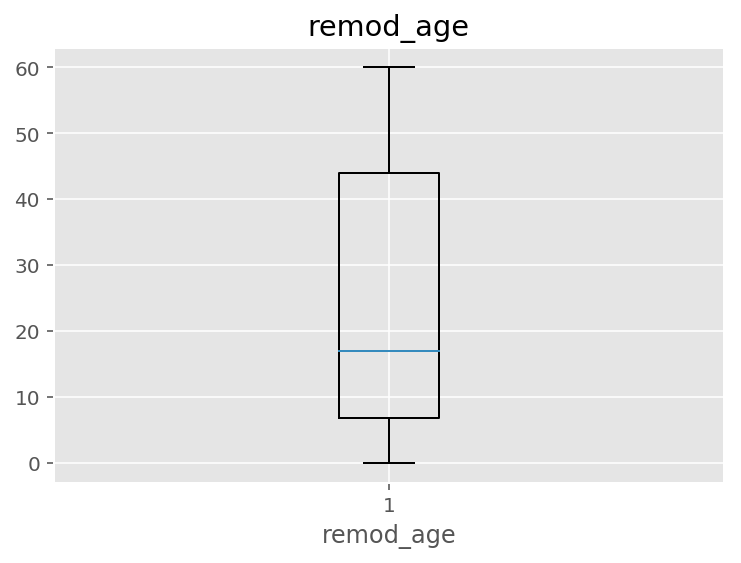

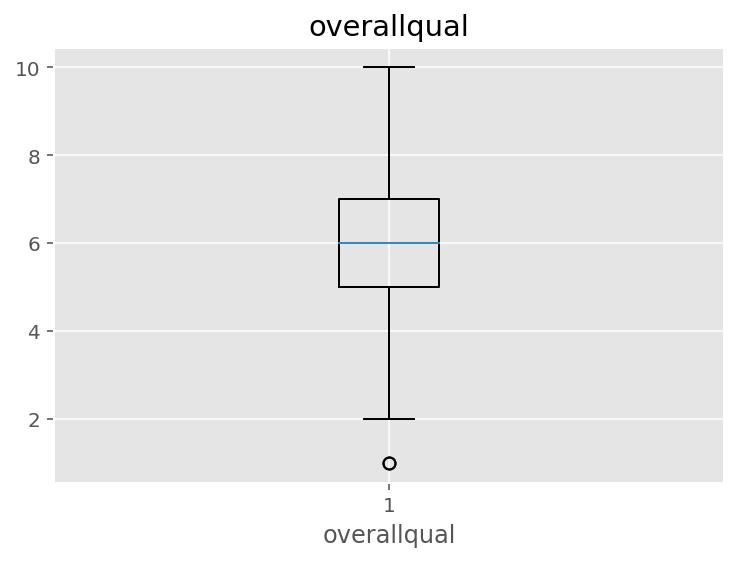

In [80]:
for i in fixed_df_n.columns:
    if fixed_df_n[i].dtypes!='O':
        plt.boxplot(fixed_df_n[i])
        plt.xlabel(i)
        plt.title( i)
        plt.show()

I tried several combinations of predictors based on the information in the charts above, but the highest R2 was returned on both test and training set when all features are used with Lasso penatly applied. Several features have pronounced outliers, well away from the rest of the data, so to make the model more accurate these were removed.

Also, 2ndflrsf has many na's due to properties with no second floors and by changing them to 0's has heavily influenced the regression line. I will drop this feature as it is explained by grlivarea anyway.

In [ ]:
mssubclass 2ndflrsf drop drop(bsmtfullbath bsmthalfbath) fullbath halfbath
bedroomabvgr kitchenabvgr totrmsabvgrd fireplaces


In [8]:
fixed_df_n=fixed_df_n[(fixed_df_n.lotfrontage<300) & (fixed_df_n.lotarea<50000) & (fixed_df_n.totalbsmtsf<6000) & (fixed_df_n.grlivarea<5000)]
fixed_df_n=fixed_df_n.drop('2ndflrsf',axis=1)

In [45]:
#Dummify categorical features
predict=pd.get_dummies(fixed_df_n,drop_first=True)
predict=pd.get_dummies(predict,columns=['mssubclass','fullbath',
                                          'halfbath', 'bedroomabvgr',
                                          'kitchenabvgr','totrmsabvgrd',
                                          'fireplaces','bsmtfullbath',
                                        'bsmthalfbath'],drop_first=True)

In [46]:
#Create test and training sets, and remove yrsold from them
X_train=predict[predict.yrsold<2010]
X_test=predict[predict.yrsold==2010]
y_train=X_train.pop('saleprice')
y_test=X_test.pop('saleprice')
X_train=X_train.drop('yrsold',axis=1);
X_test=X_test.drop('yrsold',axis=1);

In [47]:
scaler = StandardScaler()


X_std_train = scaler.fit_transform(X_train)
X_std_test=scaler.transform(X_test)
X_tra=pd.DataFrame(X_std_train,columns=X_train.columns)
X_te=pd.DataFrame(X_std_test,columns=X_test.columns)

In [48]:
#Use elastic net to see what correction is best used
en=ElasticNetCV(n_alphas=100,l1_ratio=[i/100 for i in range(1,101)],max_iter=10000,cv=5)
en.fit(X_tra,y_train);

In [49]:
#Lasso- this will then remove effects from weaker predictors, allowing me to keep all features in model
en.l1_ratio_

1.0

In [50]:
print('Train R2: ' +str(en.score(X_tra,y_train)))
print('Test R2: ' +str(en.score(X_te,y_test)))

Train R2: 0.8925521123921744
Test R2: 0.8888402198566738


In [51]:
from sklearn.model_selection import GridSearchCV

In [52]:
#Use gridsearch to find best model
en_params = {
    'n_alphas': [1,10,50,80,100],
    'l1_ratio': [.1, .5, .7, .9, .95, .99, 1],
    'fit_intercept': [True,False],
    'random_state':[1,100,1000],
    'max_iter':[1,10,100,1000,10000]}
model=ElasticNetCV()
en_gridsearch = GridSearchCV(model,
                              en_params,
                              n_jobs=-1, 
                              cv=5, 
                              verbose=1, 
                              return_train_score=True)

en_gridsearch.fit(X_tra, y_train)

Fitting 5 folds for each of 1050 candidates, totalling 5250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 849 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 1549 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 2449 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3549 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4849 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 5243 out of 5250 | elapsed:  3.1min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 5250 out of 5250 | elapsed:  3.1min finished
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNetCV(alphas=None, copy_X=True, cv='warn',
                                    eps=0.001, fit_intercept=True, l1_ratio=0.5,
                                    max_iter=1000, n_alphas=100, n_jobs=None,
                                    normalize=False, positive=False,
                                    precompute='auto', random_state=None,
                                    selection='cyclic', tol=0.0001, verbose=0),
             iid='warn', n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
                         'max_iter': [1, 10, 100, 1000, 10000],
                         'n_alphas': [1, 10, 50, 80, 100],
                         'random_state': [1, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

In [53]:
en_gridsearch.best_params_

{'fit_intercept': True,
 'l1_ratio': 1,
 'max_iter': 100,
 'n_alphas': 80,
 'random_state': 1}

In [54]:
best_en = en_gridsearch.best_estimator_
print('Train R2: ' +str(best_en.score(X_tra, y_train)))
print('Test R2: ' + str(best_en.score(X_te, y_test)))

Train R2: 0.8946350846205645
Test R2: 0.8895268241883107


Best model has an R2 of 0.89 on the test set, will use this going forward

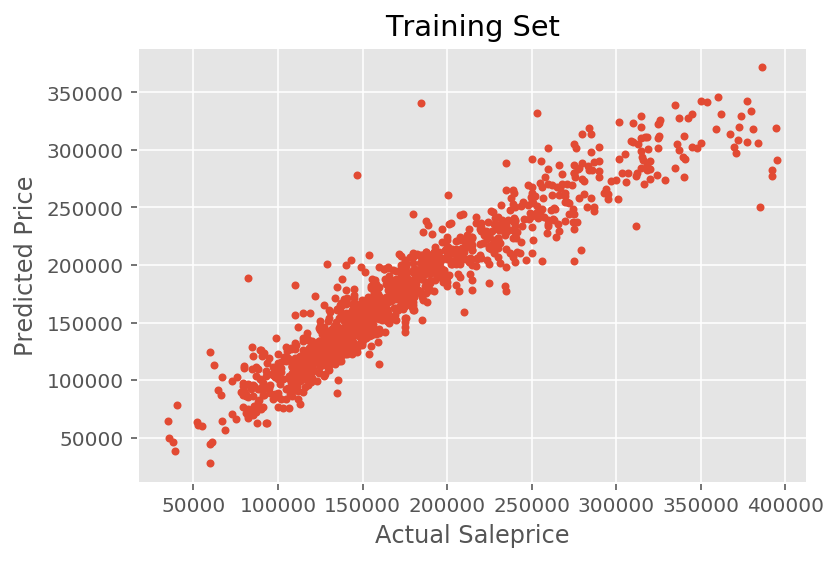

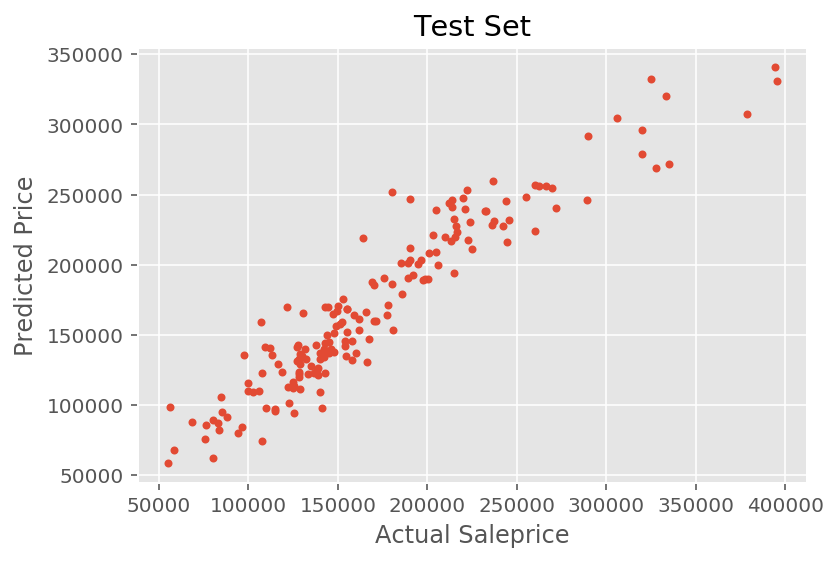

In [55]:
plt.plot(y_train,best_en.predict(X_tra),'.')
plt.xlabel('Actual Saleprice')
plt.ylabel('Predicted Price')
plt.title('Training Set')
plt.show()
plt.plot(y_test,best_en.predict(X_te),'.')
plt.xlabel('Actual Saleprice')
plt.ylabel('Predicted Price')
plt.title('Test Set')
plt.show()

Both test and training set appear to be accurately predicting houseprice

In [58]:
#Process to create column of predicted values in original dataset
overall_df=pd.get_dummies(fixed_df,drop_first=True)
overall_df=pd.get_dummies(overall_df,columns=['mssubclass','fullbath',
                                          'halfbath', 'bedroomabvgr',
                                          'kitchenabvgr','totrmsabvgrd',
                                          'fireplaces','bsmtfullbath',
                                        'bsmthalfbath'],drop_first=True)
overall_df=overall_df.drop('2ndflrsf',axis=1)
overall_df=overall_df.drop(['yrsold','saleprice'],axis=1)
overall_std=scaler.transform(overall_df)
overall=pd.DataFrame(overall_std,columns=overall_df.columns)
house['predict']=best_en.predict(overall)

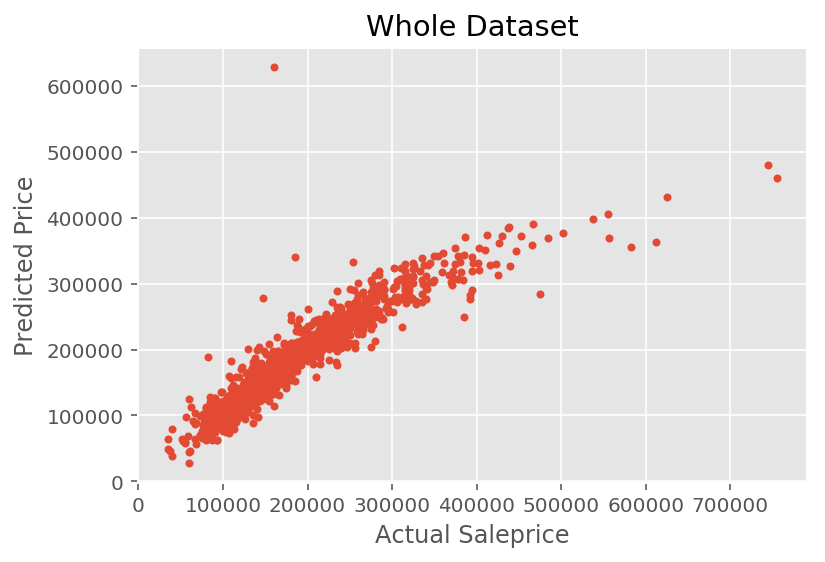

In [59]:
#Check predicted vs actual
plt.plot(house.saleprice,house.predict,'.')
plt.xlabel('Actual Saleprice')
plt.ylabel('Predicted Price')
plt.title('Whole Dataset')
plt.show()

In [60]:
#Check which features have biggest effect
coeffs=pd.DataFrame(list(zip(X_tra.columns,best_en.coef_)),columns=['feature','coef'])
coeffs['abs_effect']=np.abs(coeffs.coef)

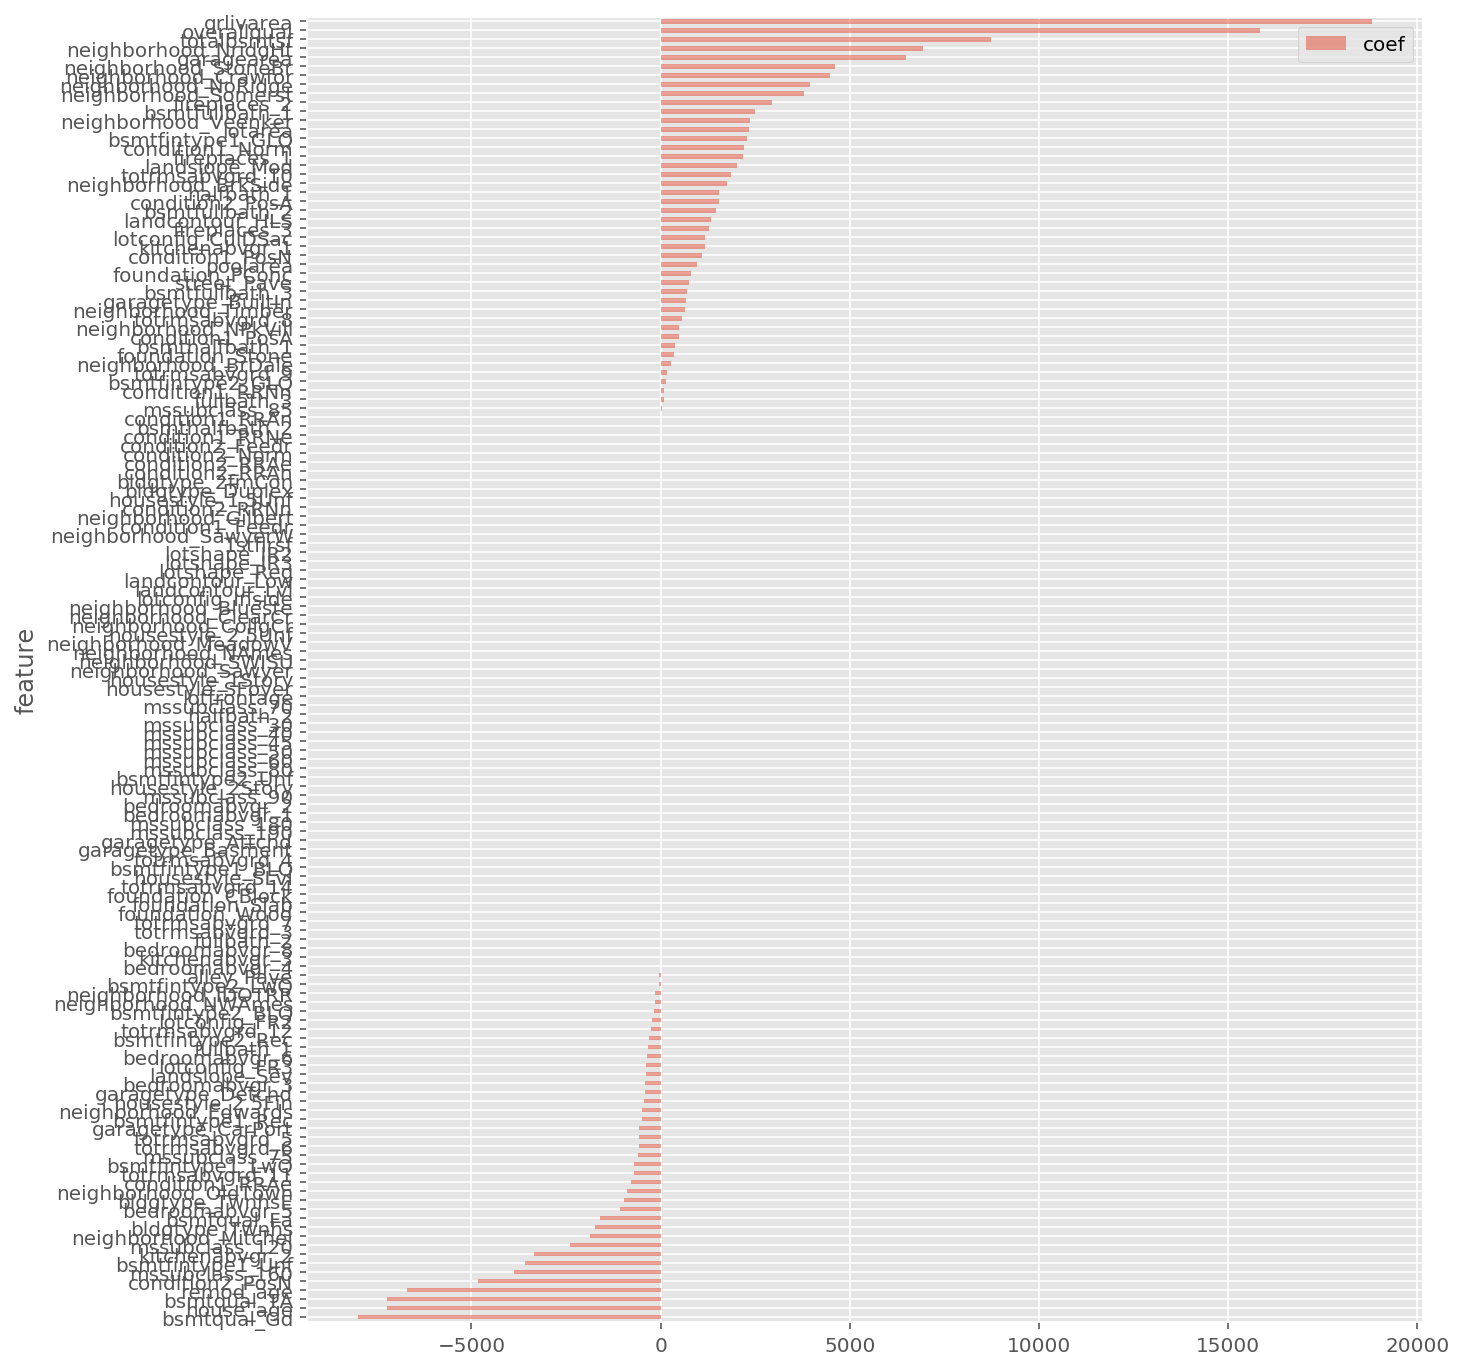

In [61]:
fig, ax =plt.subplots(figsize=(10,12))
coeffs.sort_values(by='coef').plot(kind='barh',x='feature',y='coef',ax=ax,alpha=0.5);

In [62]:
#Table to show the same thing as above
coeffs.sort_values(by='abs_effect',ascending=False)[0:20]

feature          coef    abs_effect
4               grlivarea  18809.319636  18809.319636
9             overallqual  15833.839698  15833.839698
2             totalbsmtsf   8725.693276   8725.693276
80            bsmtqual_Gd  -8002.620922   8002.620922
7               house_age  -7238.289571   7238.289571
81            bsmtqual_TA  -7233.093772   7233.093772
39   neighborhood_NridgHt   6928.752603   6928.752603
8               remod_age  -6716.487702   6716.487702
5              garagearea   6489.446159   6489.446159
59        condition2_PosN  -4822.063091   4822.063091
45   neighborhood_StoneBr   4599.436168   4599.436168
29   neighborhood_Crawfor   4472.577099   4472.577099
38   neighborhood_NoRidge   3956.478630   3956.478630
108        mssubclass_160  -3876.896758   3876.896758
44   neighborhood_Somerst   3798.638045   3798.638045
86       bsmtfintype1_Unf  -3576.870688   3576.870688
124        kitchenabvgr_2  -3352.979309   3352.979309
138          fireplaces_2   2952.304259   2952.304259
140        bsmtfullbath_1   2486.291107   2486.291107
107        mssubclass_120  -2405.120551   2405.120551

The biggest effects on houseprice can be seen in the table above, with the geenral living area and overall quality of the house having the biggest effect

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [63]:
print('Mean saleprice: ' + str(house.saleprice.mean()))
print('Mean predicted saleprice: ' + str(house.predict.mean()))

Mean saleprice: 180921.19589041095
Mean predicted saleprice: 178842.812723329


Mean residual: 2078.3831670821005
Median residual: 157.29411081170838


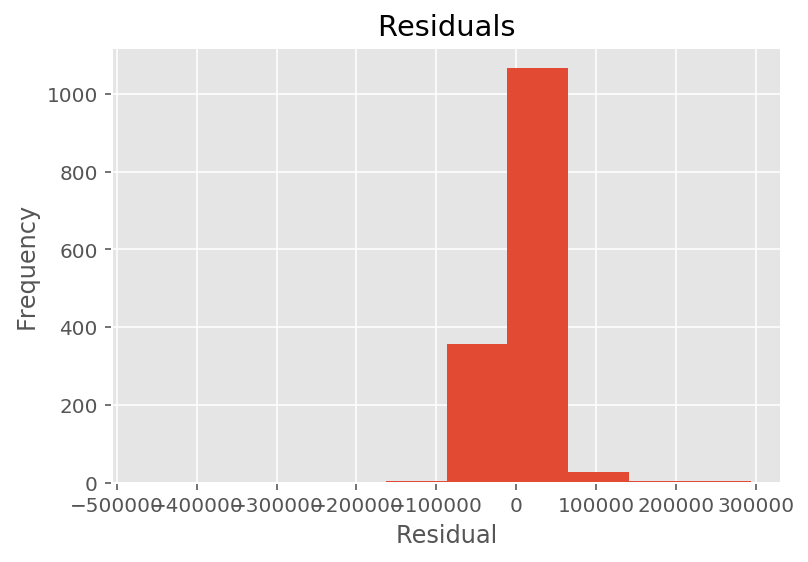

In [66]:
#Calculate residuals
house['resid']=house.saleprice-house.predict
print('Mean residual: ' + str(house.resid.mean()))
print('Median residual: ' + str(house.resid.median()))
house.resid.plot(kind='hist')
plt.xlabel('Residual')
plt.title('Residuals')
plt.show()

In [67]:
#Dataframe of changeable qualities
renovate=house[['utilities', 'overallcond', 'roofstyle', 'roofmatl',
       'masvnrtype', 'masvnrarea', 'exterqual', 'extercond', 'bsmtcond',
       'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc',
       'centralair', 'electrical', 'lowqualfinsf', 'kitchenqual', 
       'fireplacequ', 'garagefinish', 'garagequal','porch_present',
       'garagecond', 'paveddrive', 'wooddecksf', 'openporchsf',
       'enclosedporch', '3ssnporch', 'screenporch', 'poolarea', 'poolqc',
       'fence', 'miscfeature', 'resid','yrsold']]

In [68]:
renovate.fillna(0,inplace=True)

/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


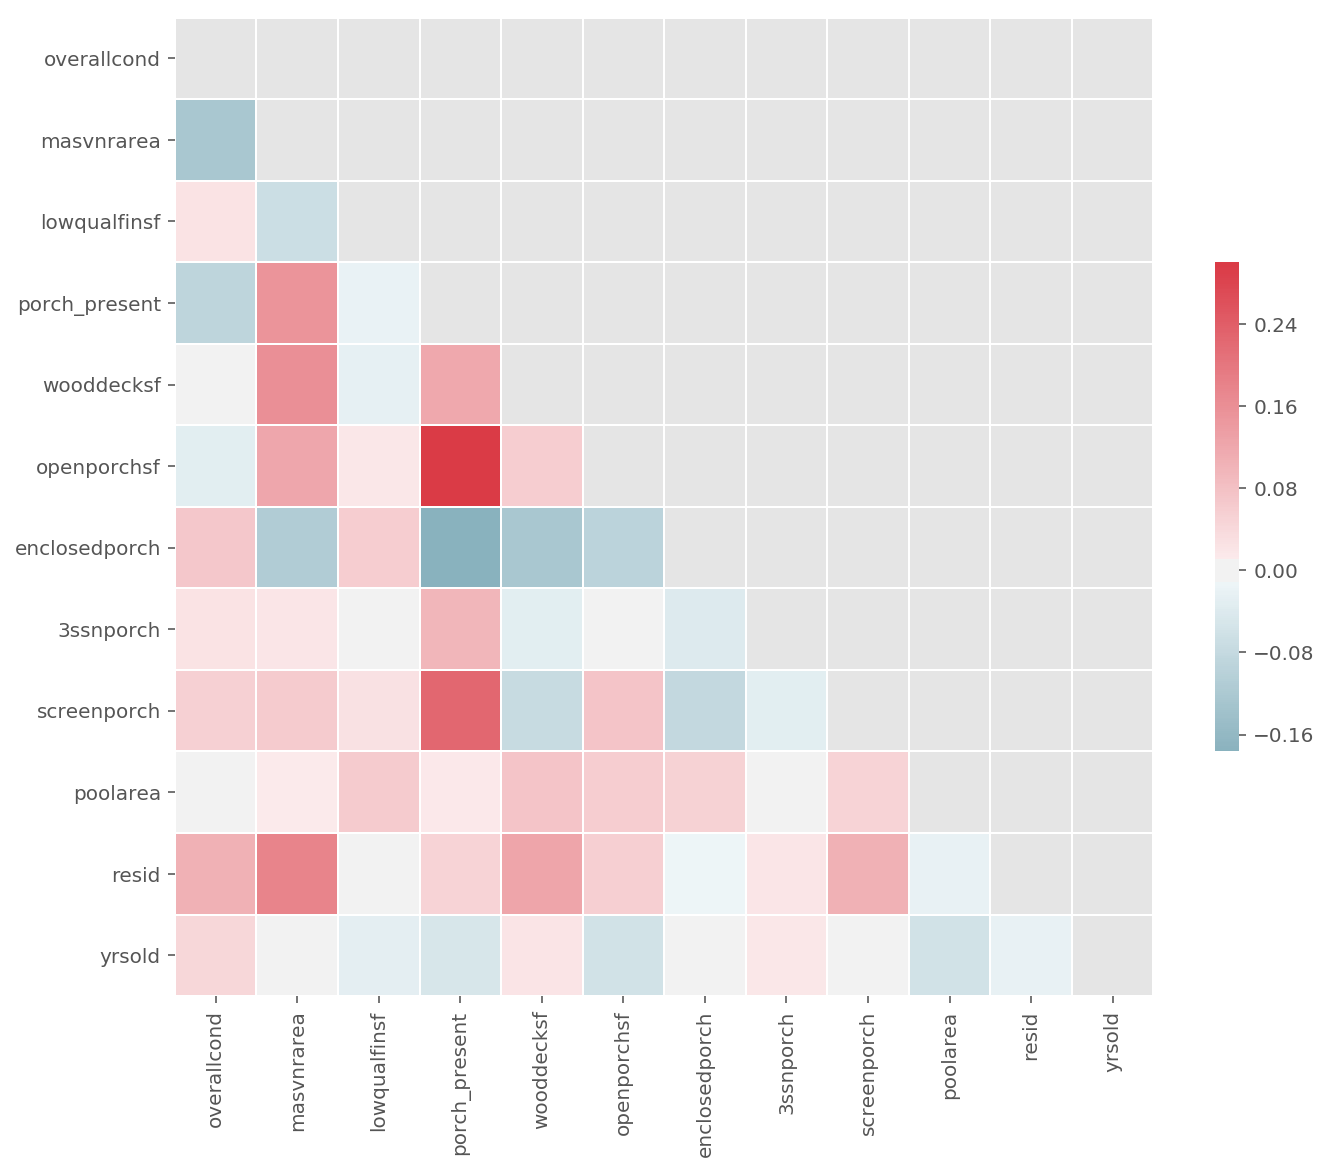

In [42]:
corr=renovate.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))


cmap = sns.diverging_palette(220, 10, as_cmap=True)


sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

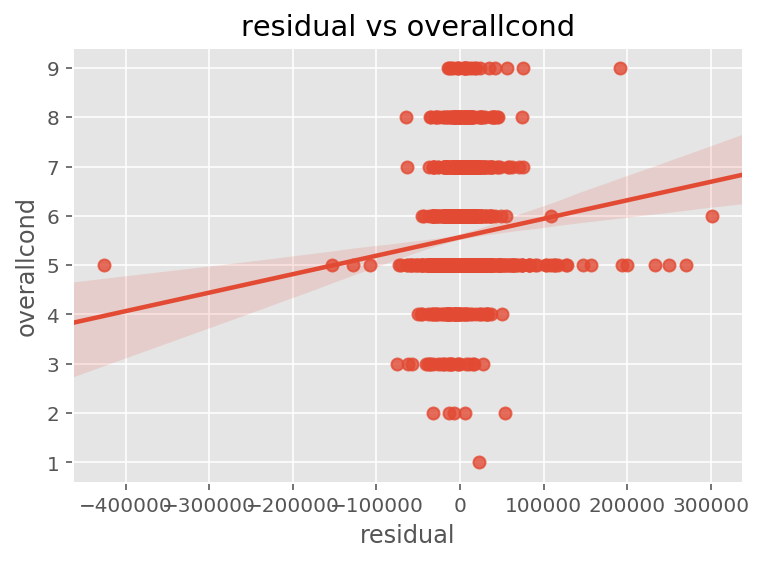

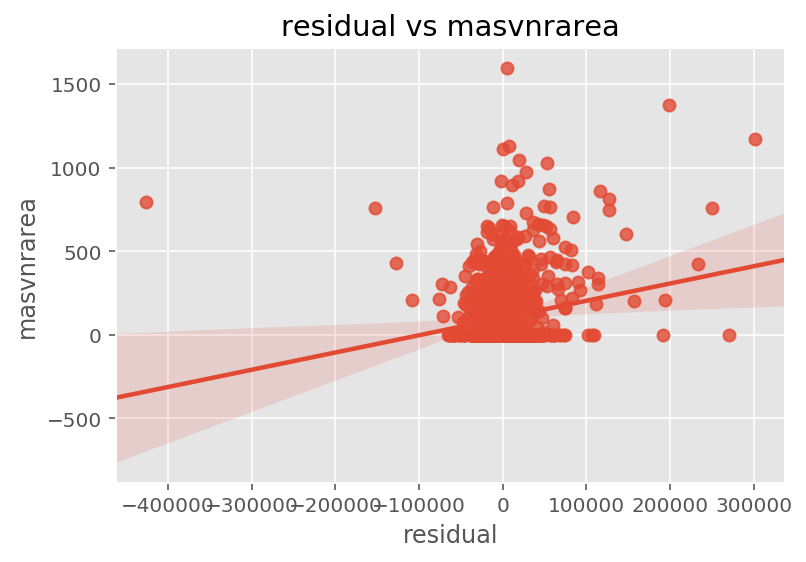

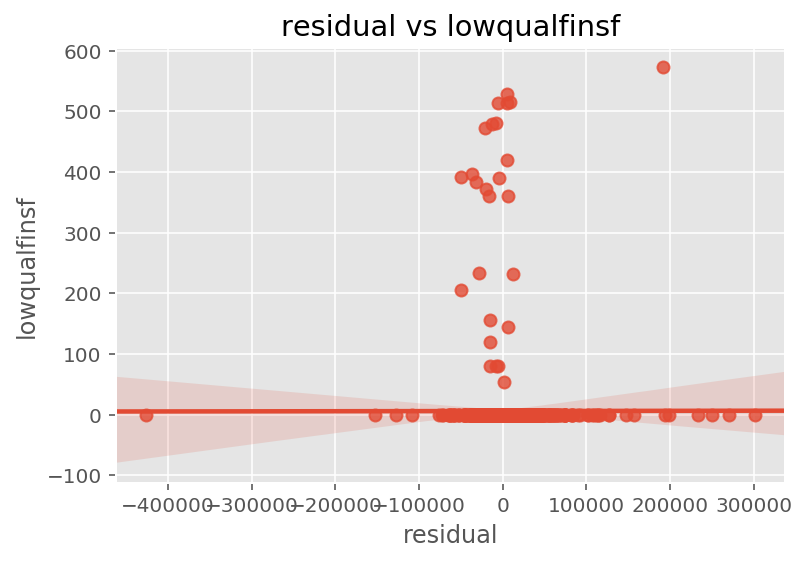

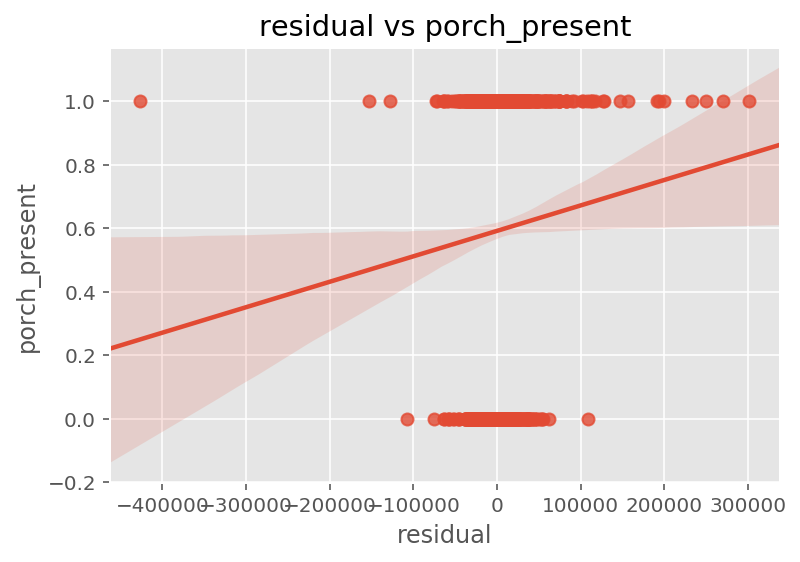

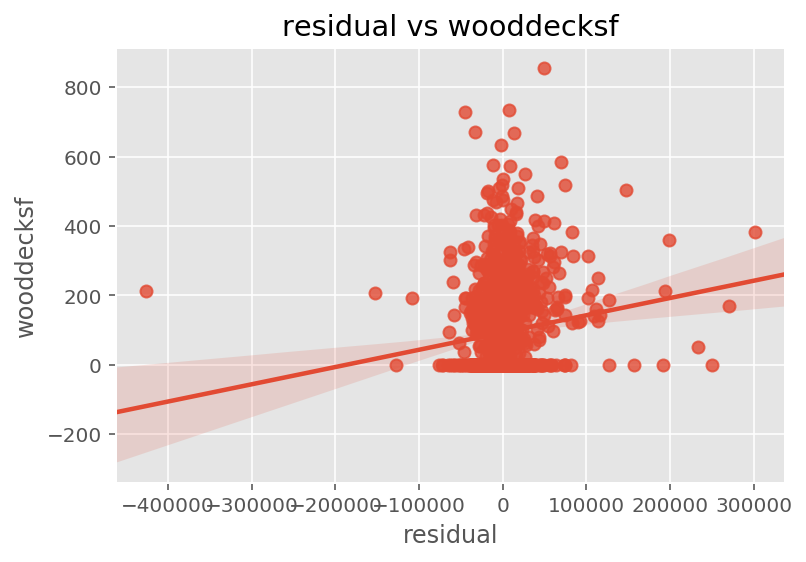

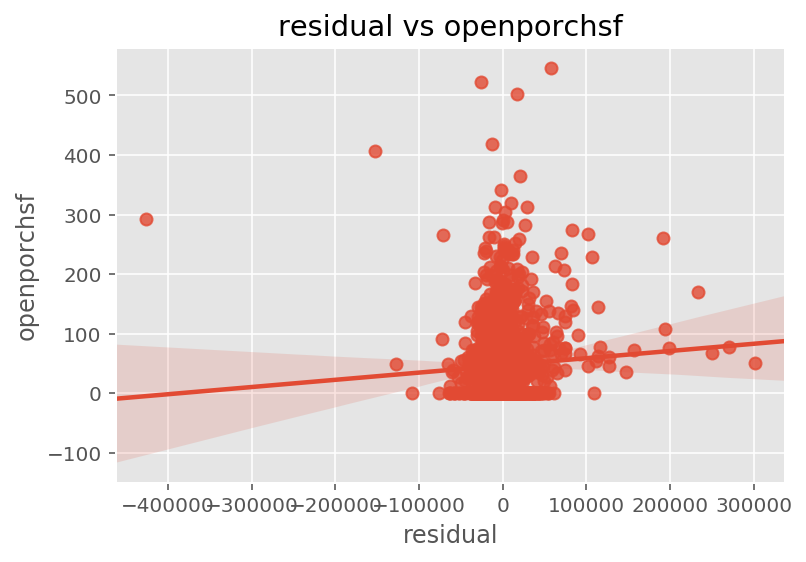

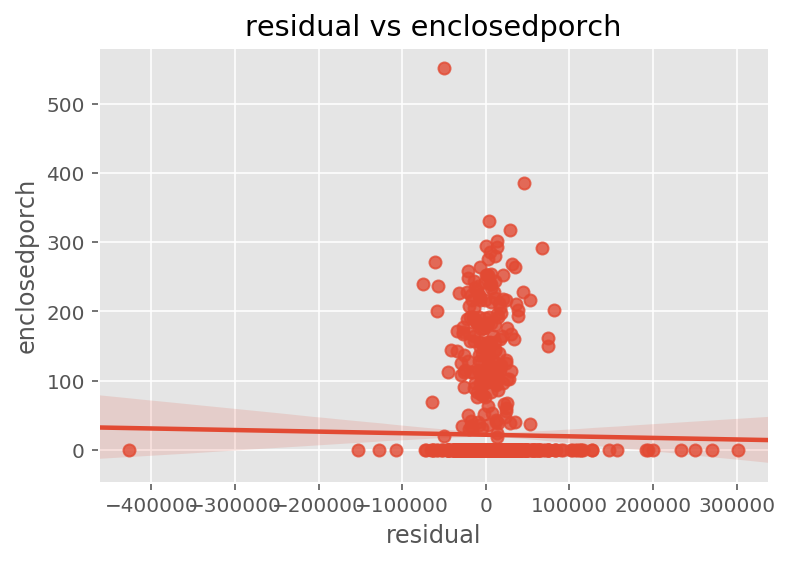

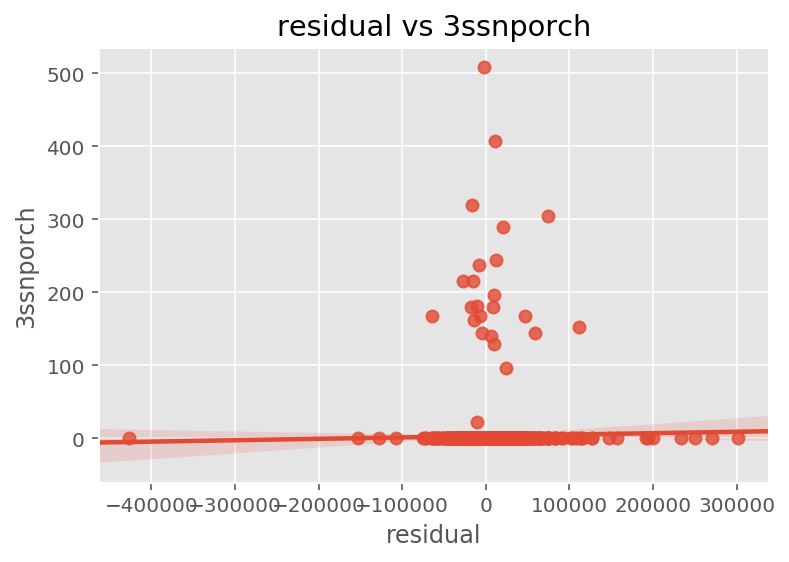

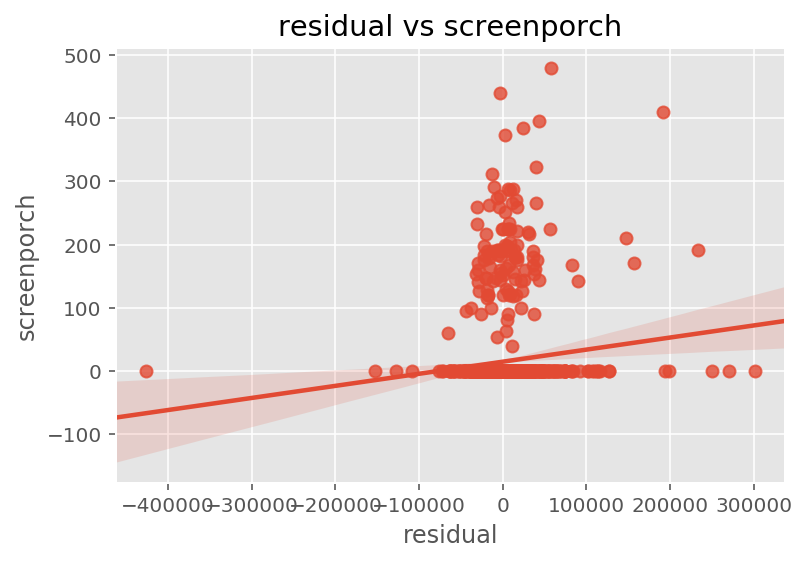

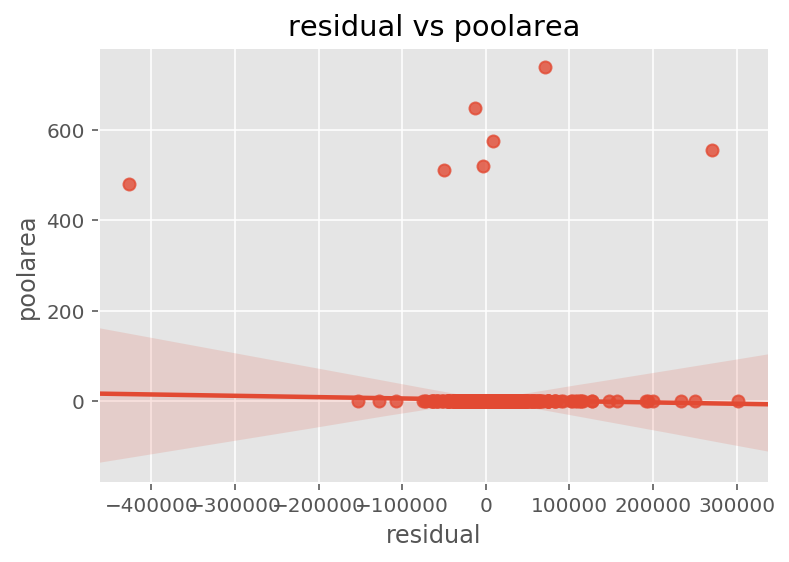

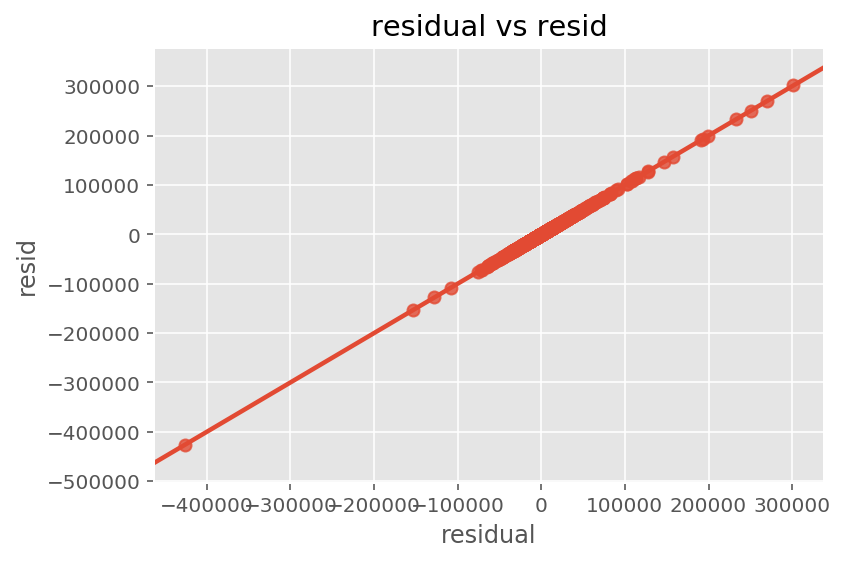

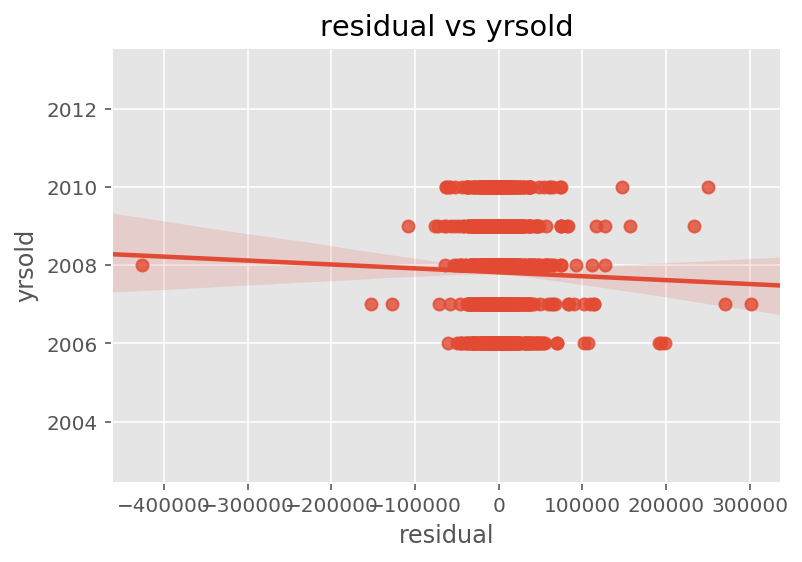

In [43]:
for i in renovate.columns:
    if renovate[i].dtypes!='O':
        sns.regplot(x="resid", y=i,data=renovate)
        plt.xlabel('residual')
        plt.ylabel(i)
        plt.title('residual vs ' + i)
        plt.show()

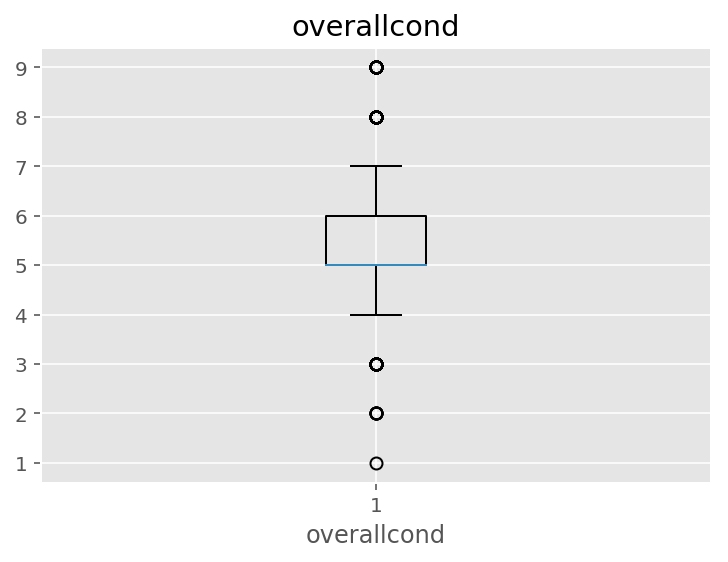

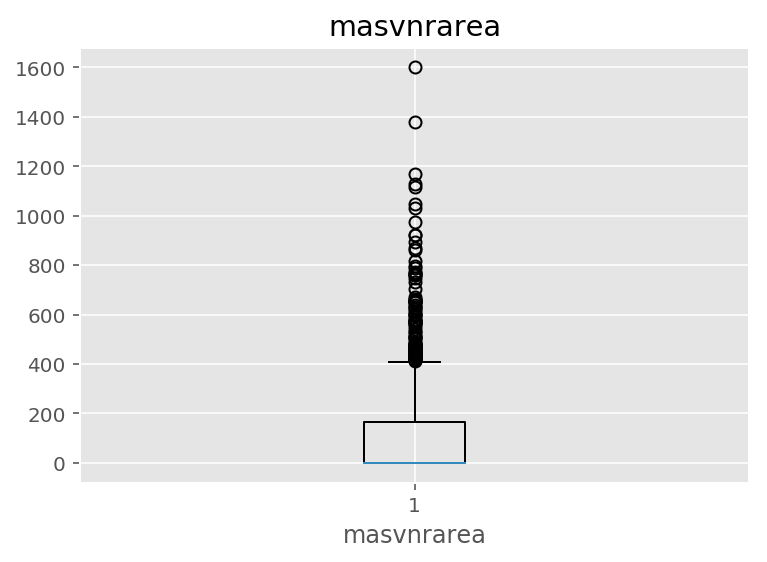

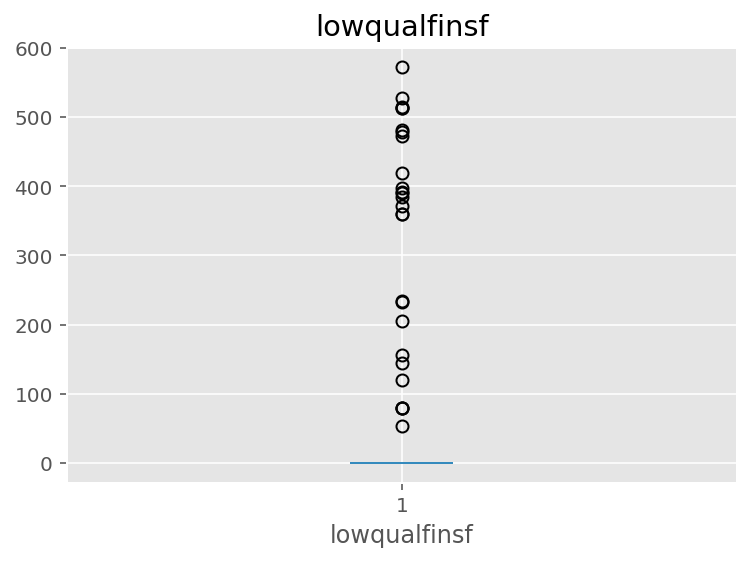

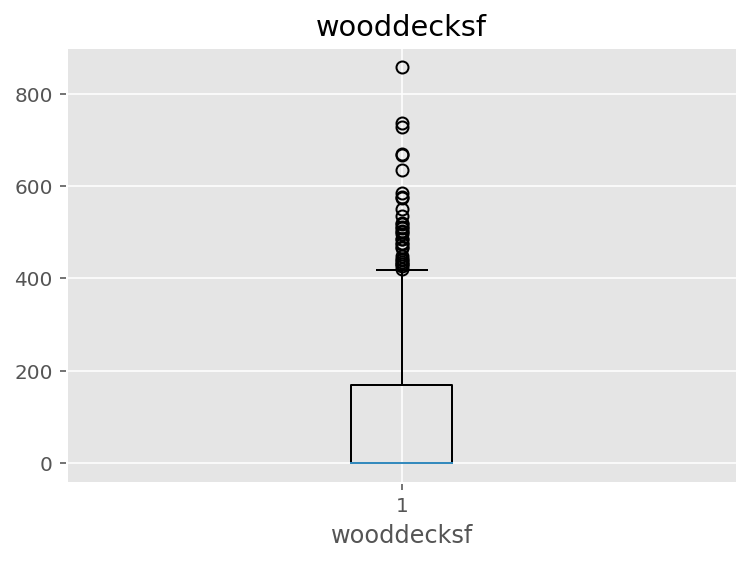

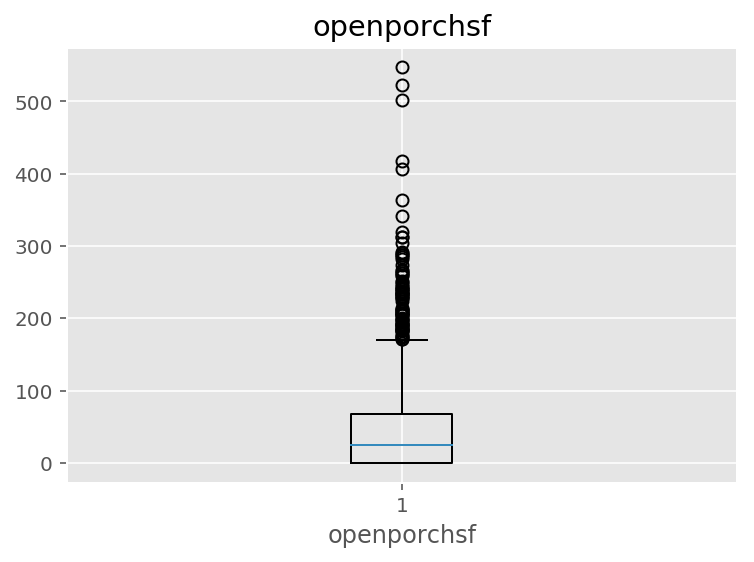

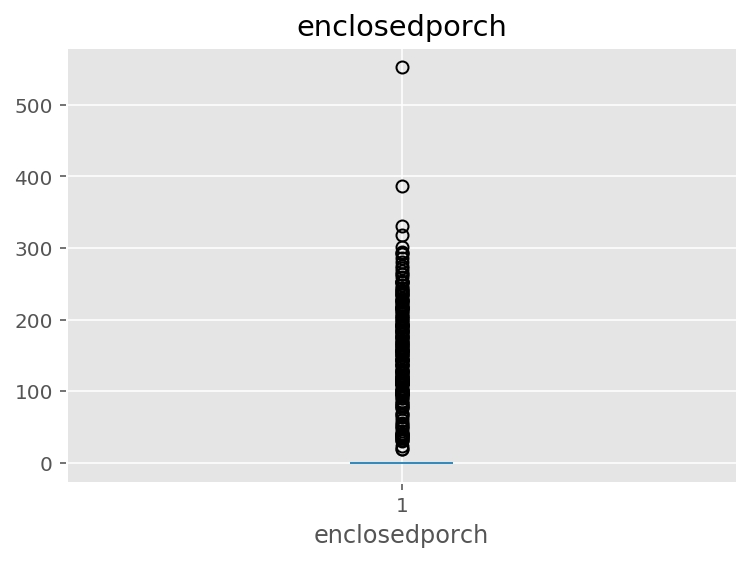

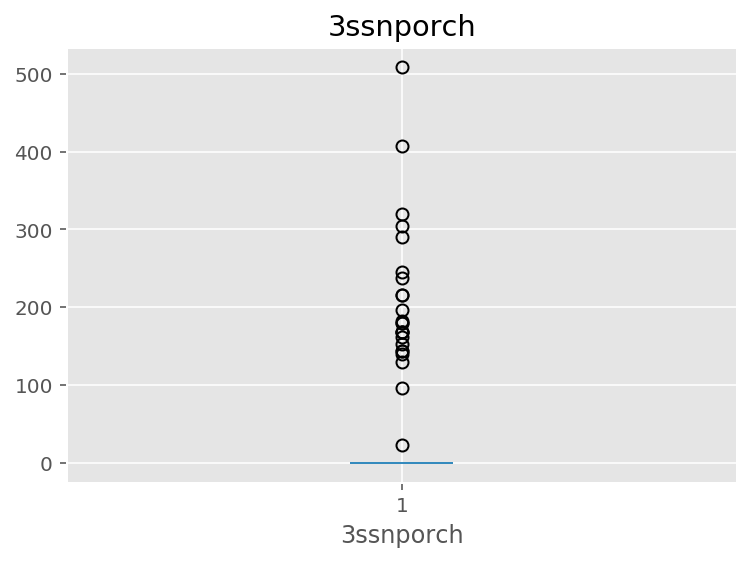

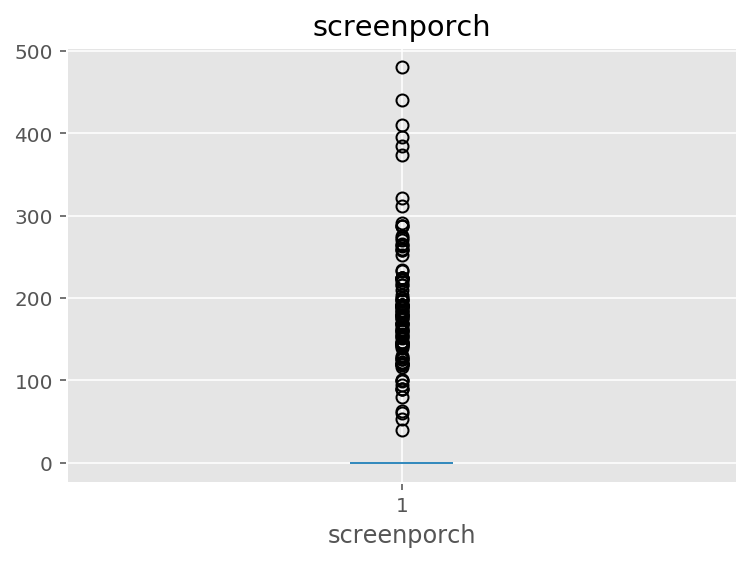

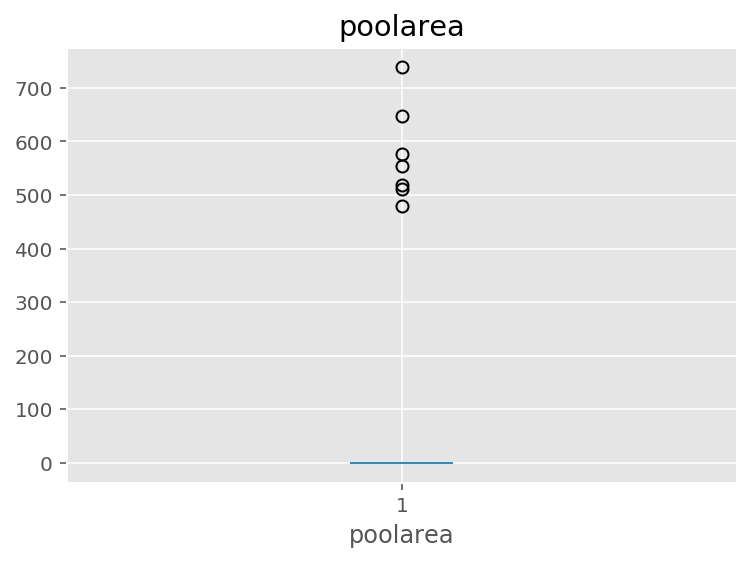

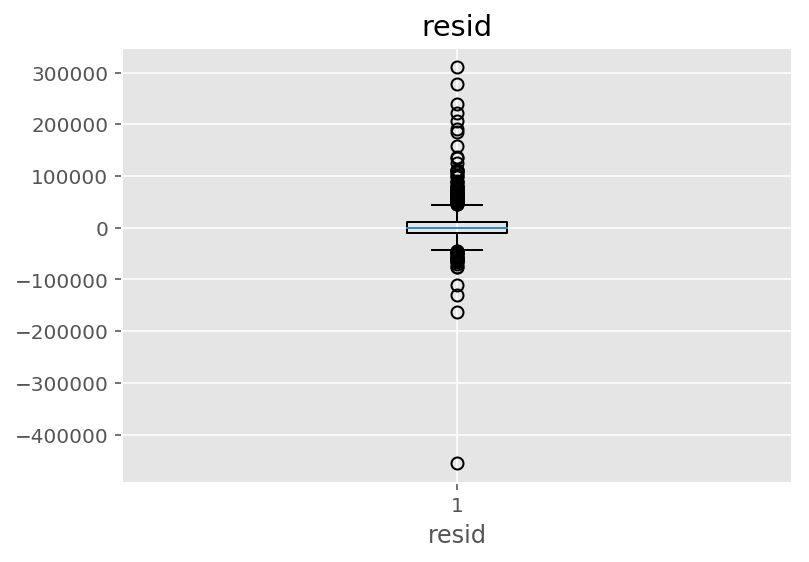

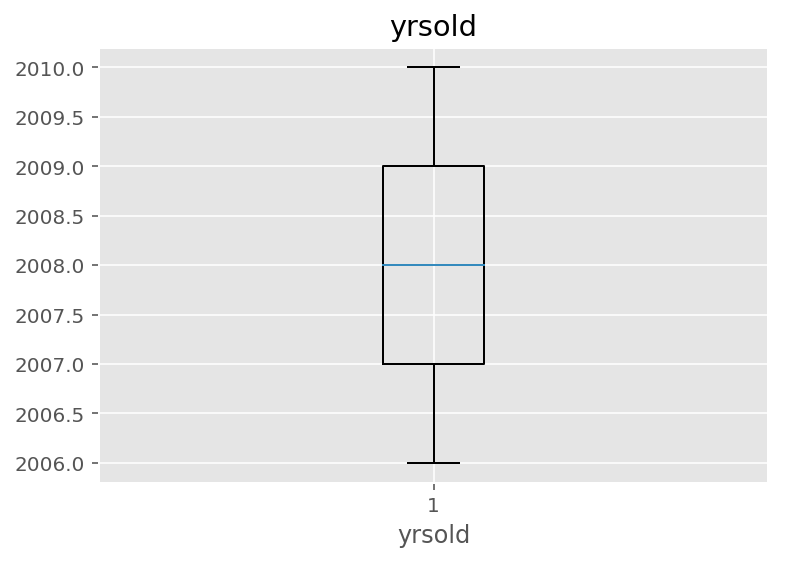

In [174]:
for i in renovate.columns:
    if renovate[i].dtypes!='O':
        plt.boxplot(renovate[i])
        plt.xlabel(i)
        plt.title( i)
        plt.show()

Again, as I will be using the Lasso regulizer I will keep all predictors but this time not remove outliers as I do not believe any are influential enough to have a massive effect on my result

In [69]:
renovate_dum=pd.get_dummies(renovate,drop_first=True)
renovate_dumn=pd.get_dummies(renovate_dum,columns=['overallcond'],drop_first=True)
X_train2=renovate_dum[renovate_dum.yrsold<2010]
X_test2=renovate_dum[renovate_dum.yrsold==2010]
y_train2=X_train2.pop('resid')
y_test2=X_test2.pop('resid')

In [70]:
X_train2=X_train2.drop('yrsold',axis=1)
X_test2=X_test2.drop('yrsold',axis=1);

In [71]:
X_std_train2 = scaler.fit_transform(X_train2)
X_std_test2=scaler.transform(X_test2)
X_tra2=pd.DataFrame(X_std_train2,columns=X_train2.columns)
X_te2=pd.DataFrame(X_std_test2,columns=X_test2.columns)

In [73]:
en_res=ElasticNetCV(n_alphas=100,l1_ratio=[i/100 for i in range(1,101)],cv=5)
en_res.fit(X_tra2,y_train2)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             l1_ratio=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
                       0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18,
                       0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27,
                       0.28, 0.29, 0.3, ...],
             max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
             positive=False, precompute='auto', random_state=None,
             selection='cyclic', tol=0.0001, verbose=0)

In [74]:
print('Train R2: ' + str(en_res.score(X_tra2,y_train2)))
print('Test R2: ' + str(en_res.score(X_te2,y_test2)))

Train R2: 0.16480867278874944
Test R2: 0.1265270635876341


In [76]:
en_params2 = {
    'n_alphas': [1,10,50,80,100],
    'l1_ratio': [.1, .5, .7, .9, .95, .99, 1],
    'fit_intercept': [True,False],
    'random_state':[1,100,1000],
    'max_iter':[1,10,100,1000,10000]}
model2=ElasticNetCV()
en_gridsearch2 = GridSearchCV(model2,
                              en_params2,
                              n_jobs=-1, 
                              cv=5, 
                              verbose=1, 
                              return_train_score=True)

en_gridsearch2.fit(X_tra2, y_train2)

Fitting 5 folds for each of 1050 candidates, totalling 5250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 1548 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4208 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 5250 out of 5250 | elapsed:  3.1min finished
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of ite

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNetCV(alphas=None, copy_X=True, cv='warn',
                                    eps=0.001, fit_intercept=True, l1_ratio=0.5,
                                    max_iter=1000, n_alphas=100, n_jobs=None,
                                    normalize=False, positive=False,
                                    precompute='auto', random_state=None,
                                    selection='cyclic', tol=0.0001, verbose=0),
             iid='warn', n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
                         'max_iter': [1, 10, 100, 1000, 10000],
                         'n_alphas': [1, 10, 50, 80, 100],
                         'random_state': [1, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

In [77]:
en_gridsearch2.best_params_

{'fit_intercept': False,
 'l1_ratio': 0.9,
 'max_iter': 10,
 'n_alphas': 1,
 'random_state': 1}

In [78]:
best_en2 = en_gridsearch2.best_estimator_
print('Train R2: ' + str(best_en2.score(X_tra2, y_train2)))
print('Test R2: ' + str(best_en2.score(X_te2, y_test2)))

Train R2: 0.20557861974129932
Test R2: 0.1473921542356429


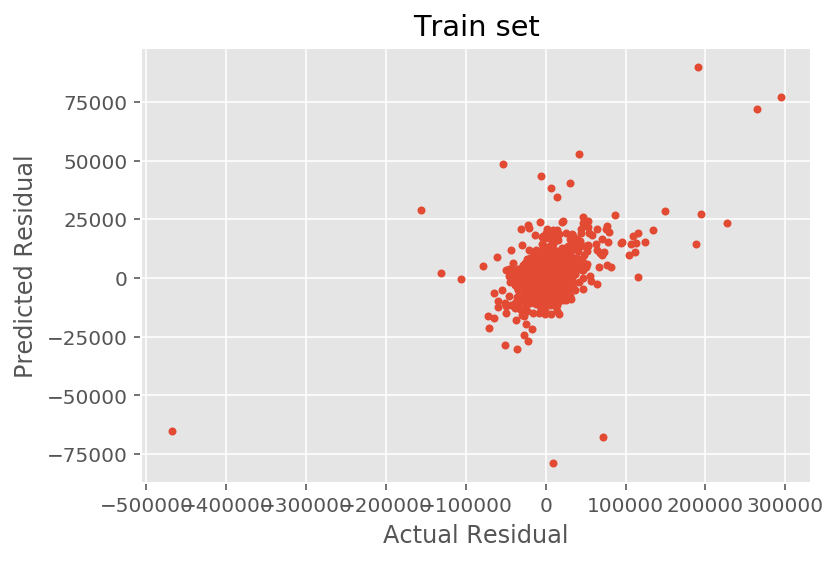

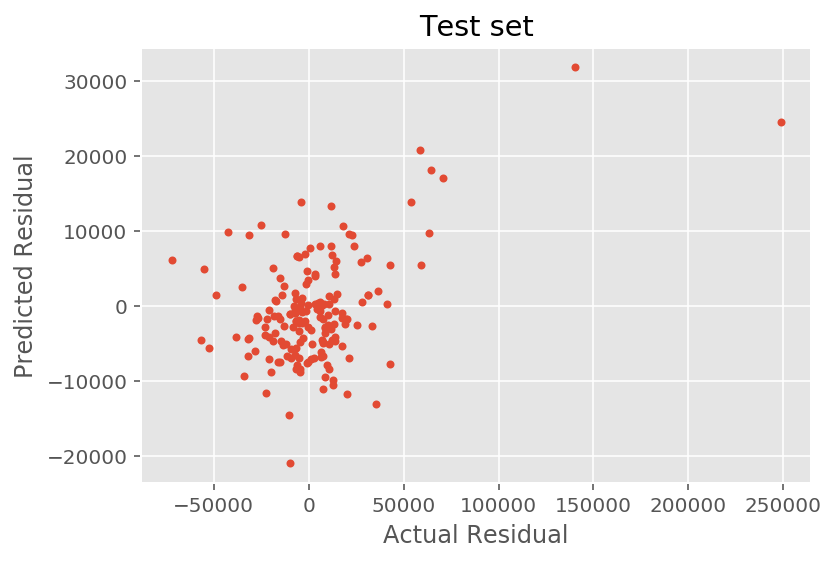

In [79]:
plt.plot(y_train2,best_en2.predict(X_tra2),'.')
plt.title('Train set')
plt.xlabel('Actual Residual')
plt.ylabel('Predicted Residual')
plt.show()
plt.plot(y_test2,best_en2.predict(X_te2),'.')
plt.title('Test set')
plt.xlabel('Actual Residual')
plt.ylabel('Predicted Residual')
plt.show()

In [80]:
coeffs2=pd.DataFrame(list(zip(X_tra2.columns,best_en2.coef_)),columns=['feature','coef'])
coeffs2['abs_effect']=np.abs(coeffs.coef)

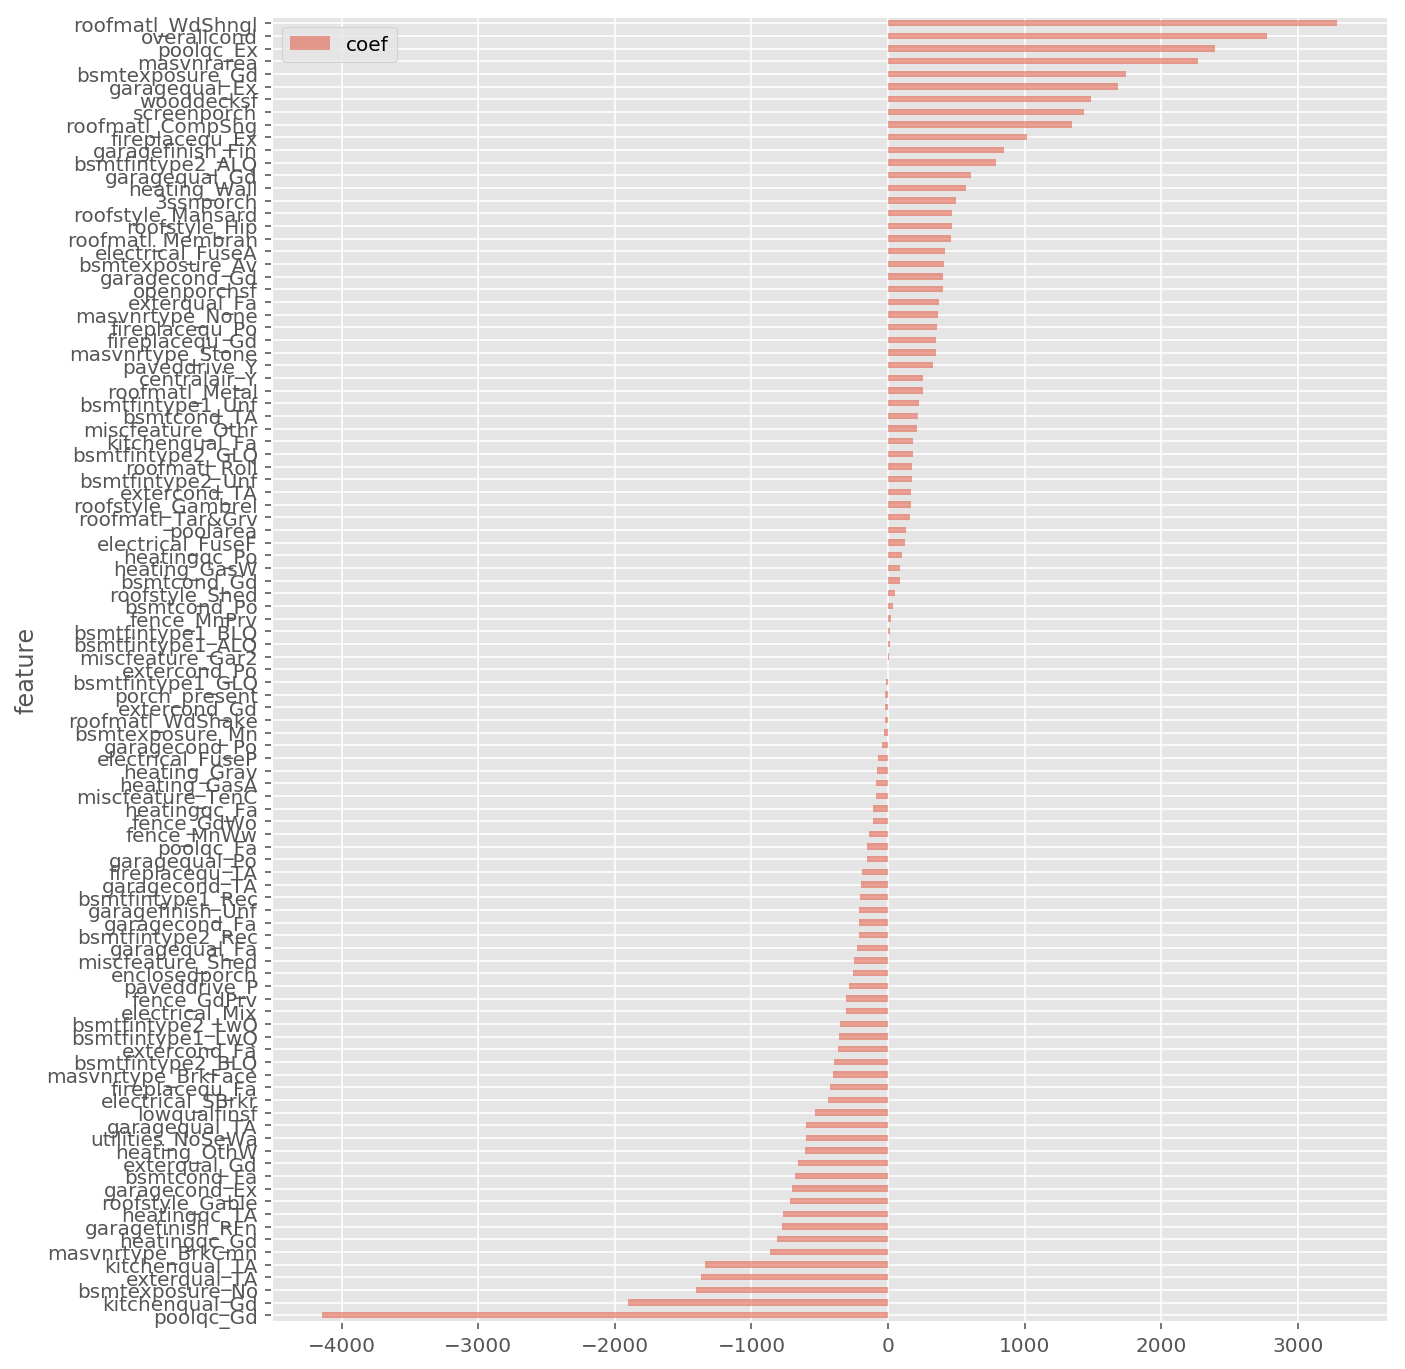

In [81]:
fig, ax =plt.subplots(figsize=(10,12))
coeffs2.sort_values(by='coef').plot(kind='barh',x='feature',y='coef',ax=ax,alpha=0.5);

In [82]:
#Table to show which changeable features have biggest effect on unexplained variance from first model
coeffs2.sort_values(by='abs_effect',ascending=False)[0:20]

feature         coef    abs_effect
4         wooddecksf  1485.104511  18809.319636
9           poolarea   132.918789  15833.839698
2       lowqualfinsf  -534.599635   8725.693276
80     garagequal_Ex  1681.257379   8002.620922
7          3ssnporch   500.180507   7238.289571
81     garagequal_Fa  -227.089074   7233.093772
39   bsmtexposure_Gd  1744.886160   6928.752603
8        screenporch  1434.024046   6716.487702
5        openporchsf   402.036818   6489.446159
59      heatingqc_Fa  -109.381012   4822.063091
45  bsmtfintype1_LwQ  -358.791626   4599.436168
29      exterqual_TA -1372.454860   4472.577099
38   bsmtexposure_Av   413.152522   3956.478630
44  bsmtfintype1_GLQ   -17.089218   3798.638045
86     garagecond_Fa  -211.708187   3576.870688
47  bsmtfintype1_Unf   225.809407   2369.263566
1         masvnrarea  2269.565939   2340.242055
83     garagequal_Po  -156.256655   2287.750939
49  bsmtfintype2_BLQ  -398.360100   2191.267109
22  roofmatl_WdShngl  3286.935513   2009.537471

1. The renovatable features with the biggest effects can be seen in the table above

2. The company can use this second model to determine if they should buy a property or not by comparing the features of the property against the list above, and if they can feasibly renovate/add some of those features then should consider buying it.

Both models should be used in conjunciton however. They should look for  properties where the actual saleprice is below that of the predicted price with renovatable features from the second model. That way they can increase the value of the property, towards its predicted price and make a profit.  

3. The best R2 on the test set was 15.9%. This is how much of the remaining variance is explained by this model

4. I do not trust this model. Firstly, the R2 is too low showing that the fixable features do not explain well the leftover variance. Secondly, having bought a house I suspect most buyers make their offers emotionally. They do not base it off models such as these but on what the estate agent says the house is worth. Buyers and sellers then negotiate on the price. Given that most properties in this dataset will have been sold this way, not by developers I would suspect the greatest amount of variance left can be explained by the emotional nature of buyers and sellers

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [549]:
#Create abormal feature in dataset
house['abnormal']=house.salecondition.apply(lambda x: 1 if x=='Abnorml' else 0)

In [550]:
fixed_df['abnormal']=house.abnormal
renovate['abnormal']=house.abnormal

/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


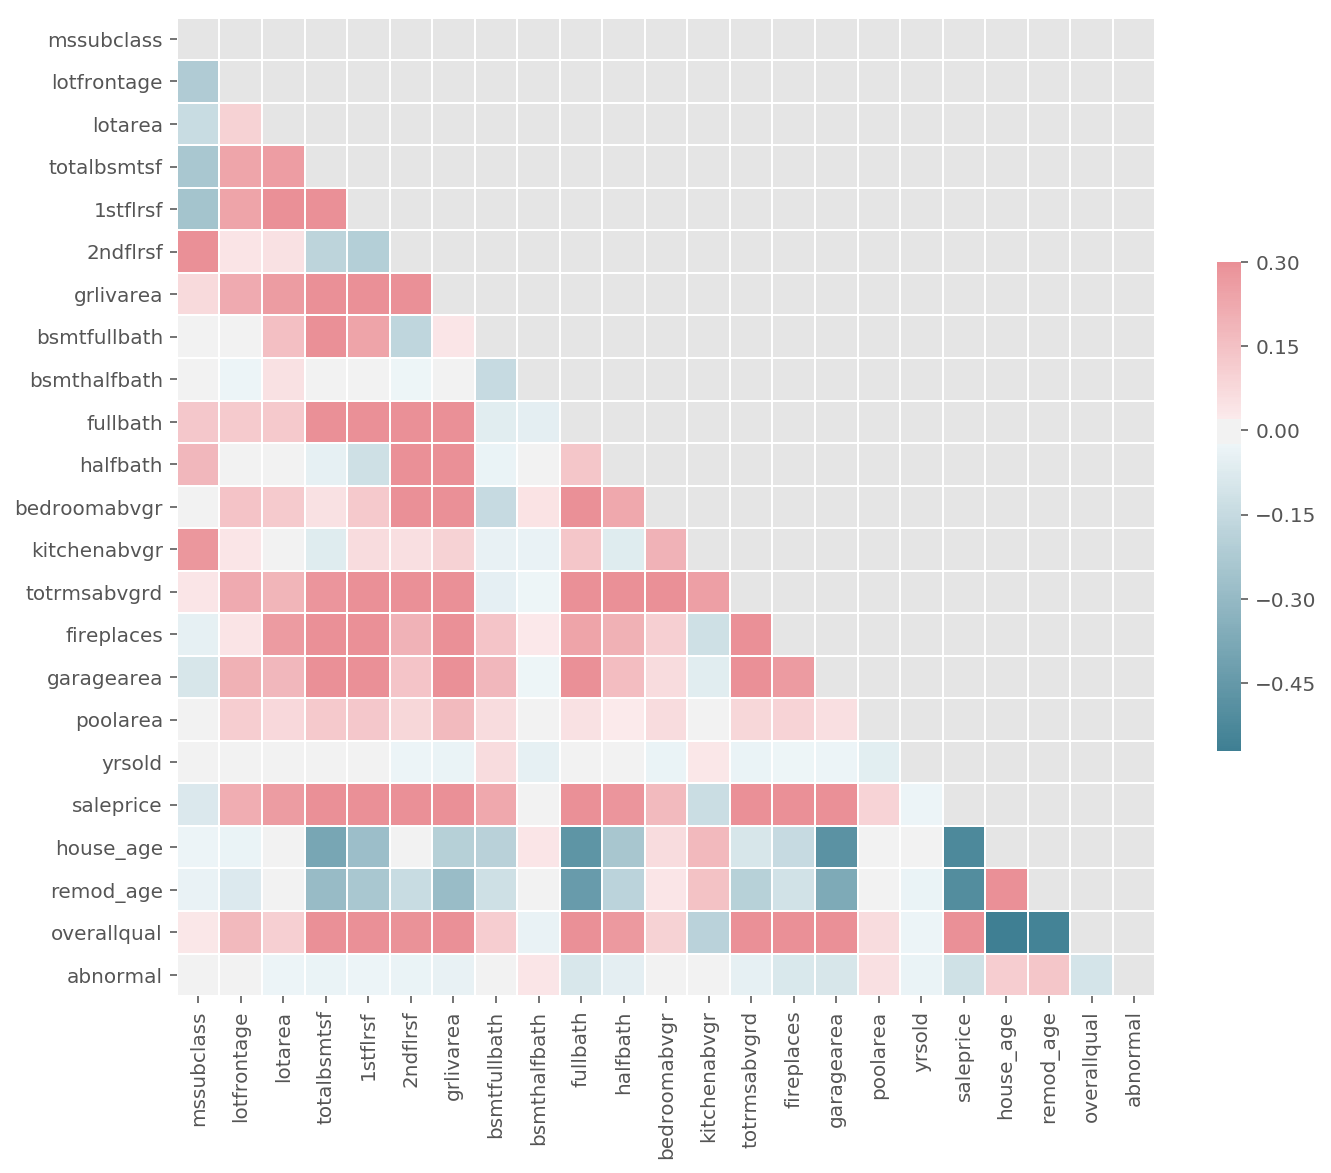

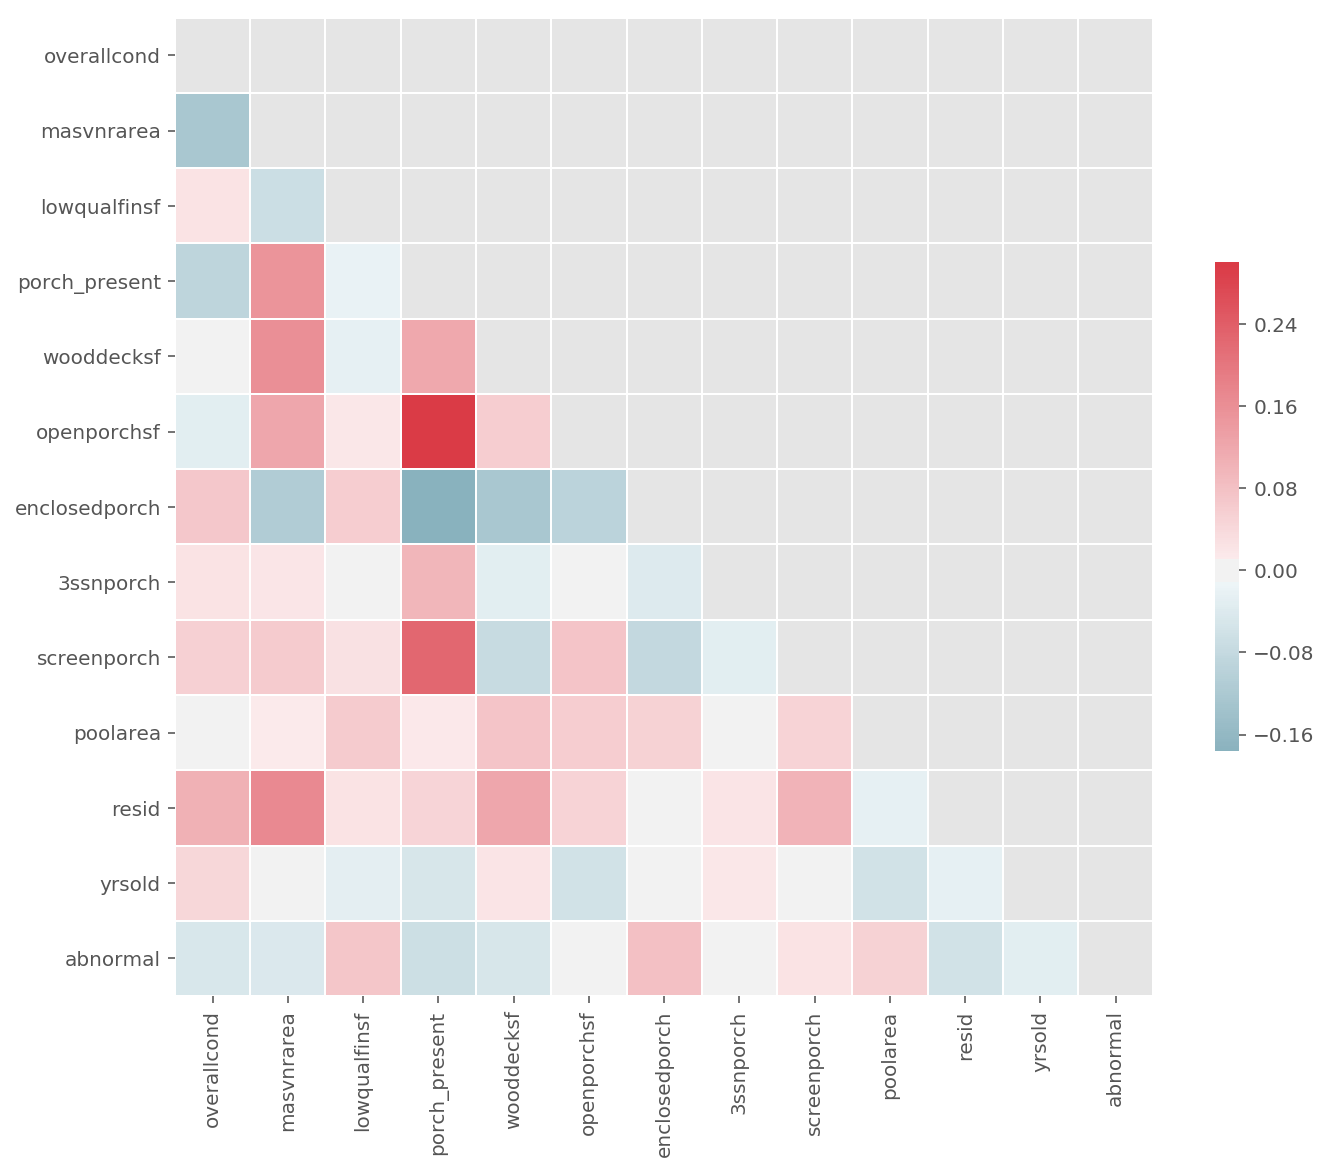

In [552]:
for feature in [fixed_df,renovate]:
    corr=feature.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))


    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

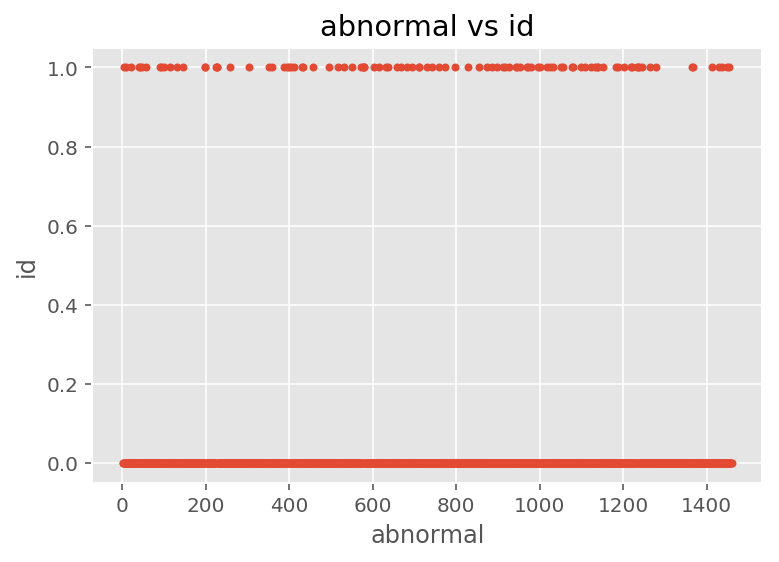

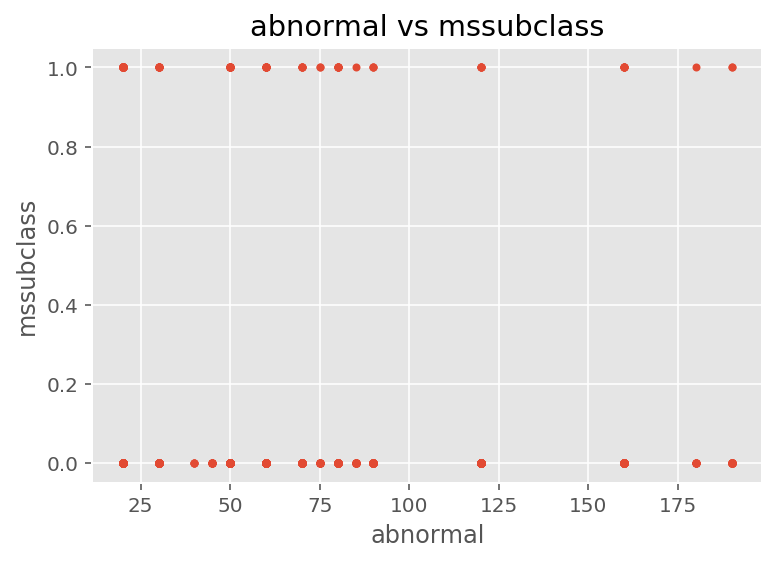

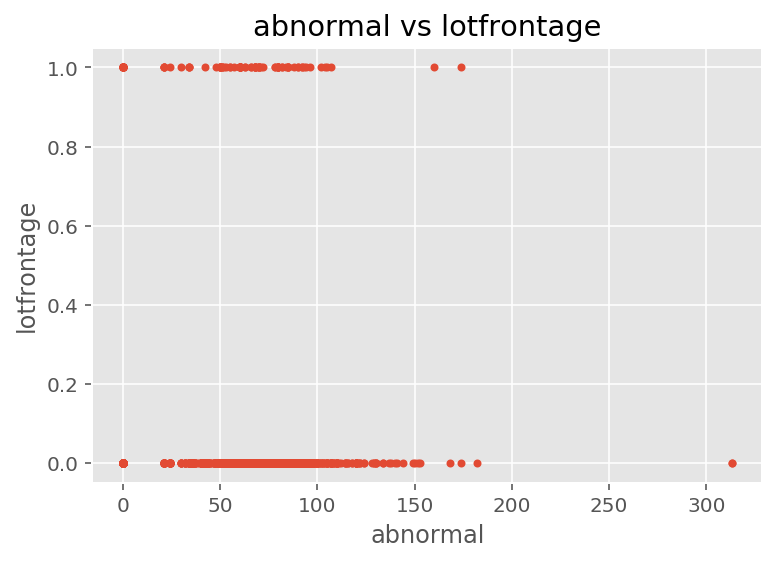

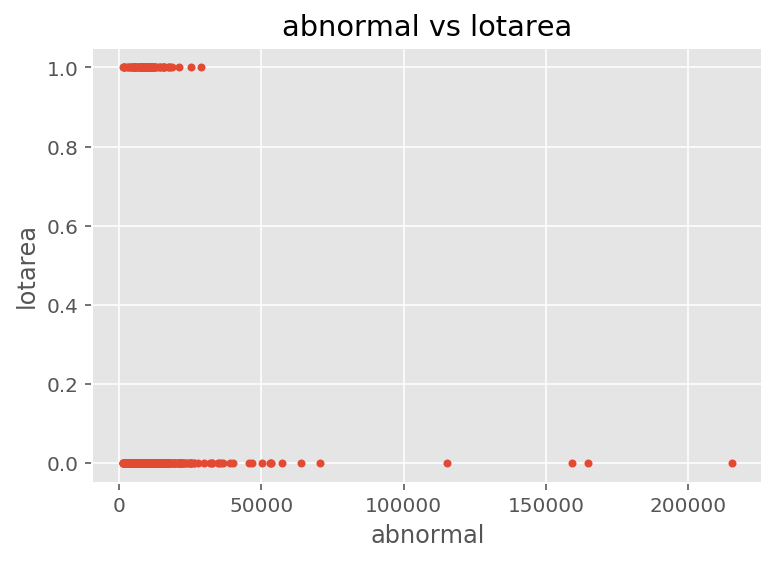

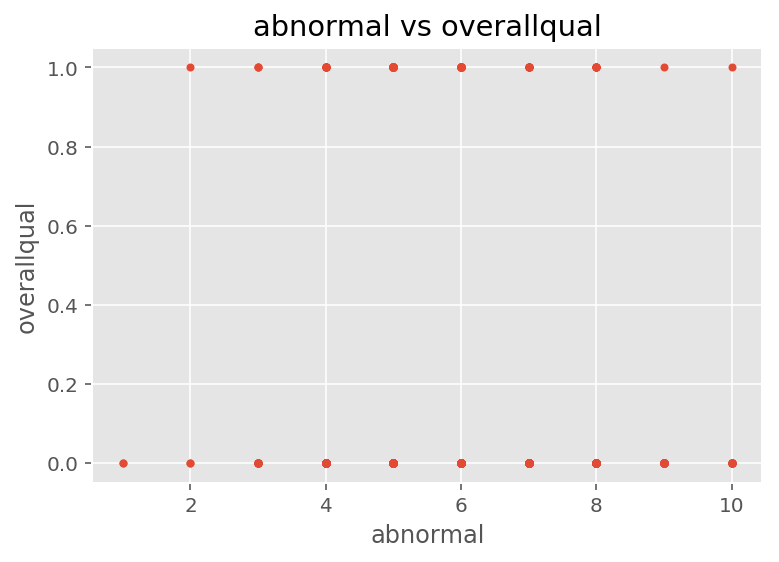

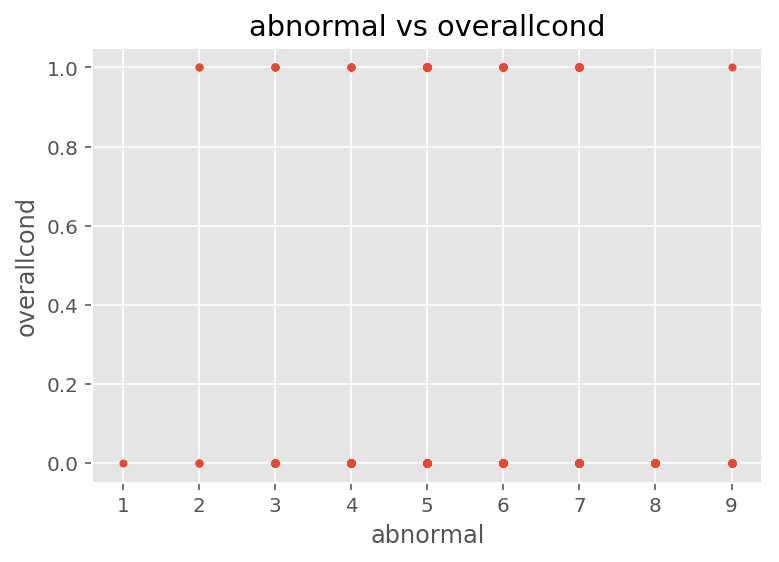

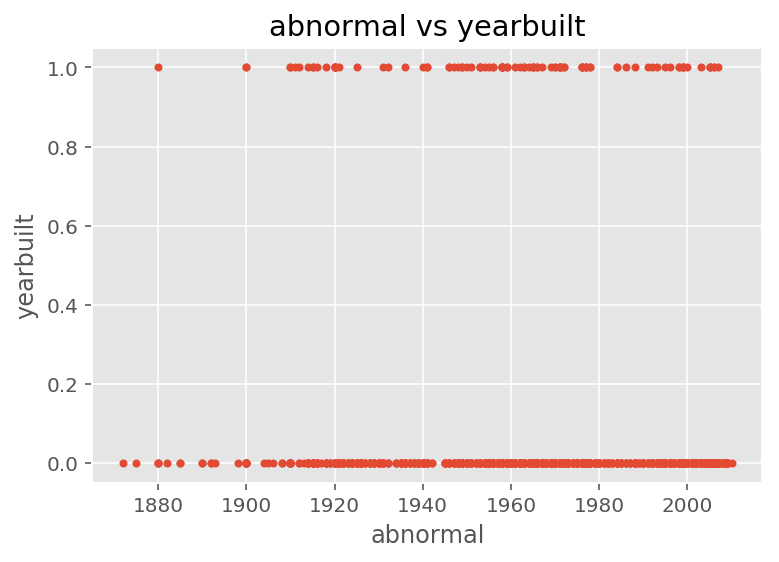

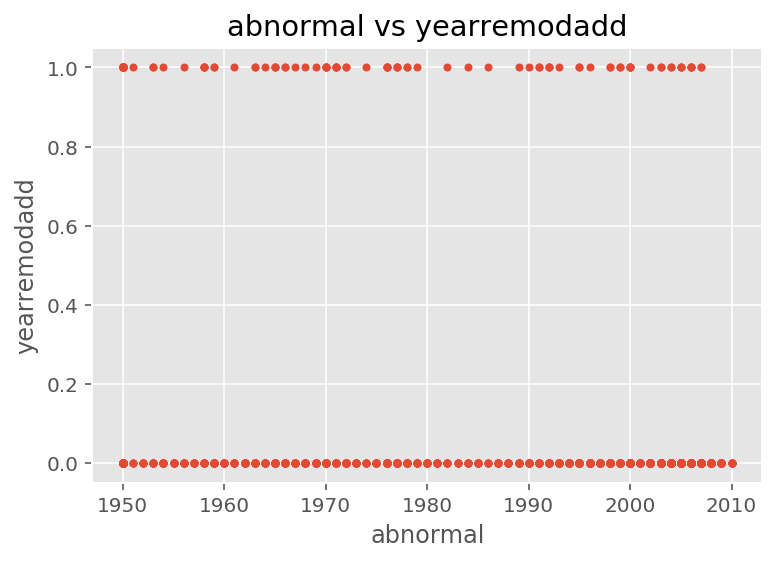

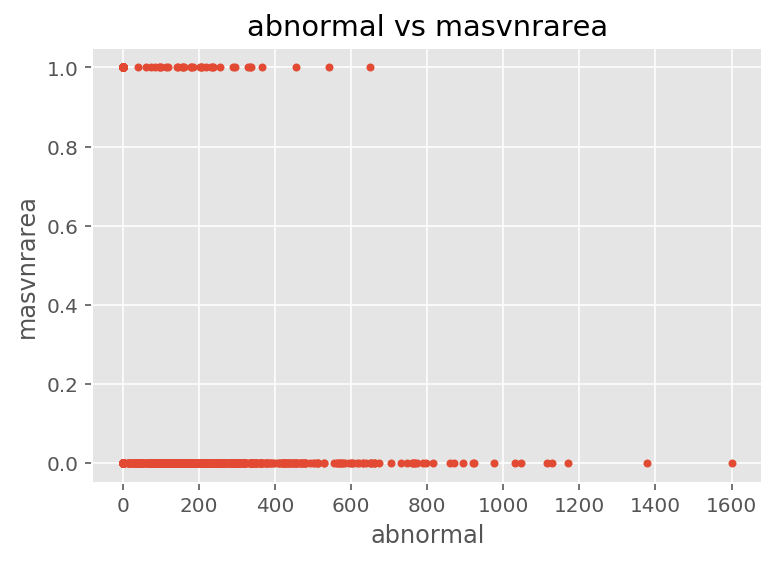

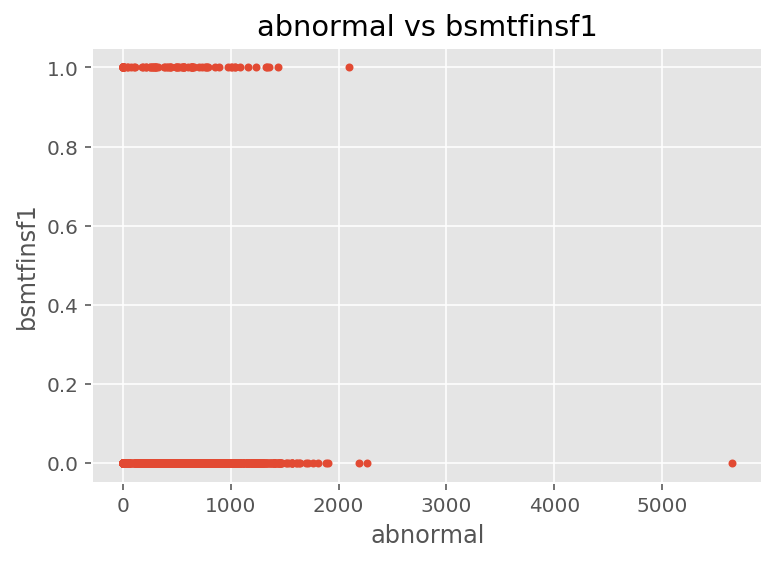

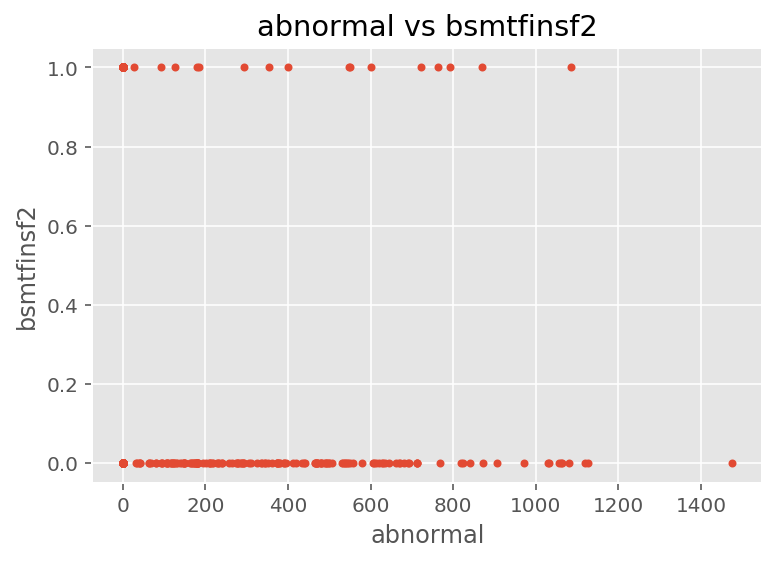

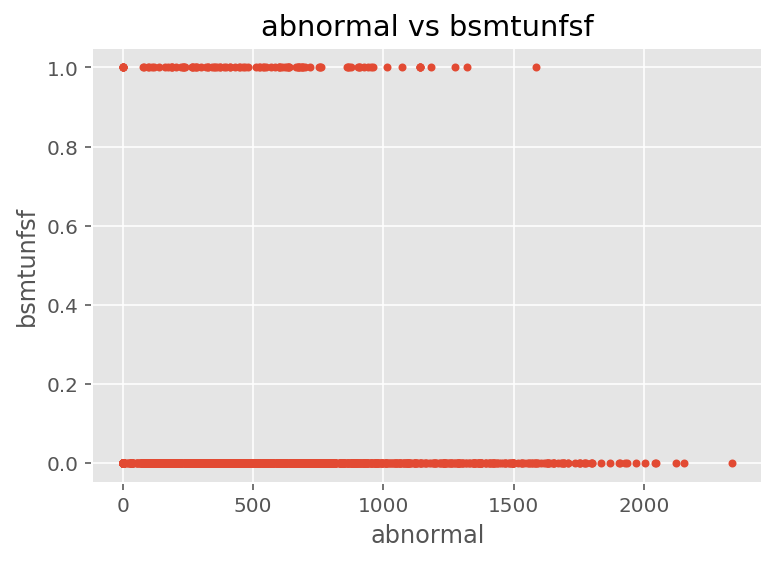

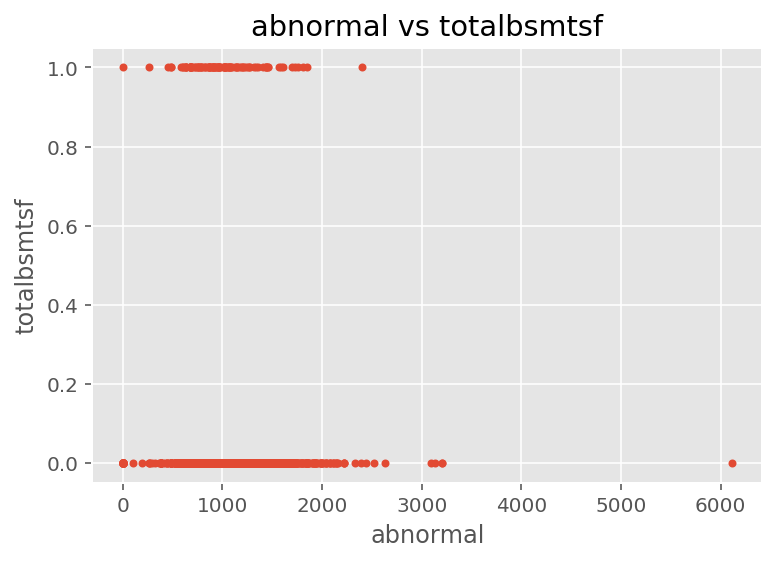

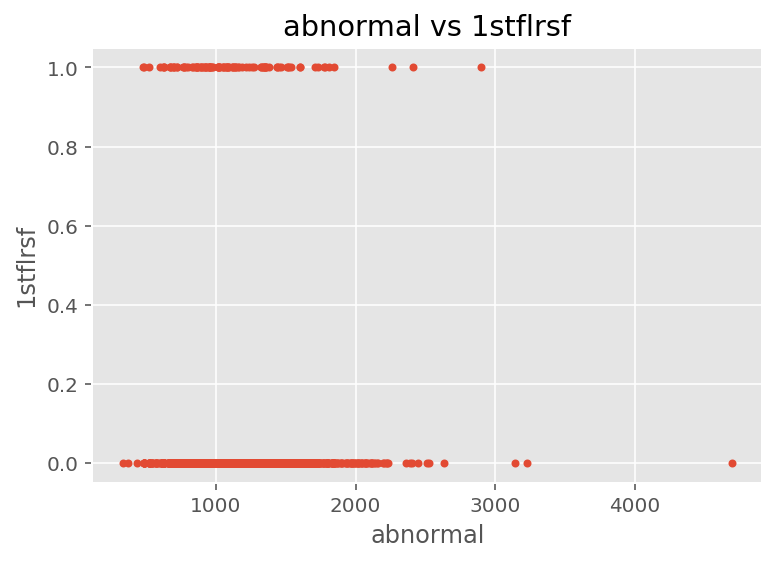

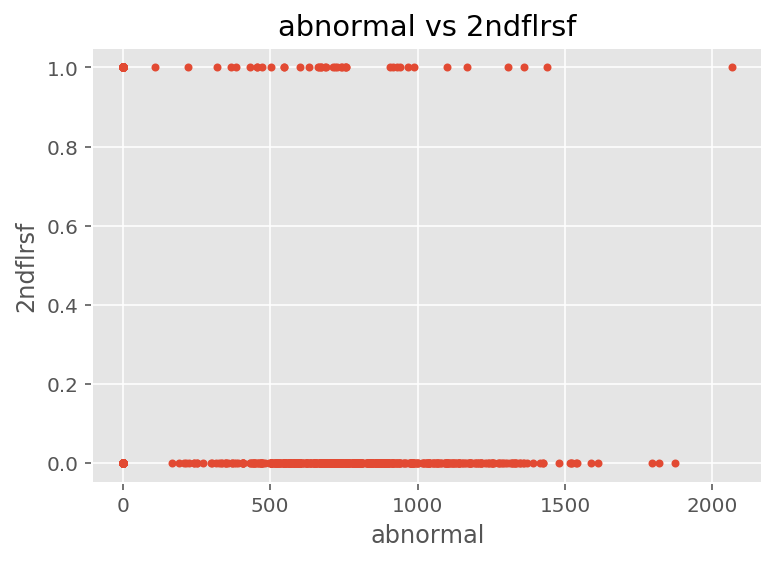

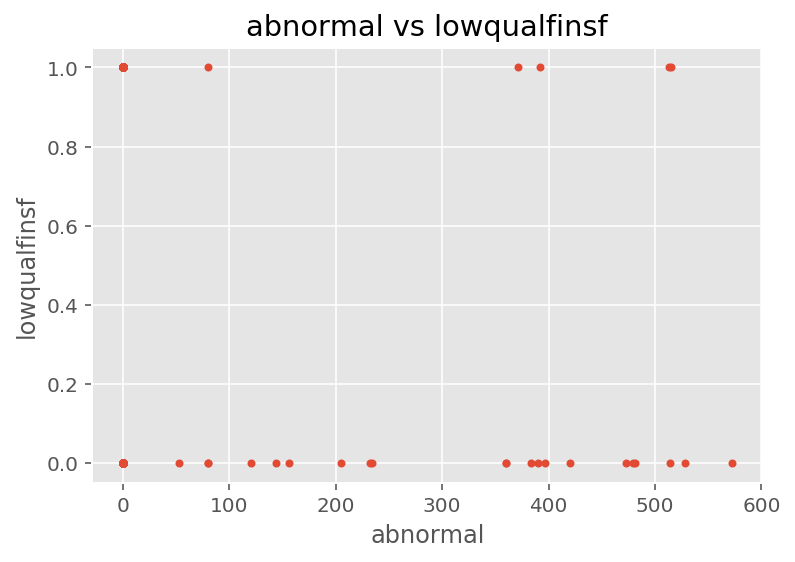

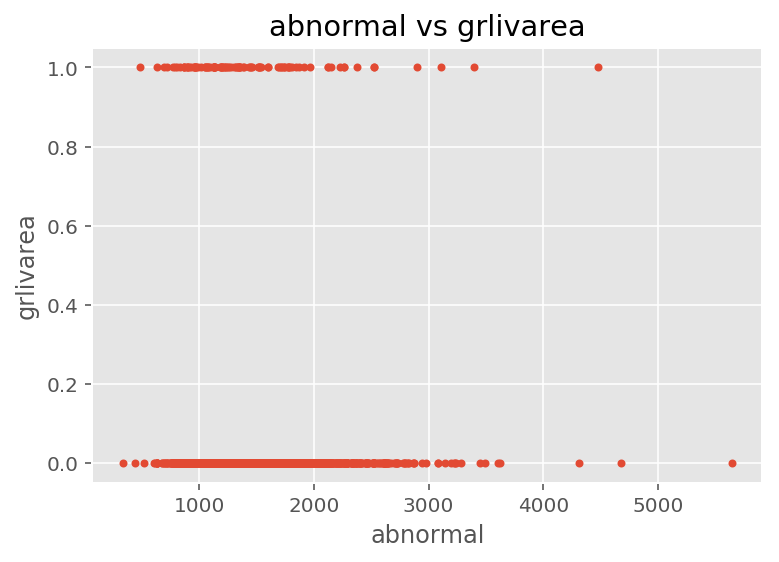

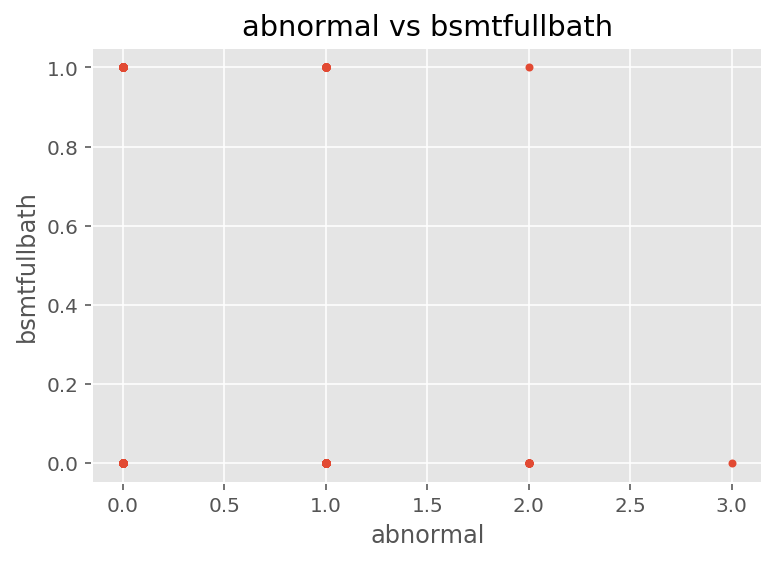

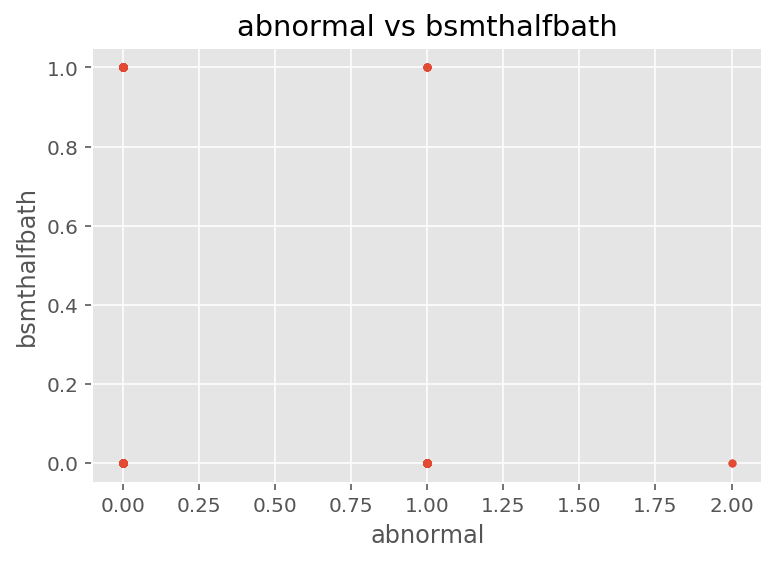

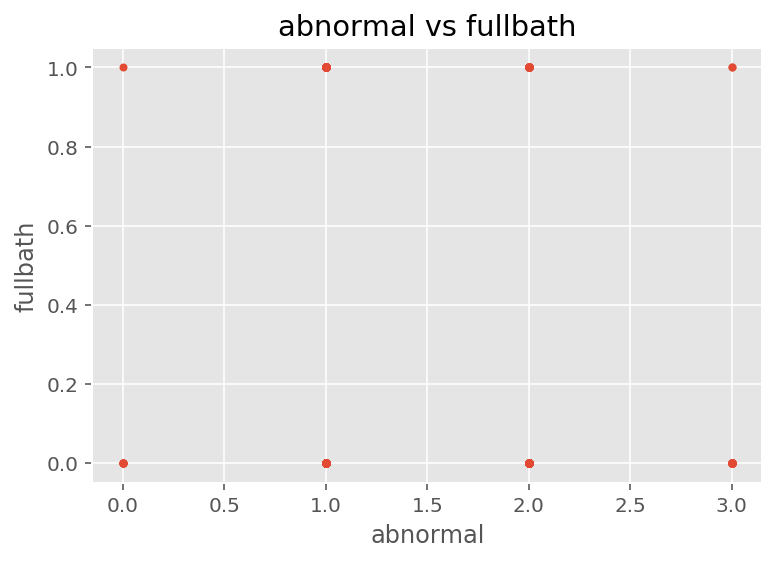

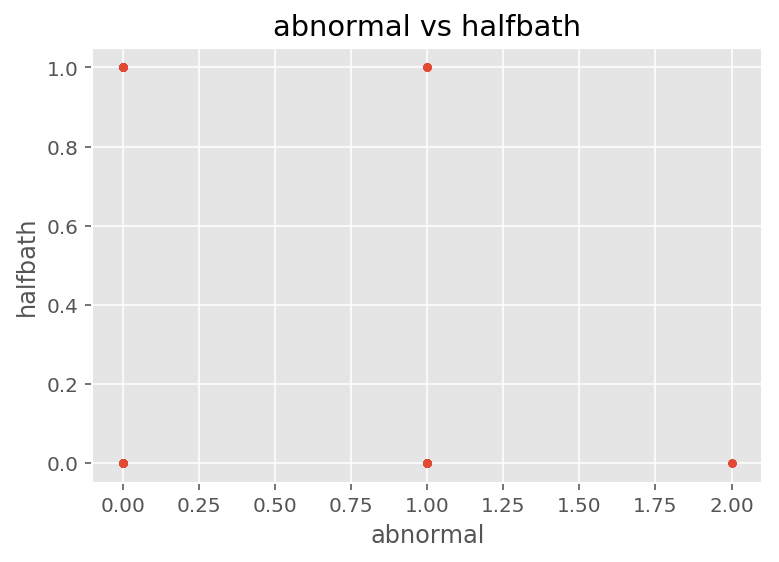

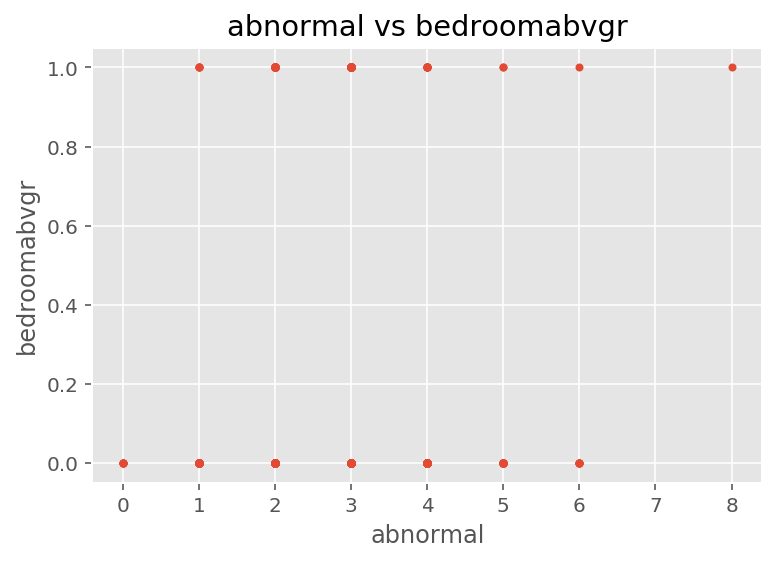

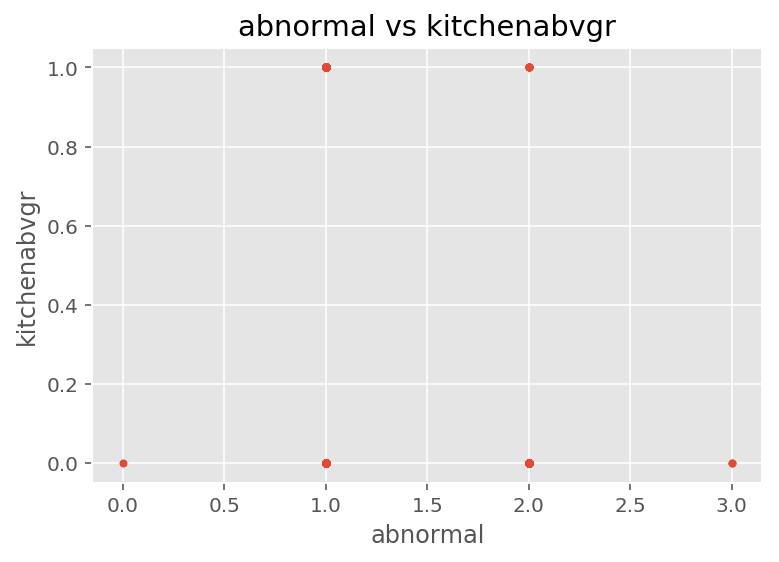

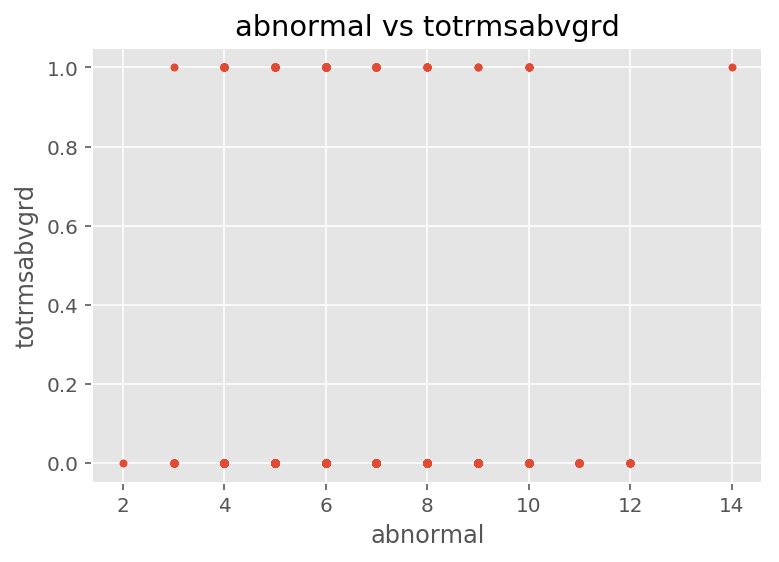

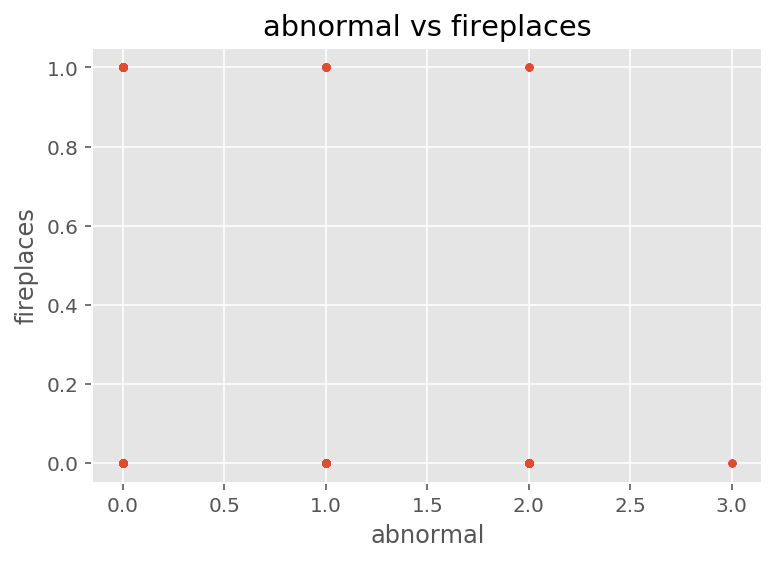

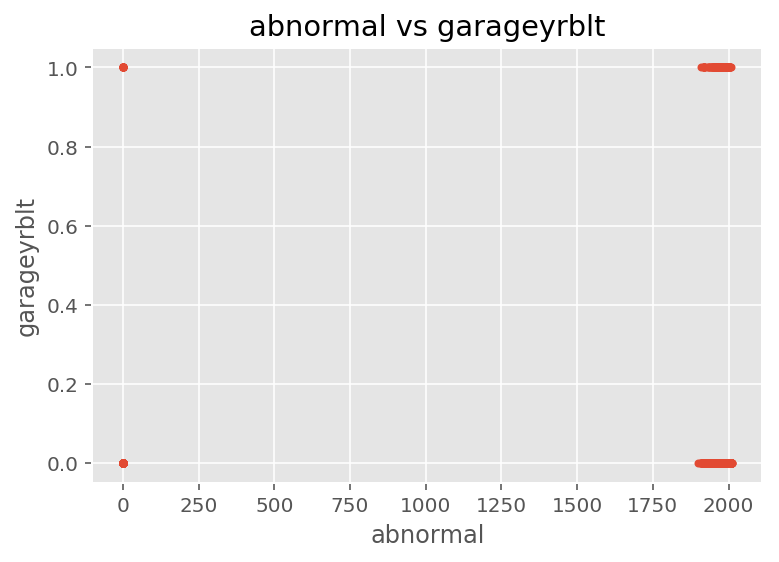

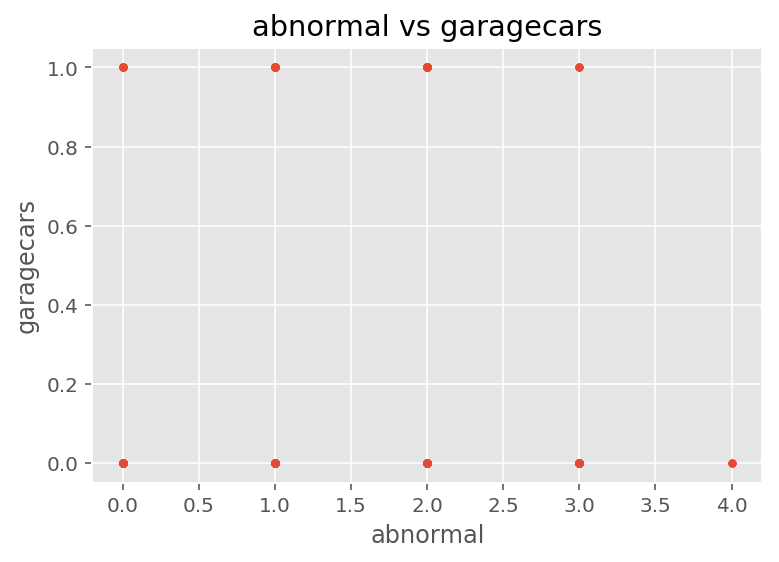

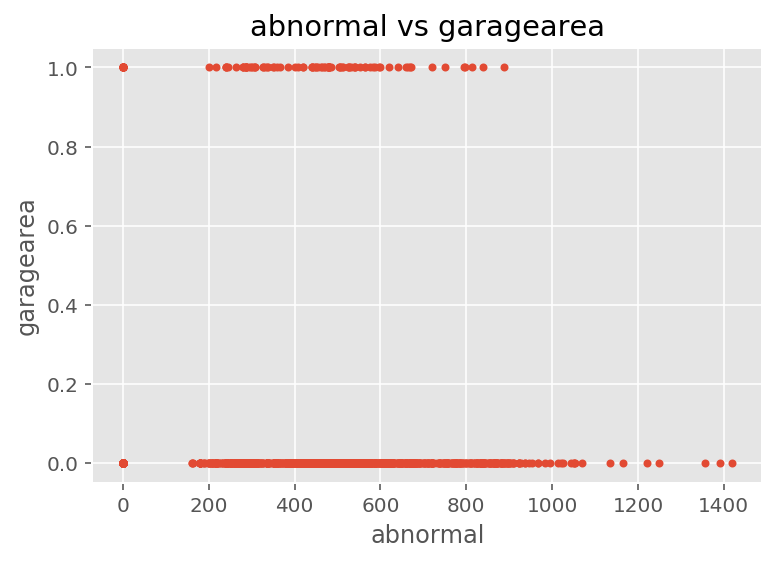

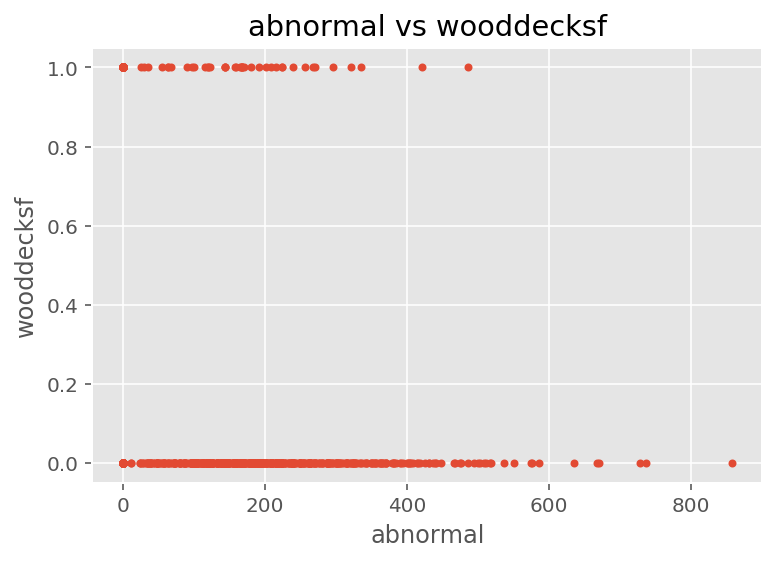

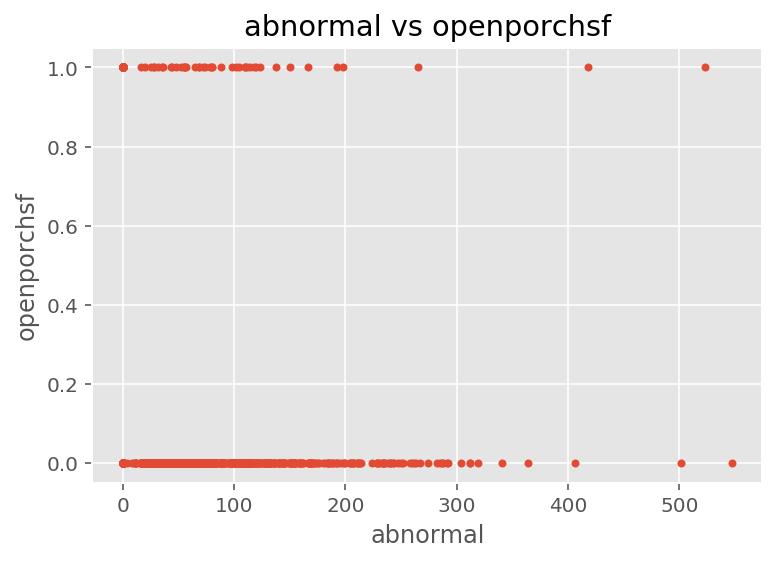

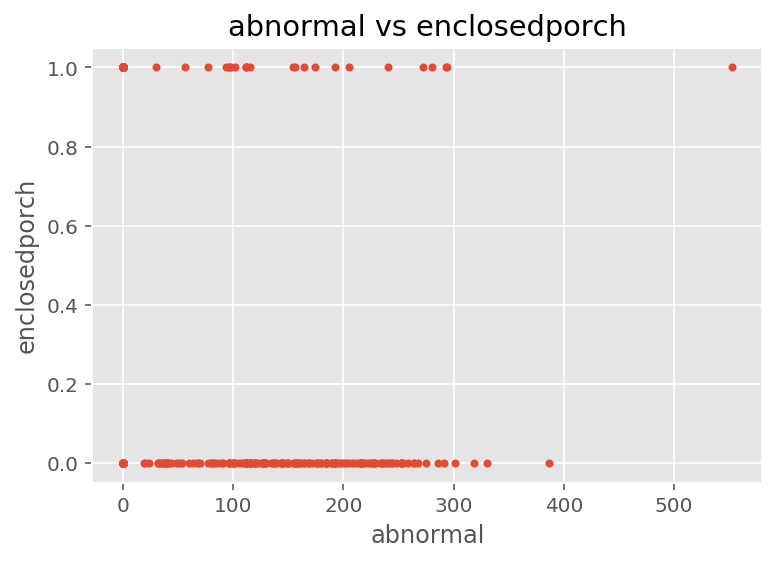

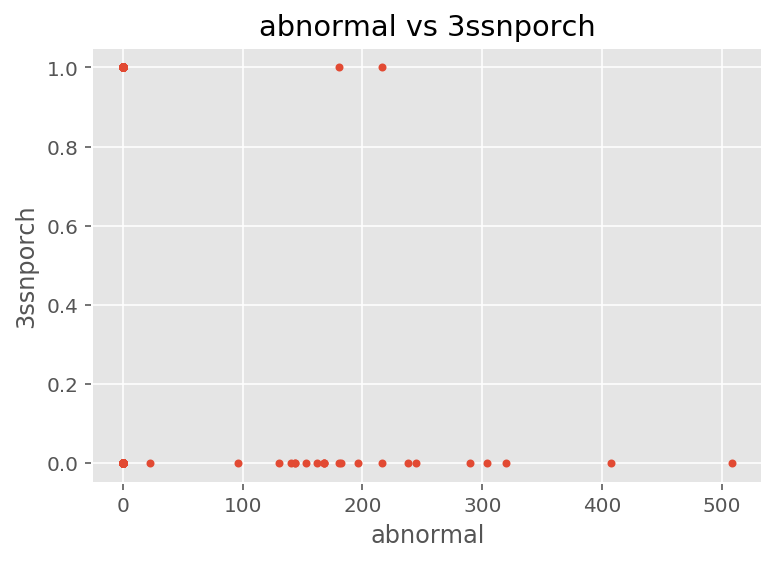

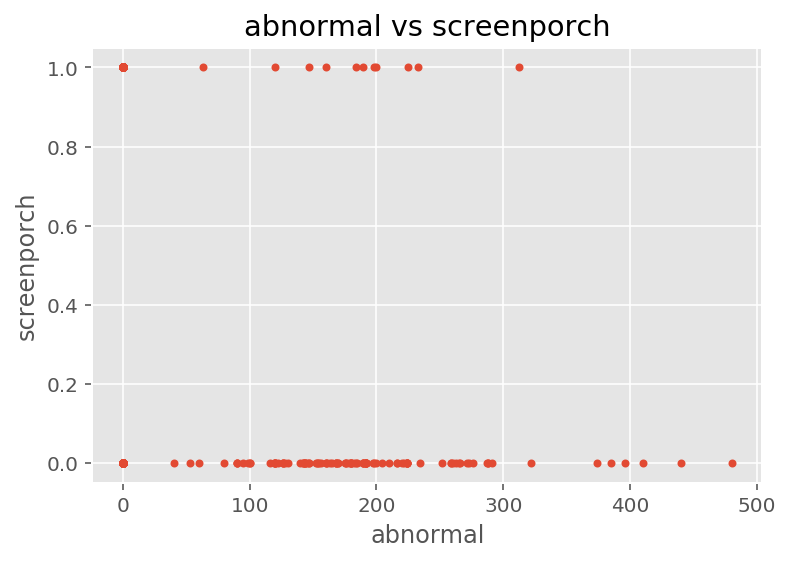

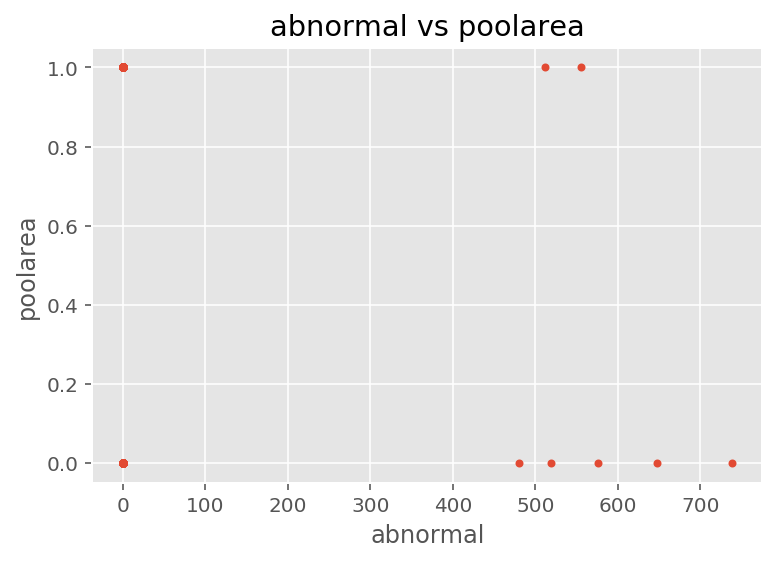

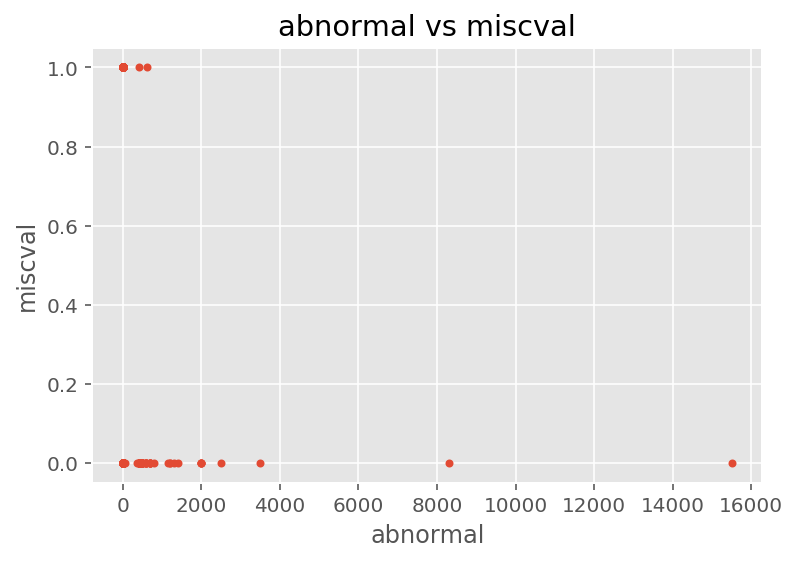

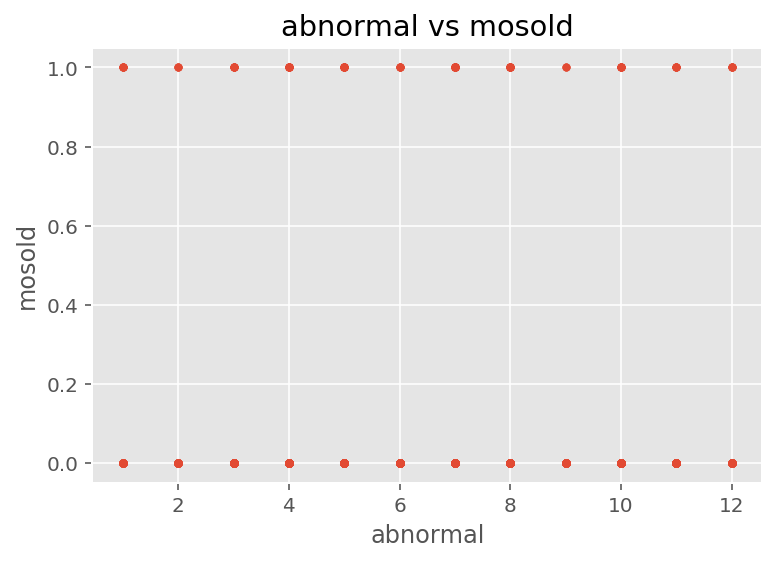

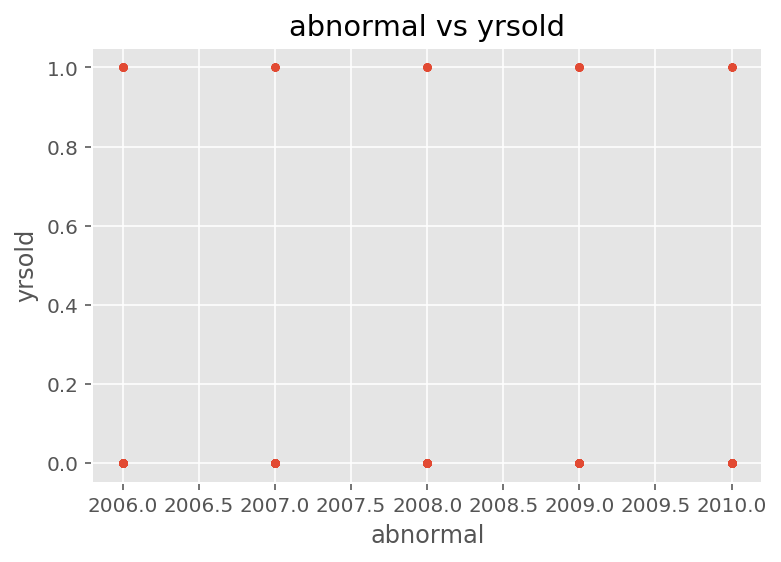

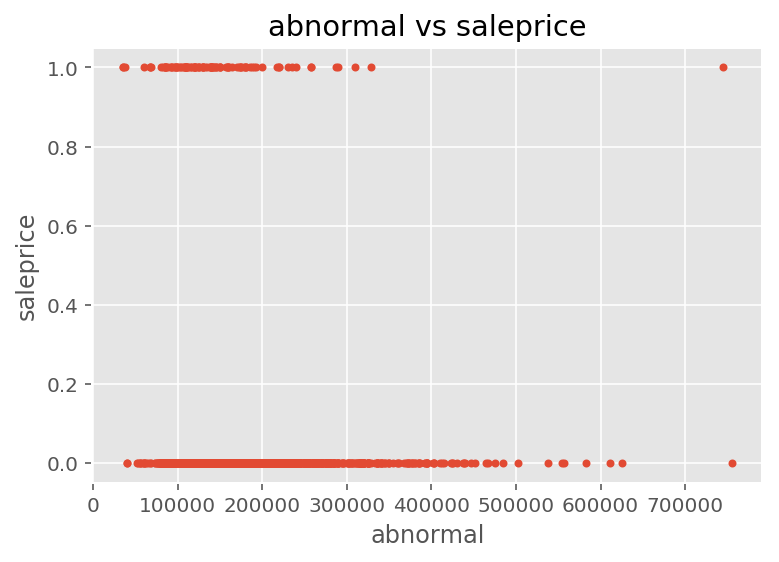

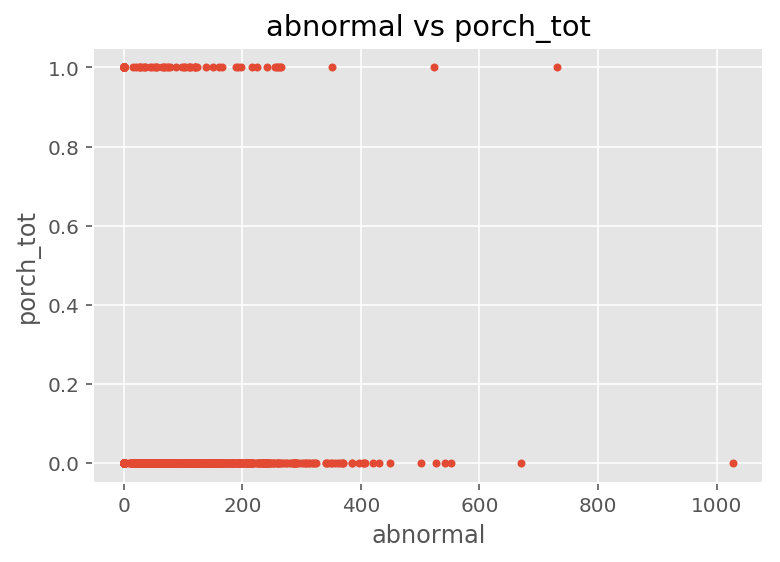

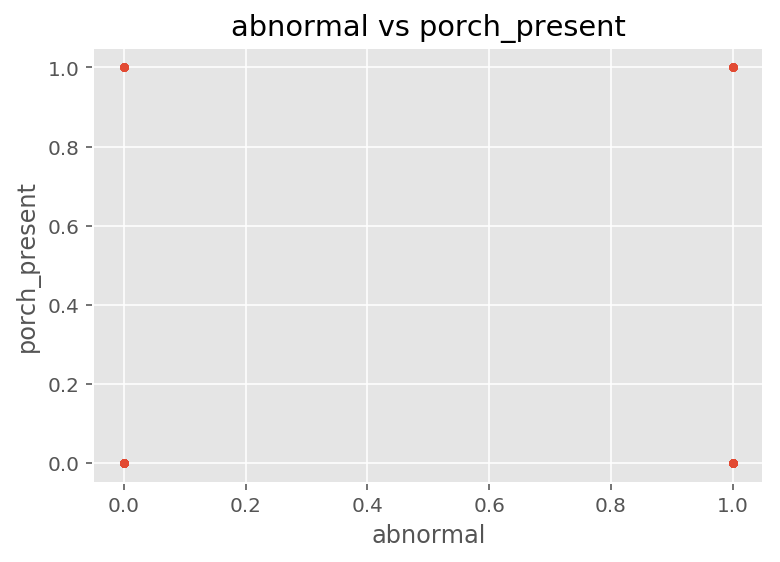

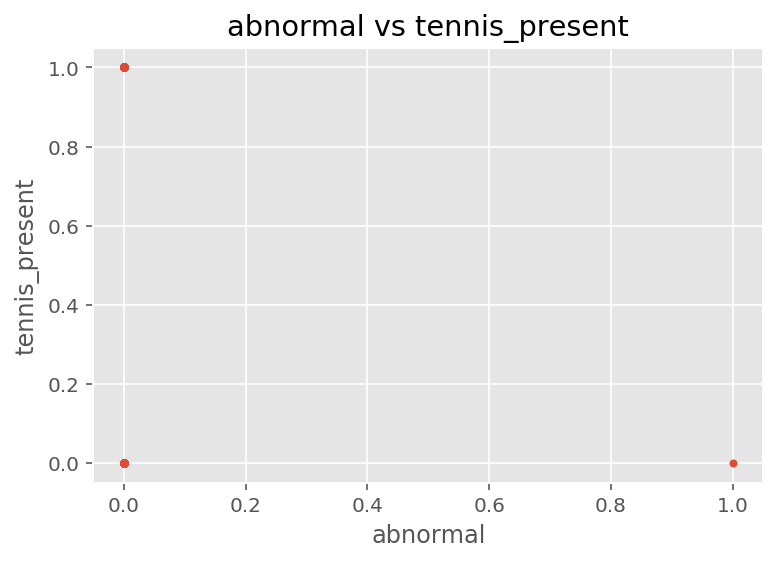

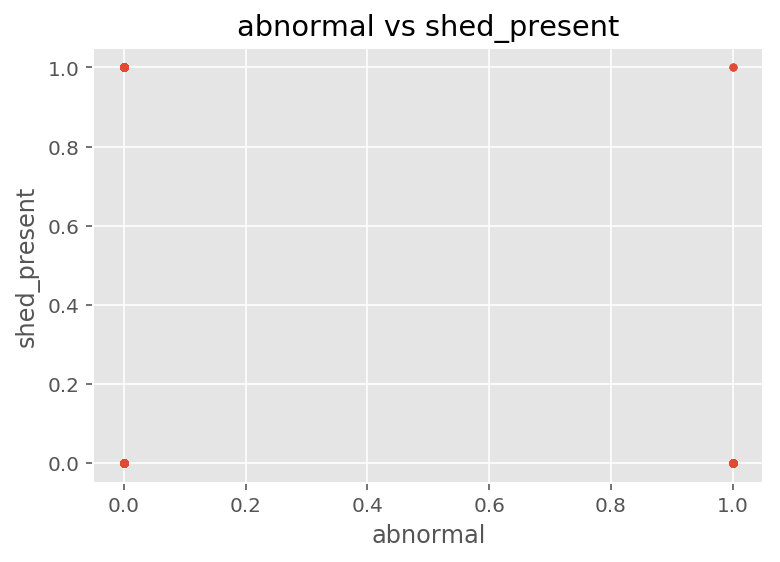

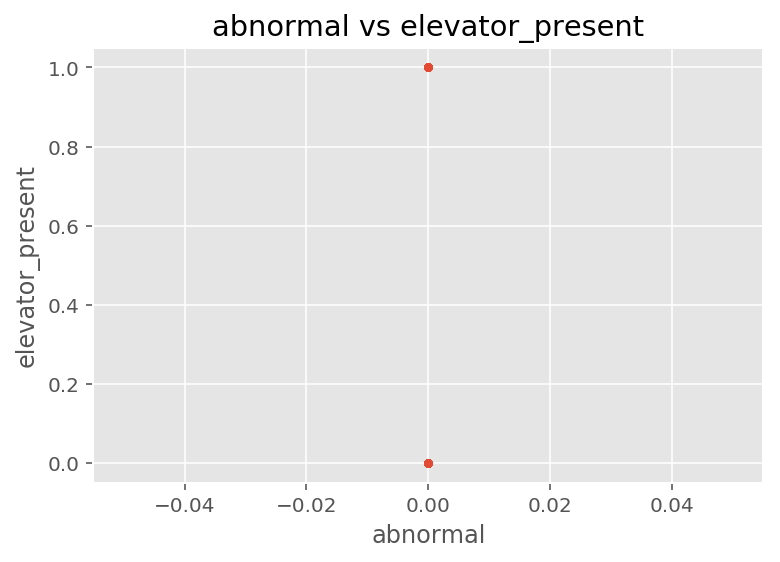

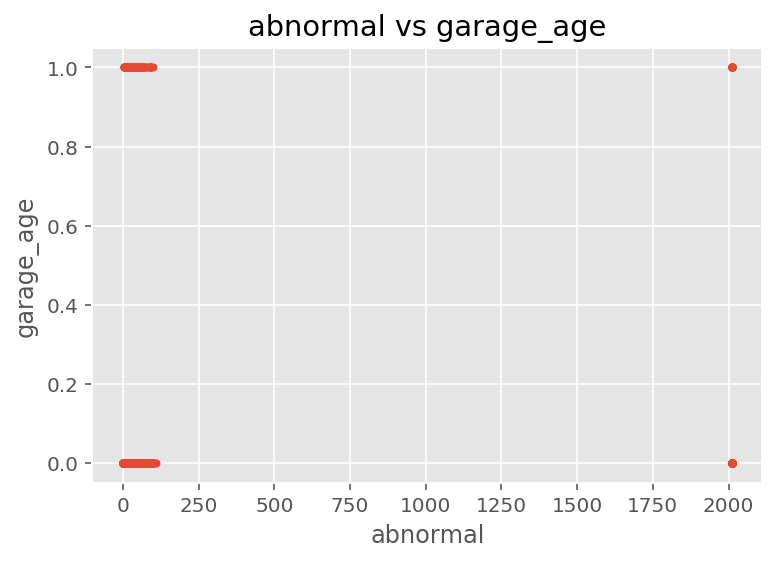

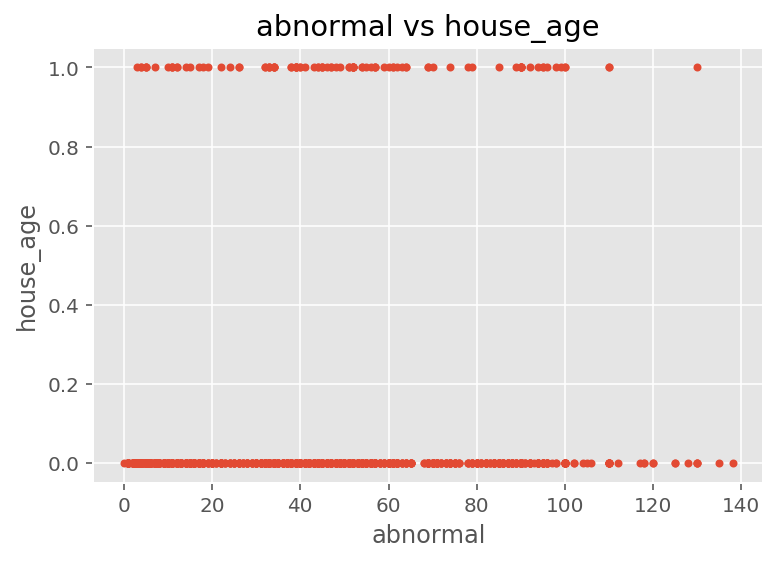

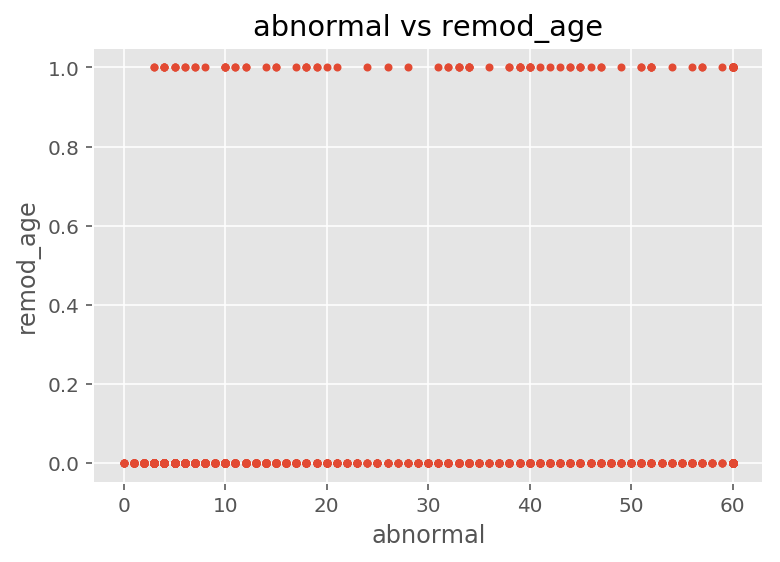

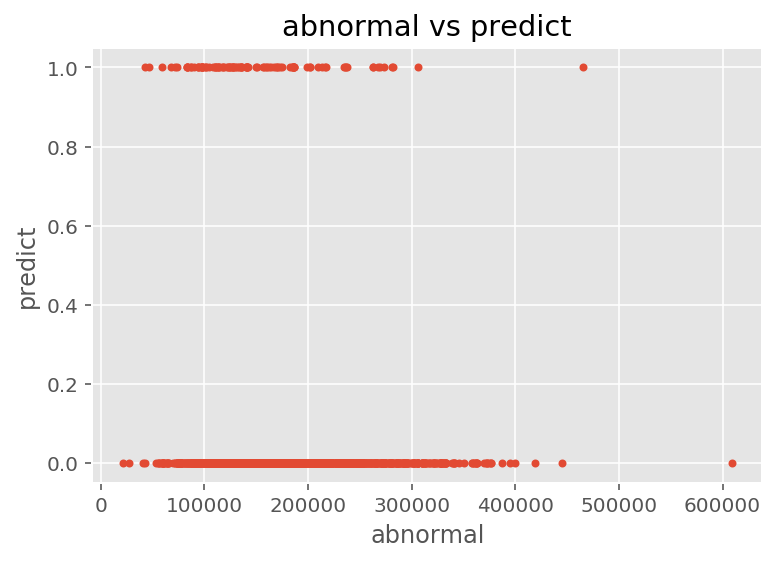

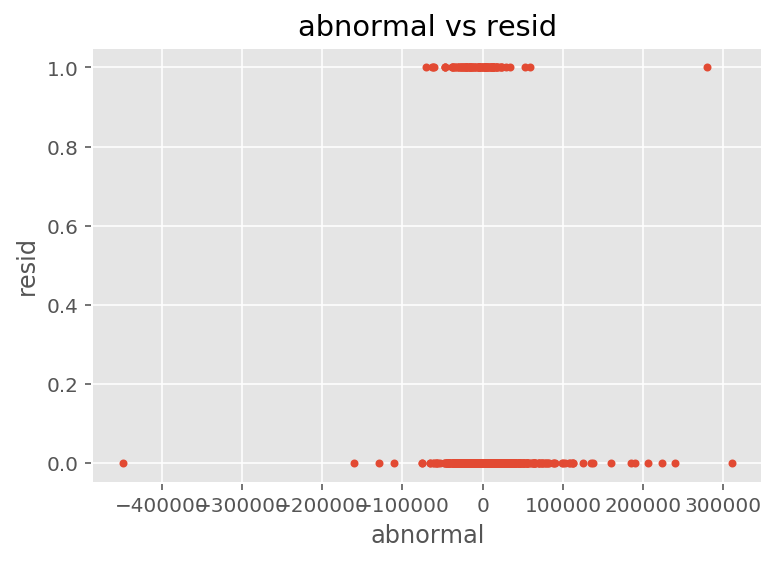

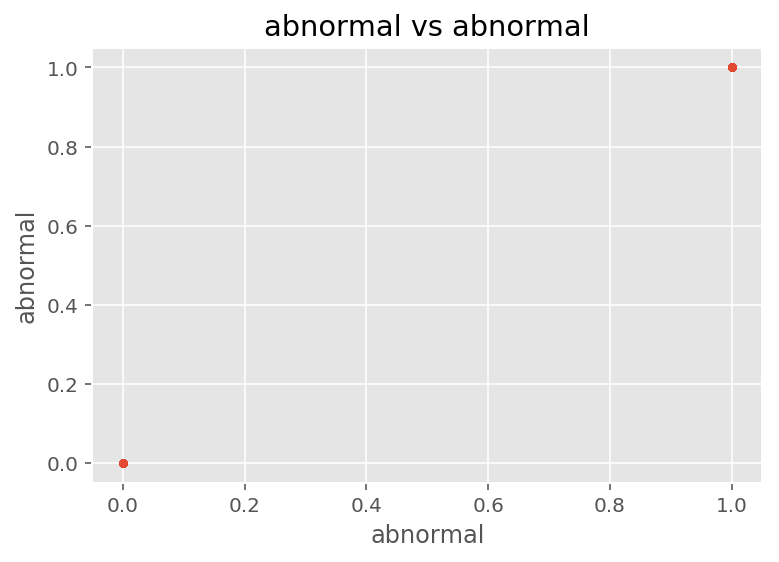

In [551]:
for i in house.columns:
    if house[i].dtypes!='O':
        plt.plot(house[i],house['abnormal'],'.')
        plt.xlabel('abnormal')
        plt.ylabel(i)
        plt.title('abnormal vs ' + i)
        plt.show()

In [553]:
#These are the features I believe will have greatest impact on predicting 
# abnormality, based off plots where it looks like there is difference in classifications
abnormal=house[['lotfrontage', 'lotarea', 'utilities', 'neighborhood', 'condition1',
       'condition2', 'bldgtype', 'housestyle', 'overallqual', 'overallcond',
       'exterqual', 'extercond', 'foundation', 'bsmtcond', 'heatingqc',
       'electrical', 'lowqualfinsf', 'grlivarea', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'garagecond', 'house_age', 'remod_age',
       'abnormal', 'saleprice', 'yrsold']]

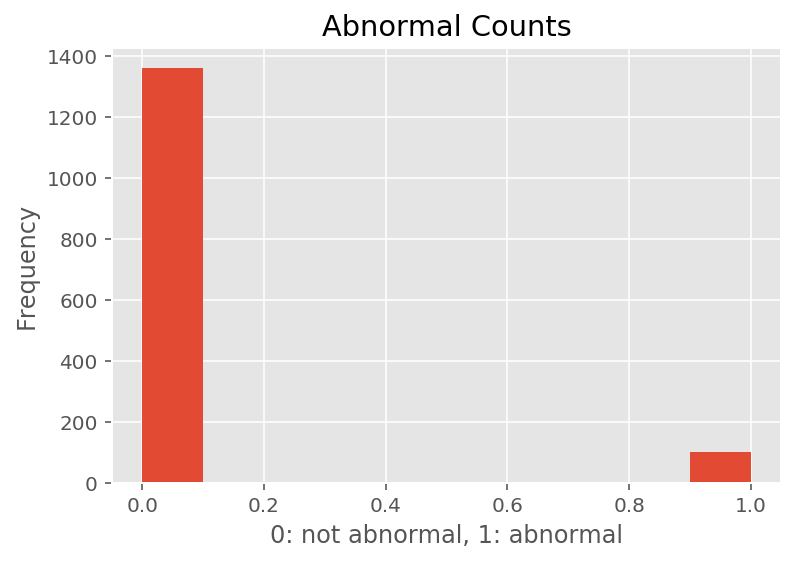

In [555]:
abnormal.abnormal.plot(kind='hist')
plt.title('Abnormal Counts')
plt.xlabel('0: not abnormal, 1: abnormal')
plt.show()

In [556]:
abnormal_X=pd.get_dummies(abnormal)

In [557]:
train=abnormal_X[abnormal_X.yrsold<2010]
test=abnormal_X[abnormal_X.yrsold==2010]
ab_y_train=train.pop('abnormal')
ab_y_test=test.pop('abnormal')

In [558]:
train=train.drop('yrsold',axis=1)
test=test.drop('yrsold',axis=1)

In [559]:
scaler = StandardScaler()
train_std = scaler.fit_transform(train)
test_std=scaler.transform(test)
train_df=pd.DataFrame(train_std,columns=train.columns)
test_df=pd.DataFrame(test_std,columns=test.columns)

In [229]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
lr_dict={
    'penalty':['l1','l2'],
    'C':[1,10,100,1000,10**10],
    'max_iter':[1,10,100,1000],
    'random_state':[0,100,2018],
    'solver':['liblinear']
    
}
lr=LogisticRegression()
lr_gridsearch = GridSearchCV(lr,
                              lr_dict,
                              n_jobs=2, 
                              cv=5, 
                              verbose=1, 
                              return_train_score=True)

lr_gridsearch.fit(train_df, ab_y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 291 tasks      | elapsed:   15.0s
[Parallel(n_jobs=2)]: Done 600 out of 600 | elapsed: 21.4min finished
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=2,
             param_grid={'C': [1, 10, 100, 1000, 10000000000],
                         'max_iter': [1, 10, 100, 1000],
                         'penalty': ['l1', 'l2'],
                         'random_state': [0, 100, 2018],
                         'solver': ['liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score

In [232]:
lr_gridsearch.best_params_

{'C': 1,
 'max_iter': 1,
 'penalty': 'l1',
 'random_state': 0,
 'solver': 'liblinear'}

In [233]:
lr_gridsearch.best_score_

0.9268482490272374

In [234]:
best_lr=lr_gridsearch.best_estimator_

In [278]:
#Find baseline estimate
baseline=house.abnormal.value_counts(normalize=True)
baseline.max()

0.9308219178082192

In [725]:
print('Baseline Accuracy: ' + str(baseline.max()))
print('Train Accuracy: ' +str(best_lr.score(train_df,ab_y_train)))
print('Test Accuracy: ' +str(best_lr.score(test_df,ab_y_test)))

Baseline Accuracy: 0.9308219178082192
Train Accuracy: 0.932295719844358
Test Accuracy: 0.9371428571428572


Model not much better than baseline, check confusion matrix

In [580]:
predictions_train=best_lr.predict(train_df)
predictions_test=best_lr.predict(test_df)
probabilities=best_lr.predict_proba(test_df)

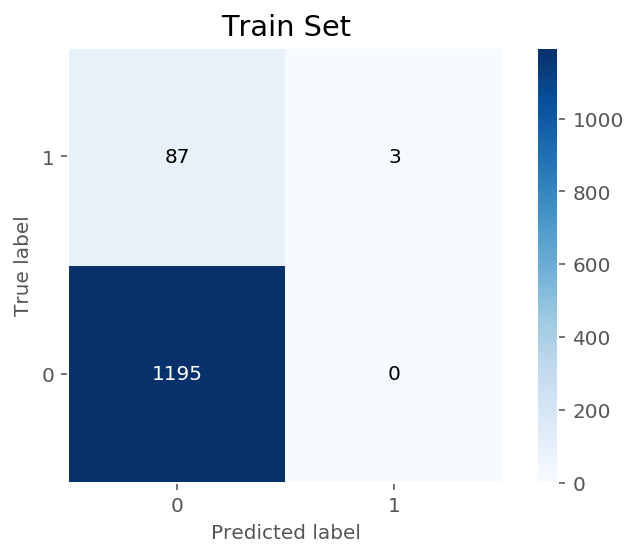

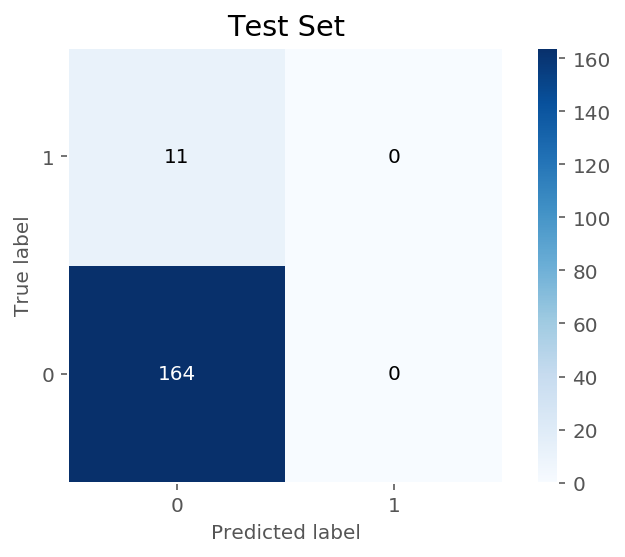

In [581]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
skplt.metrics.plot_confusion_matrix(ab_y_train, predictions_train)
plt.ylim([-0.5, len(ab_y_train.unique())-0.5])
plt.title('Train Set')
plt.show()
skplt.metrics.plot_confusion_matrix(ab_y_test, predictions_test)
plt.ylim([-0.5, len(ab_y_test.unique())-0.5])
plt.title('Test Set')
plt.show()

In [590]:
print('Train')
print(classification_report(ab_y_train,predictions_train))
print('Test')
print(classification_report(ab_y_test,predictions_test))

Train
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1195
           1       1.00      0.03      0.06        90

    accuracy                           0.93      1285
   macro avg       0.97      0.52      0.51      1285
weighted avg       0.94      0.93      0.90      1285

Test
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       164
           1       0.00      0.00      0.00        11

    accuracy                           0.94       175
   macro avg       0.47      0.50      0.48       175
weighted avg       0.88      0.94      0.91       175



/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [565]:
def plot_f1_lines(figsize=(8,6),fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)
    
    # add lines of constant F1 scores
    
    for const in np.linspace(0.2,0.9,8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                 color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                     xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

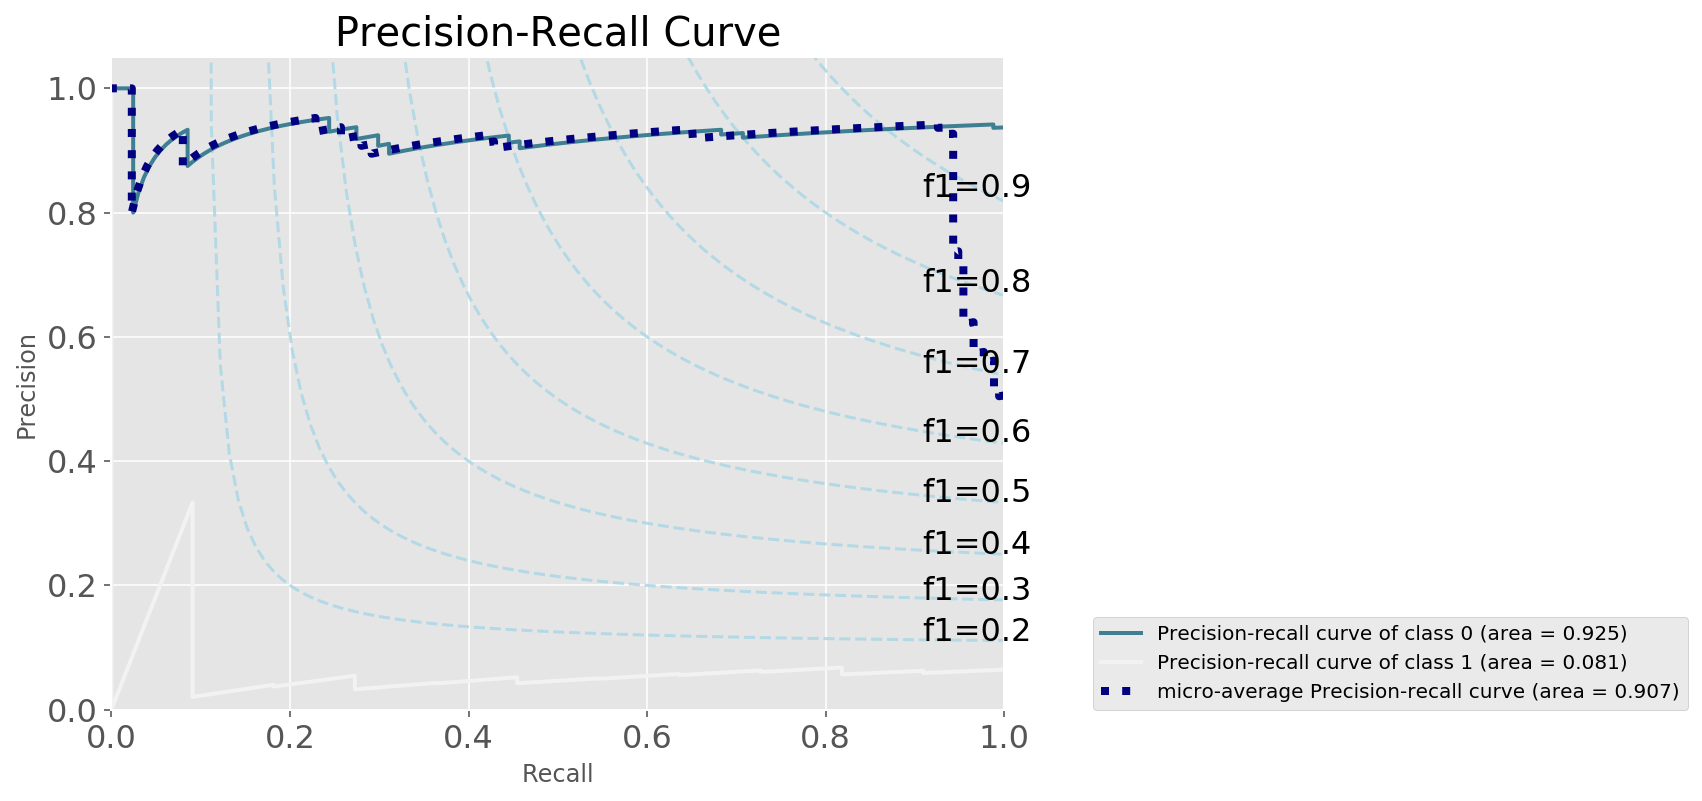

In [566]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(ab_y_test, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

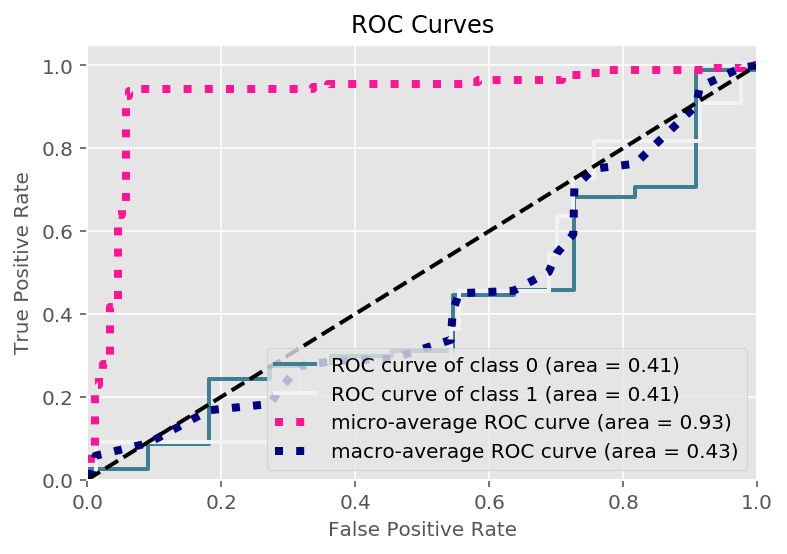

In [567]:
skplt.metrics.plot_roc(ab_y_test, probabilities, cmap=cmap)
plt.show()

Model is failing to predict any True Positives, therefore is poor model. Will try KNN approach instead

In [569]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [324]:
knn_dict={
    'n_neighbors':[1,10,20,50,100,130],
    'weights':['uniform','distance'],
    'algorithm':['ball_tree','kd_tree','brute'],
    'p':[1,2],
    
}
knn = KNeighborsClassifier()
knn_gridsearch = GridSearchCV(knn,
                              knn_dict,
                              n_jobs=2, 
                              cv=5, 
                              verbose=1, 
                              return_train_score=True)

knn_gridsearch.fit(train_df, ab_y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   28.5s
[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed:   44.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=2,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 10, 20, 50, 100, 130], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

In [570]:
knn_gridsearch.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}

In [726]:
best_knn=knn_gridsearch.best_estimator_
print('Baseline Accuracy: ' + str(baseline.max()))
print('Train Accuracy: ' +str(best_knn.score(train_df,ab_y_train)))
print('Test Accuracy: ' +str(best_knn.score(test_df,ab_y_test)))
predictions_knn_test=best_knn.predict(test_df)
predictions_knn_train=best_knn.predict(train_df)

Baseline Accuracy: 0.9308219178082192
Train Accuracy: 0.9299610894941635
Test Accuracy: 0.9371428571428572


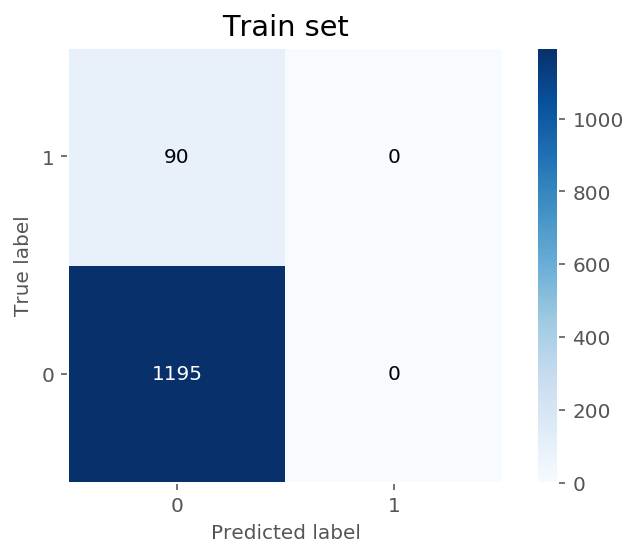

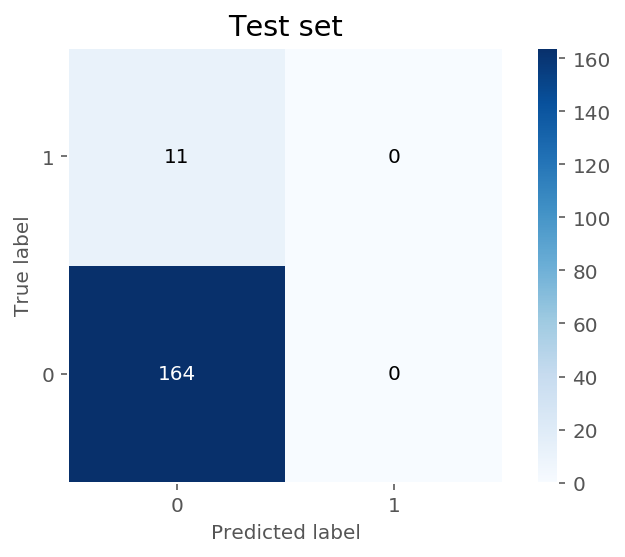

In [584]:
skplt.metrics.plot_confusion_matrix(ab_y_train, predictions_knn_train)
plt.ylim([-0.5, len(ab_y_test.unique())-0.5])
plt.title('Train set')
plt.show()
skplt.metrics.plot_confusion_matrix(ab_y_test, predictions_knn_test)
plt.ylim([-0.5, len(ab_y_test.unique())-0.5])
plt.title('Test set')
plt.show()

KNN is no better and still predicting no True Positives. 

I read an article online which suggested resampling the training dataset such that there is an even number of successes and failures. This will duplicate observations from the abnormal class so to make it easier for the model to pick them up.

In [286]:
from sklearn.utils import resample

In [339]:
X = pd.concat([train, ab_y_train], axis=1)
not_abnormal = X[X.abnormal==0]
abnormal_is = X[X.abnormal==1]
abnormal_upsampled = resample(abnormal_is,
                          replace=True, # sample with replacement
                          n_samples=len(not_abnormal), # match number in majority class
                          random_state=27) # reproducible results
upsampled = pd.concat([not_abnormal, abnormal_upsampled])

In [340]:
new_y_train = upsampled.abnormal
new_train_df = upsampled.drop('abnormal', axis=1)

In [704]:
upsampled_lr = LogisticRegression(solver='liblinear',multi_class='ovr').fit(new_train_df, new_y_train)

In [705]:
print('Baseline Accuracy: ' + str(baseline.max()))
print('Train Accuracy: ' + str(upsampled_lr.score(new_train_df,new_y_train)))
print('Test Accuracy: ' + str(upsampled_lr.score(test,ab_y_test)))

Baseline Accuracy: 0.9308219178082192
Train Accuracy: 0.6435146443514644
Test Accuracy: 0.6342857142857142


The accuracy for the model has dropped, but checking the confusion matrix below you can see recall and precision have increased for abnormal class

In [669]:
predictions_up_train=upsampled_lr.predict(new_train_df)
predictions_up_test=upsampled_lr.predict(test)
probabilities_up=upsampled_lr.predict_proba(test)

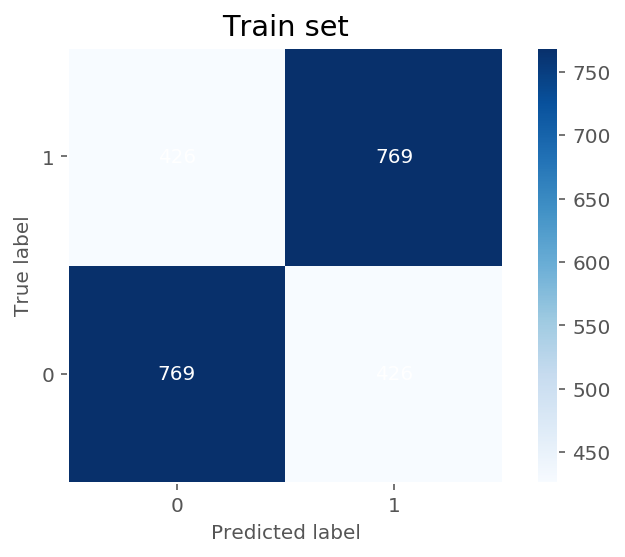

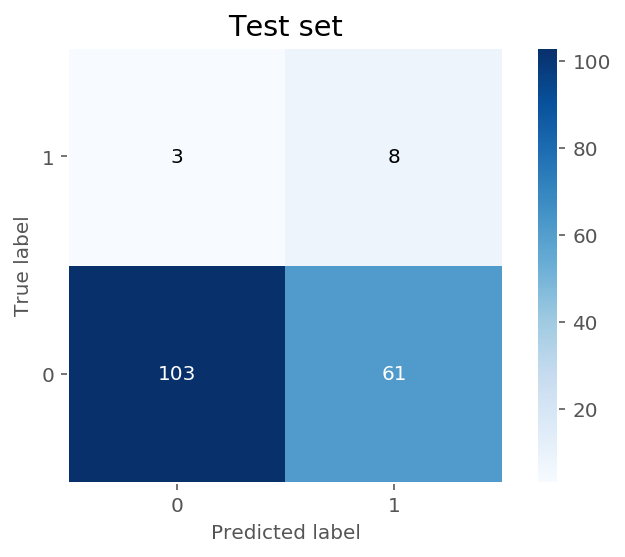

In [671]:
skplt.metrics.plot_confusion_matrix(new_y_train, predictions_up_train)
plt.ylim([-0.5, len(ab_y_test.unique())-0.5])
plt.title('Train set')
plt.show()
skplt.metrics.plot_confusion_matrix(ab_y_test, predictions_up_test)
plt.ylim([-0.5, len(ab_y_test.unique())-0.5])
plt.title('Test set')
plt.show()

In [589]:
print('Test')
print(classification_report(ab_y_train,predictions_up_train))
print('Train')
print(classification_report(ab_y_test,predictions_up_test))

Test
              precision    recall  f1-score   support

           0       0.96      0.64      0.77      1195
           1       0.12      0.63      0.20        90

    accuracy                           0.64      1285
   macro avg       0.54      0.64      0.48      1285
weighted avg       0.90      0.64      0.73      1285

Train
              precision    recall  f1-score   support

           0       0.97      0.63      0.76       164
           1       0.12      0.73      0.20        11

    accuracy                           0.63       175
   macro avg       0.54      0.68      0.48       175
weighted avg       0.92      0.63      0.73       175



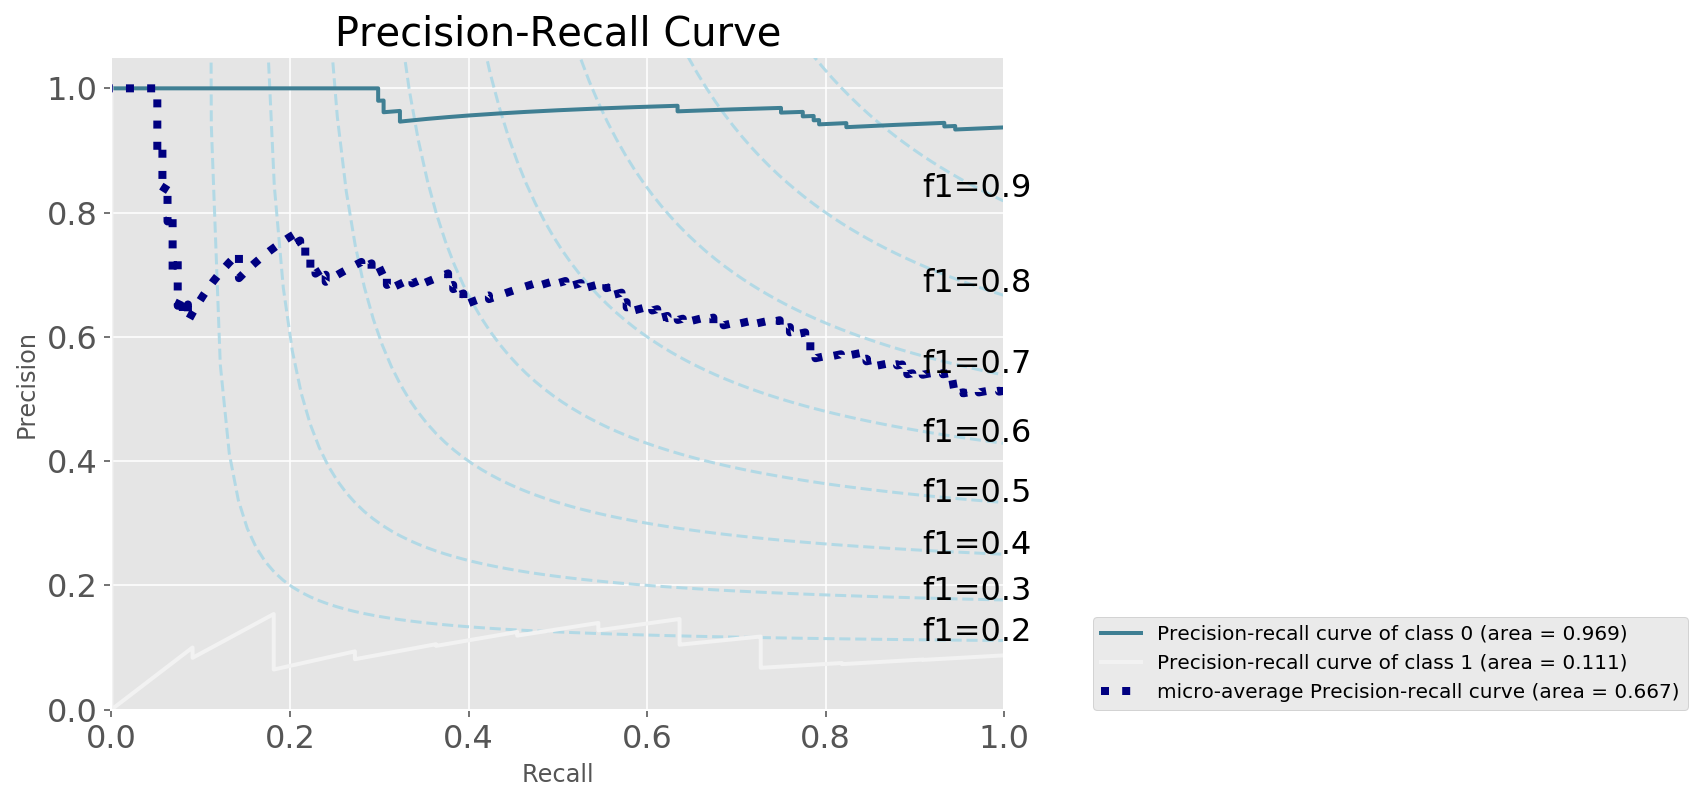

In [364]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(ab_y_test, probabilities_up, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

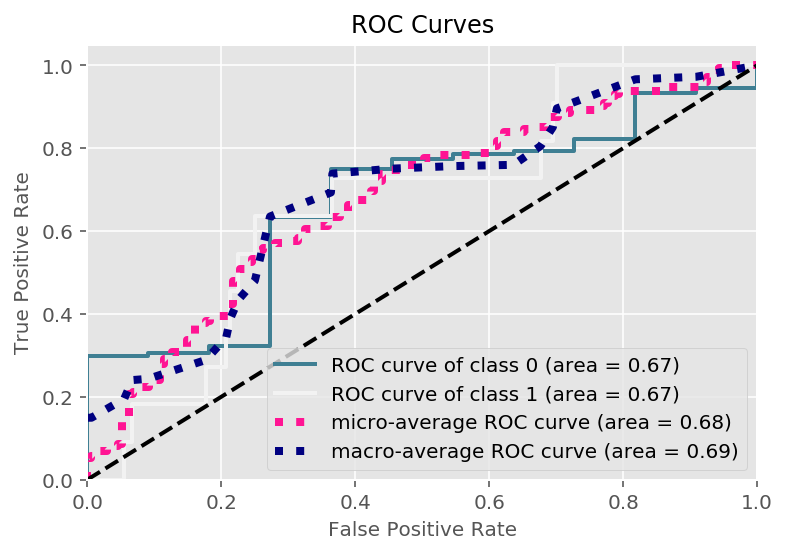

In [349]:
skplt.metrics.plot_roc(ab_y_test, probabilities_up, cmap=cmap)
plt.show()

The model is now more accurately predicting abnormal sales, but is also falsely caling normal sales abnormal. Now I will try downsampling, so removing the effect of the dominant class

In [354]:
not_abnormal_downsampled = resample(not_abnormal,
                                replace = False, # sample without replacement
                                n_samples = len(abnormal_is), # match minority n
                                random_state = 27) # reproducible results

In [355]:
downsampled = pd.concat([not_abnormal_downsampled, abnormal_is])

In [356]:
n_y_train = upsampled.abnormal
n_train_df = upsampled.drop('abnormal', axis=1)

In [431]:
downsampled_lr = LogisticRegression(solver='liblinear',multi_class='ovr').fit(n_train_df, n_y_train)

In [727]:
print('Baseline Accuracy: ' + str(baseline.max()))
print('Train Accuracy: ' + str(downsampled_lr.score(train,ab_y_train)))
print('Test Accuracy: ' + str(downsampled_lr.score(test,ab_y_test)))

Baseline Accuracy: 0.9308219178082192
Train Accuracy: 0.6428015564202335
Test Accuracy: 0.6342857142857142


In [591]:
predictions_dn_train=downsampled_lr.predict(train)
predictions_dn_test=downsampled_lr.predict(test)
probabilities_dn=downsampled_lr.predict_proba(test)

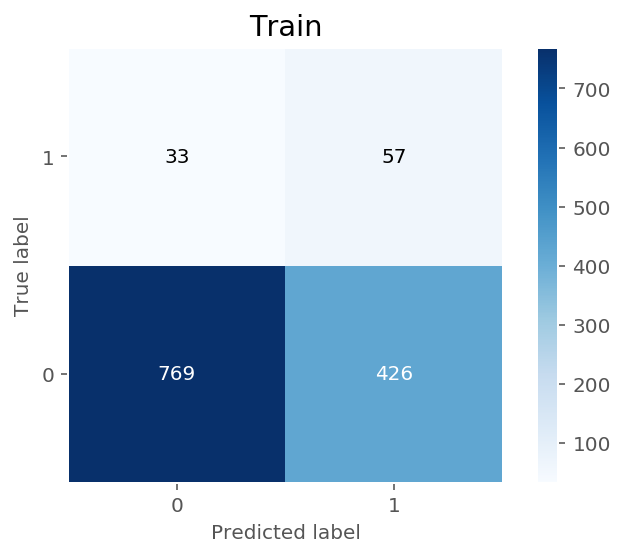

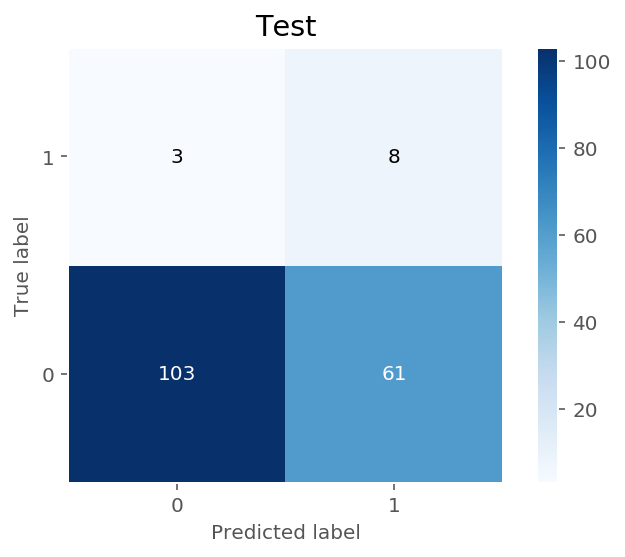

In [593]:
skplt.metrics.plot_confusion_matrix(ab_y_train, predictions_dn_train)
plt.ylim([-0.5, len(ab_y_test.unique())-0.5])
plt.title('Train')
plt.show()
skplt.metrics.plot_confusion_matrix(ab_y_test, predictions_dn_test)
plt.ylim([-0.5, len(ab_y_test.unique())-0.5])
plt.title('Test')
plt.show()

In [594]:
print('Train')
print(classification_report(ab_y_train,predictions_dn_train))
print('Test')
print(classification_report(ab_y_test,predictions_dn_test))

Train
              precision    recall  f1-score   support

           0       0.96      0.64      0.77      1195
           1       0.12      0.63      0.20        90

    accuracy                           0.64      1285
   macro avg       0.54      0.64      0.48      1285
weighted avg       0.90      0.64      0.73      1285

Test
              precision    recall  f1-score   support

           0       0.97      0.63      0.76       164
           1       0.12      0.73      0.20        11

    accuracy                           0.63       175
   macro avg       0.54      0.68      0.48       175
weighted avg       0.92      0.63      0.73       175



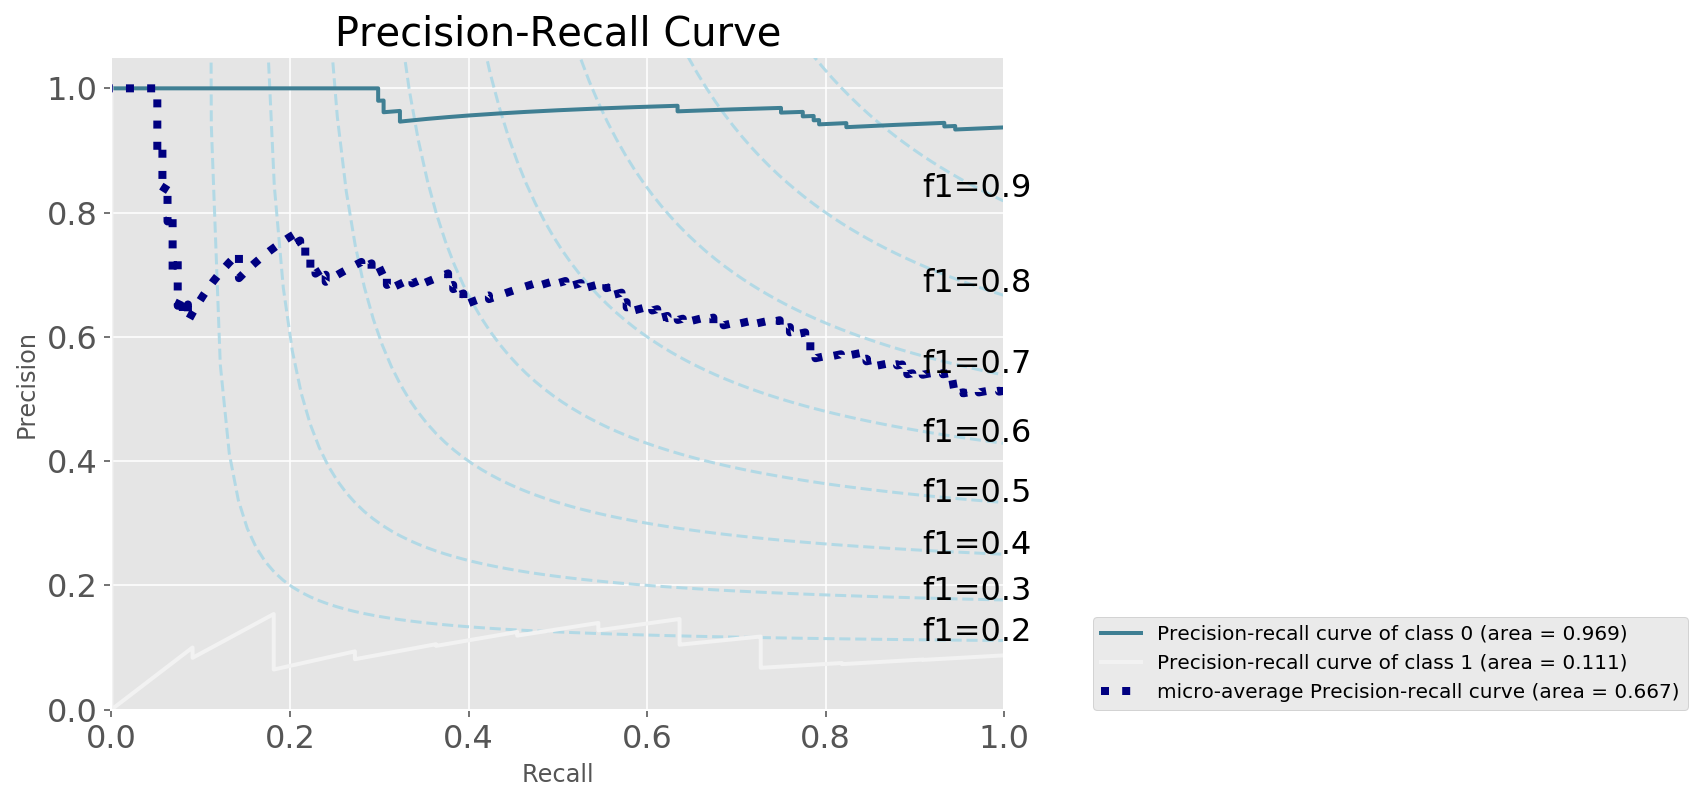

In [365]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(ab_y_test, probabilities_dn, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

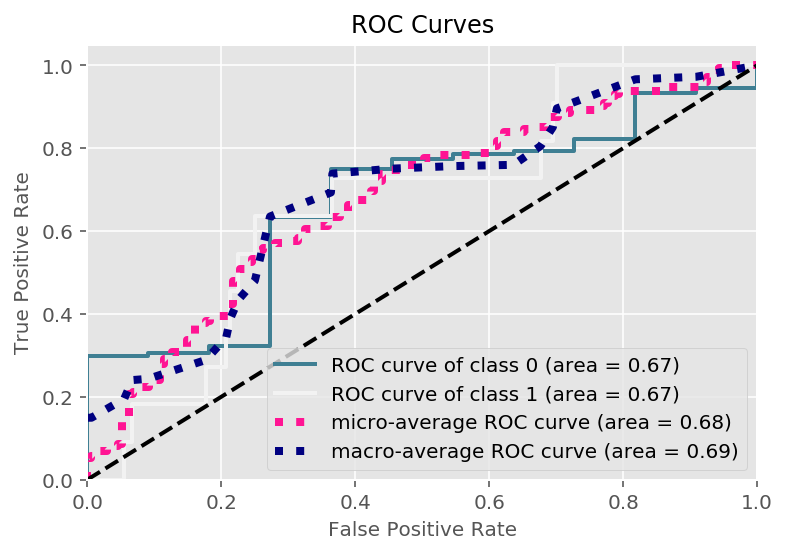

In [363]:
skplt.metrics.plot_roc(ab_y_test, probabilities_dn, cmap=cmap)
plt.show()

Downsampling and upsampling have the same effect, better recision and recall but worse accuracy. What about changing the threshold?

Given that upsampling/downsampling provided better precision and recall I will change the threshold on these. As they had the same effect, I have chose the upsampling model.

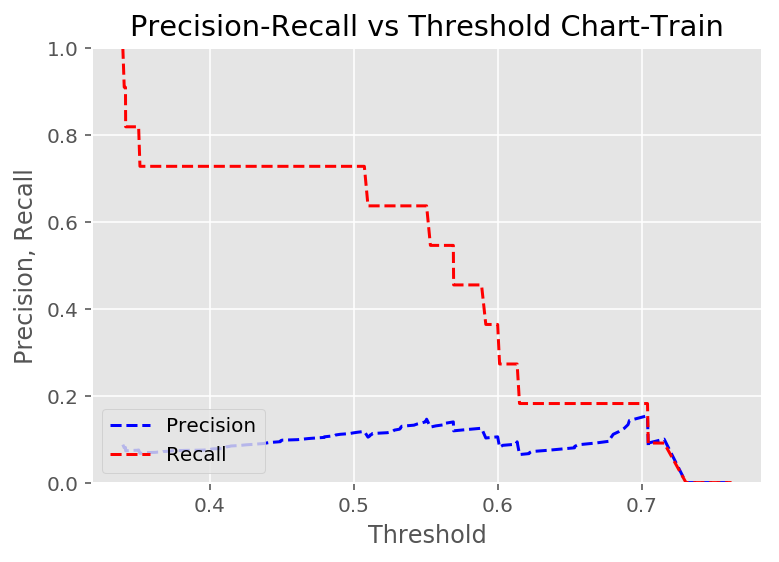

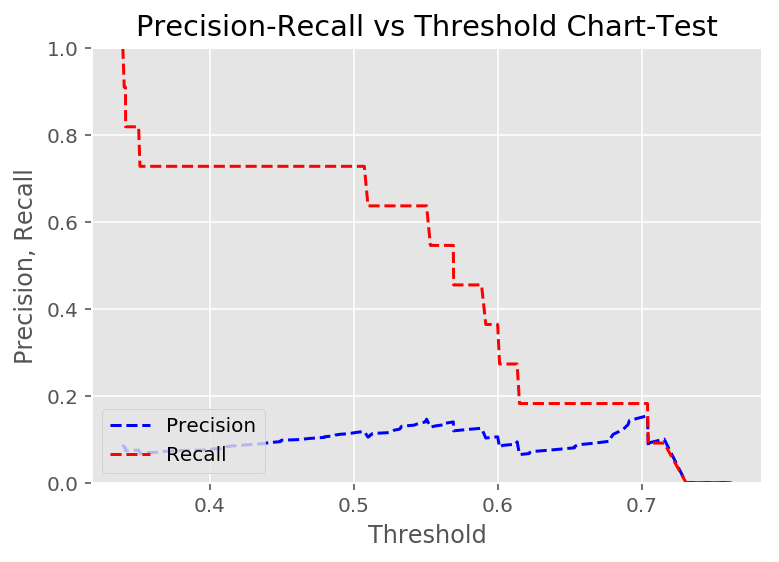

In [599]:
pred_y_test=upsampled_lr.predict(test) 
pred_y_train=upsampled_lr.predict(train) 
probs_y_test=upsampled_lr.predict_proba(test) 
probs_y_train=upsampled_lr.predict_proba(train) 


from sklearn.metrics import precision_recall_curve
precision_train, recall_train,thresholds_train= precision_recall_curve(ab_y_test, probs_y[:, 
1]) 
precision_test, recall_test,thresholds_test = precision_recall_curve(ab_y_test, probs_y[:, 
1]) 

plt.title("Precision-Recall vs Threshold Chart-Train")
plt.plot(thresholds_train, precision_train[: -1], "b--", label="Precision")
plt.plot(thresholds_train, recall_train[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.show()
plt.title("Precision-Recall vs Threshold Chart-Test")
plt.plot(thresholds_test, precision_test[: -1], "b--", label="Precision")
plt.plot(thresholds_test, recall_test[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.show()

In [595]:
Y_pp_train = pd.DataFrame(upsampled_lr.predict_proba(train_df), 
             columns=['class_0_pp', 'class_1_pp'])
Y_pp_test = pd.DataFrame(upsampled_lr.predict_proba(test_df), 
             columns=['class_0_pp', 'class_1_pp'])

In [404]:
def predict_at_threshold(x, threshold=0.5):
    if x >= threshold:
        return 1
    else:
        return 0

In [607]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def scores_at_thresholds(probs,y):
    predictions = [probs.apply(predict_at_threshold, threshold=i) 
                   for i in np.linspace(0, 1, 1000)]
    scores = np.array(
    [(threshold, 
      accuracy_score(y, predictions[i]),
      precision_score(y, predictions[i]),
      recall_score(y, predictions[i]), 
      f1_score(y, predictions[i])) 
     for i, threshold in enumerate(np.linspace(0, 1, 1000))])
    return scores

In [609]:
scores_test = scores_at_thresholds(Y_pp_test.class_1_pp,ab_y_test)
scores_train = scores_at_thresholds(Y_pp_train.class_1_pp,ab_y_train)

/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


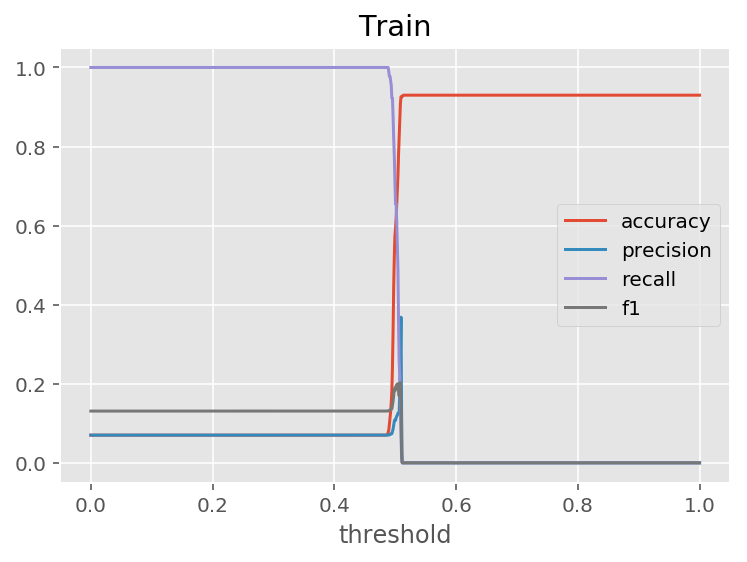

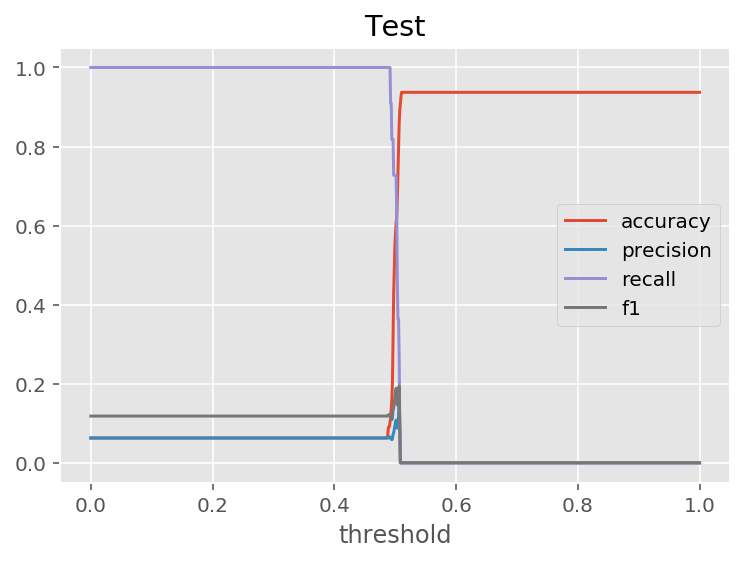

In [610]:
plt.plot(scores_train[:, 0], scores_train[:, 1], label='accuracy')
plt.plot(scores_train[:, 0], scores_train[:, 2], label='precision')
plt.plot(scores_train[:, 0], scores_train[:, 3], label='recall')
plt.plot(scores_train[:, 0], scores_train[:, 4], label='f1')
plt.legend()
plt.xlabel('threshold')
plt.title('Train')
plt.show()
plt.plot(scores_test[:, 0], scores_test[:, 1], label='accuracy')
plt.plot(scores_test[:, 0], scores_test[:, 2], label='precision')
plt.plot(scores_test[:, 0], scores_test[:, 3], label='recall')
plt.plot(scores_test[:, 0], scores_test[:, 4], label='f1')
plt.legend()
plt.xlabel('threshold')
plt.title('Test')
plt.show()

The diagram above suggest that the ideal threshold is around 0.5. I checked several other thresholds and found that a threshold of 0.48 does improve the model slightly by giving 100% on recall

In [616]:
Y_pp_train['pred_class_thresh_48'] = Y_pp_train.class_1_pp.apply(predict_at_threshold, 
                                                threshold=0.48)
Y_pp_test['pred_class_thresh_48'] = Y_pp_test.class_1_pp.apply(predict_at_threshold, 
                                                threshold=0.48)

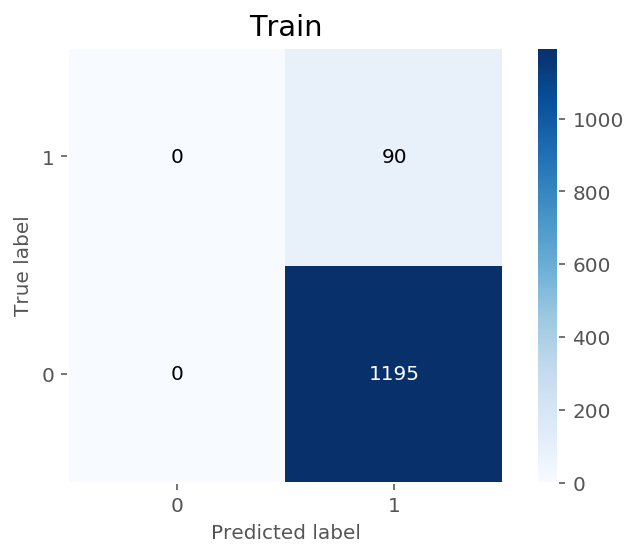

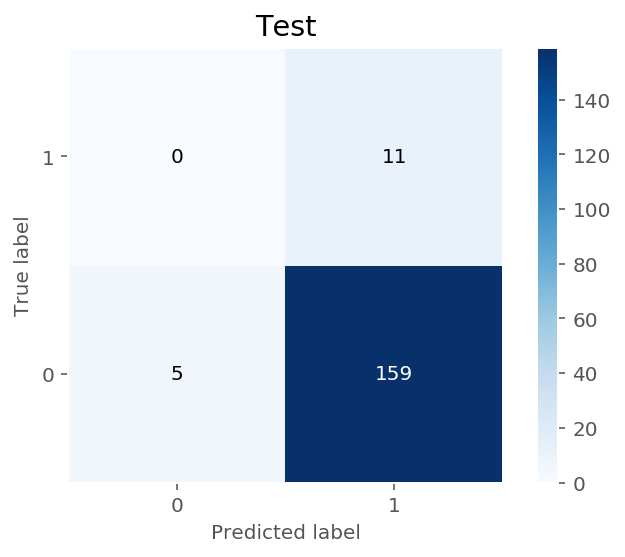

In [617]:
skplt.metrics.plot_confusion_matrix(ab_y_train, Y_pp_train.pred_class_thresh_49)
plt.ylim([-0.5, len(ab_y_test.unique())-0.5])
plt.title('Train')
plt.show()
skplt.metrics.plot_confusion_matrix(ab_y_test, Y_pp_test.pred_class_thresh_49)
plt.ylim([-0.5, len(ab_y_test.unique())-0.5])
plt.title('Test')
plt.show()

In [619]:
print('Train')
print(classification_report(ab_y_train,Y_pp_train.pred_class_thresh_48))
print('Test')
print(classification_report(ab_y_test,Y_pp_test.pred_class_thresh_48))

Train
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1195
           1       0.07      1.00      0.13        90

    accuracy                           0.07      1285
   macro avg       0.04      0.50      0.07      1285
weighted avg       0.00      0.07      0.01      1285

Test
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       164
           1       0.06      1.00      0.12        11

    accuracy                           0.06       175
   macro avg       0.03      0.50      0.06       175
weighted avg       0.00      0.06      0.01       175



/Users/alastairtyson/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The model know has a recall of 100%. This means we can correctly predict an abnormal sale. However, we are also getting many more non-abnormal sales (low precision) so our model sill isn't great

Other people have suggested using a random forest classifier. As we haven't learned much about it yet I have included it but with not much analysis 

clf_4 = RandomForestClassifier()
clf_4.fit(train, ab_y_train)

In [622]:
print('Baseline: ' + str(baseline.max()))
print('Train R2: ' + str(clf_4.score(train,ab_y_train)))
print('Test R2: ' + str(clf_4.score(test,ab_y_test)))

Baseline: 0.9308219178082192
Train R2: 0.9883268482490273
Test R2: 0.9314285714285714


In [623]:
forest_train_pred=clf_4.predict(train)
forest_test_pred=clf_4.predict(test)

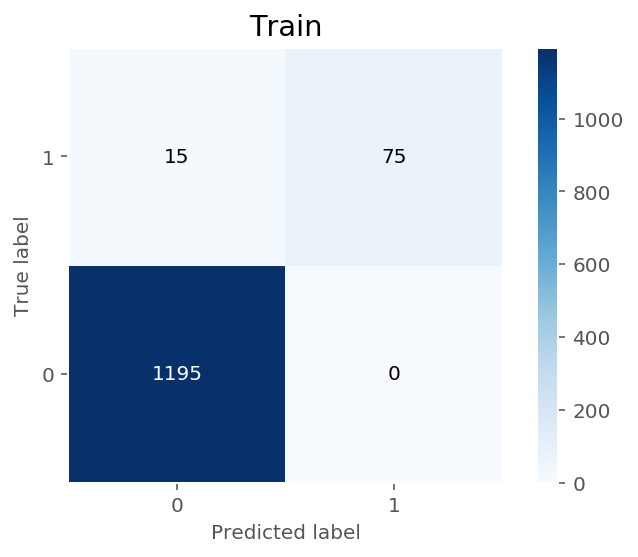

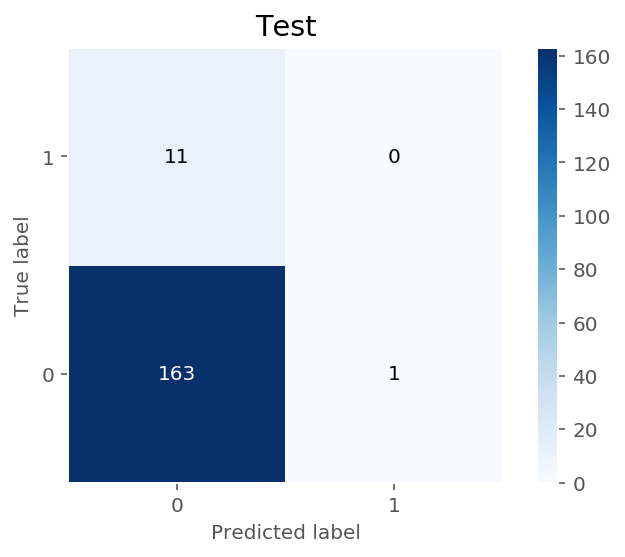

In [624]:
skplt.metrics.plot_confusion_matrix(ab_y_train, forest_train_pred)
plt.ylim([-0.5, len(ab_y_test.unique())-0.5])
plt.title('Train')
plt.show()
skplt.metrics.plot_confusion_matrix(ab_y_test, forest_test_pred)
plt.ylim([-0.5, len(ab_y_test.unique())-0.5])
plt.title('Test')
plt.show()

Overfit on training set, so not much use either. Another approach is to use a penalize algorithm, so let's try that out.

In [626]:
from sklearn.svm import SVC
clf_3 = SVC(kernel='linear', 
            class_weight='balanced', # penalize
            probability=True).fit(train,ab_y_train)

In [630]:
print('Baseline Accuracy: ' + str(baseline.max()))
print('Train Accuracy: ' + str(clf_3.score(train,ab_y_train)))
print('Test Accuracy: ' + str(clf_3.score(test,ab_y_test)))

Baseline Accuracy: 0.9308219178082192
Train Accuracy: 0.5595330739299611
Test Accuracy: 0.5371428571428571


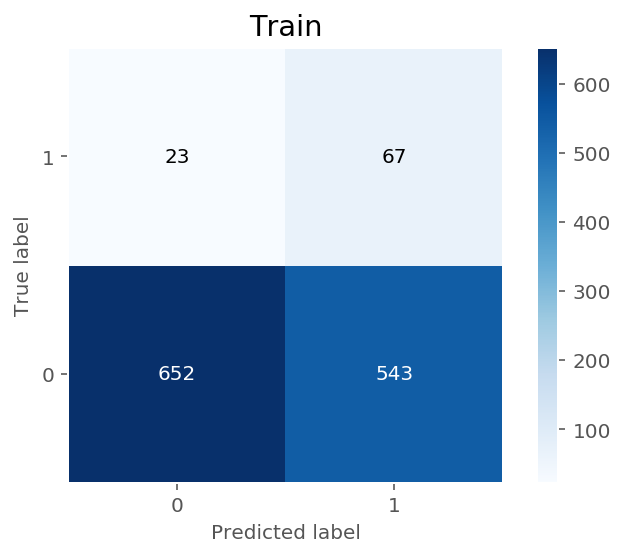

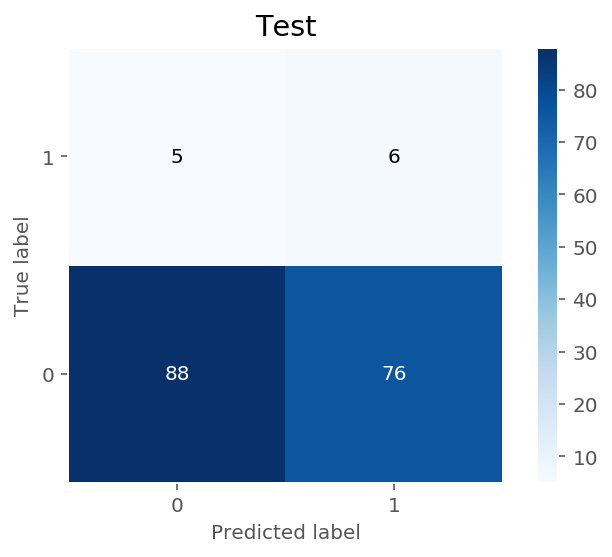

In [634]:
predict_train=clf_3.predict(train)
predict_test=clf_3.predict(test)
skplt.metrics.plot_confusion_matrix(ab_y_train, predict_train)
plt.ylim([-0.5, len(ab_y_test.unique())-0.5])
plt.title('Train')
plt.show()
skplt.metrics.plot_confusion_matrix(ab_y_test, predict_test)
plt.ylim([-0.5, len(ab_y_test.unique())-0.5])
plt.title('Test')
plt.show()

In [636]:
print('Train')
print(classification_report(ab_y_train,predict_train))
print('Test')
print(classification_report(ab_y_test,predict_test))

Train
              precision    recall  f1-score   support

           0       0.97      0.55      0.70      1195
           1       0.11      0.74      0.19        90

    accuracy                           0.56      1285
   macro avg       0.54      0.65      0.44      1285
weighted avg       0.91      0.56      0.66      1285

Test
              precision    recall  f1-score   support

           0       0.95      0.54      0.68       164
           1       0.07      0.55      0.13        11

    accuracy                           0.54       175
   macro avg       0.51      0.54      0.41       175
weighted avg       0.89      0.54      0.65       175



Unfortunately this model isn't as good either, with a weaker recall score than the upsampling one.

Therefore, the best model I could come up with for predicting an abnormal sale was an upsampled model using a threshold of 0.48.

We could also check the AUROC scores for the models to see which has the greatest probability of ranking an observation correctly

In [640]:
from sklearn.metrics import roc_auc_score
prob_y_4 = clf_4.predict_proba(test)
prob_y_4 = [p[1] for p in prob_y_4]

In [644]:
prob_y_lr = best_lr.predict_proba(test)
prob_y_lr = [p[1] for p in prob_y_lr]
prob_y_up = upsampled_lr.predict_proba(test)
prob_y_up = [p[1] for p in prob_y_up]
prob_y_dn = downsampled_lr.predict_proba(test)
prob_y_dn = [p[1] for p in prob_y_dn]
prob_y_4 = clf_4.predict_proba(test)
prob_y_4 = [p[1] for p in prob_y_4]
prob_y_3 = clf_3.predict_proba(test)
prob_y_3 = [p[1] for p in prob_y_3]
prob_y_knn = best_knn.predict_proba(test)
prob_y_knn = [p[1] for p in prob_y_knn]

In [645]:
print('Base Logistic Regression AUROC: ' + str(roc_auc_score(ab_y_test, prob_y_lr)))
print('KNN AUROC: ' + str(roc_auc_score(ab_y_test,  prob_y_knn)))
print('Upsample AUROC: ' + str(roc_auc_score(ab_y_test,  prob_y_up)))
print('Downsample AUROC: ' + str(roc_auc_score(ab_y_test,  prob_y_dn)))
print('Random Forest AUROC: ' + str(roc_auc_score(ab_y_test,  prob_y_4)))
print('Penalizer AUROC: ' + str(roc_auc_score(ab_y_test,  prob_y_3)))

Base Logistic Regression AUROC: 0.5
Upsample AUROC: 0.6696230598669624
Downsample AUROC: 0.6696230598669624
Random Forest AUROC: 0.6335920177383593
Penalizer AUROC: 0.6468957871396896


Again, the upsampled model produces the best results. Using the upsampled model, I will now calculate the most influential features from that model

In [719]:
coeffs3=pd.DataFrame(list(zip(test.columns,upsampled_lr.coef_[0])),columns=['feature','coef'])
coeffs3['abs_effect']=np.abs(coeffs3.coef)

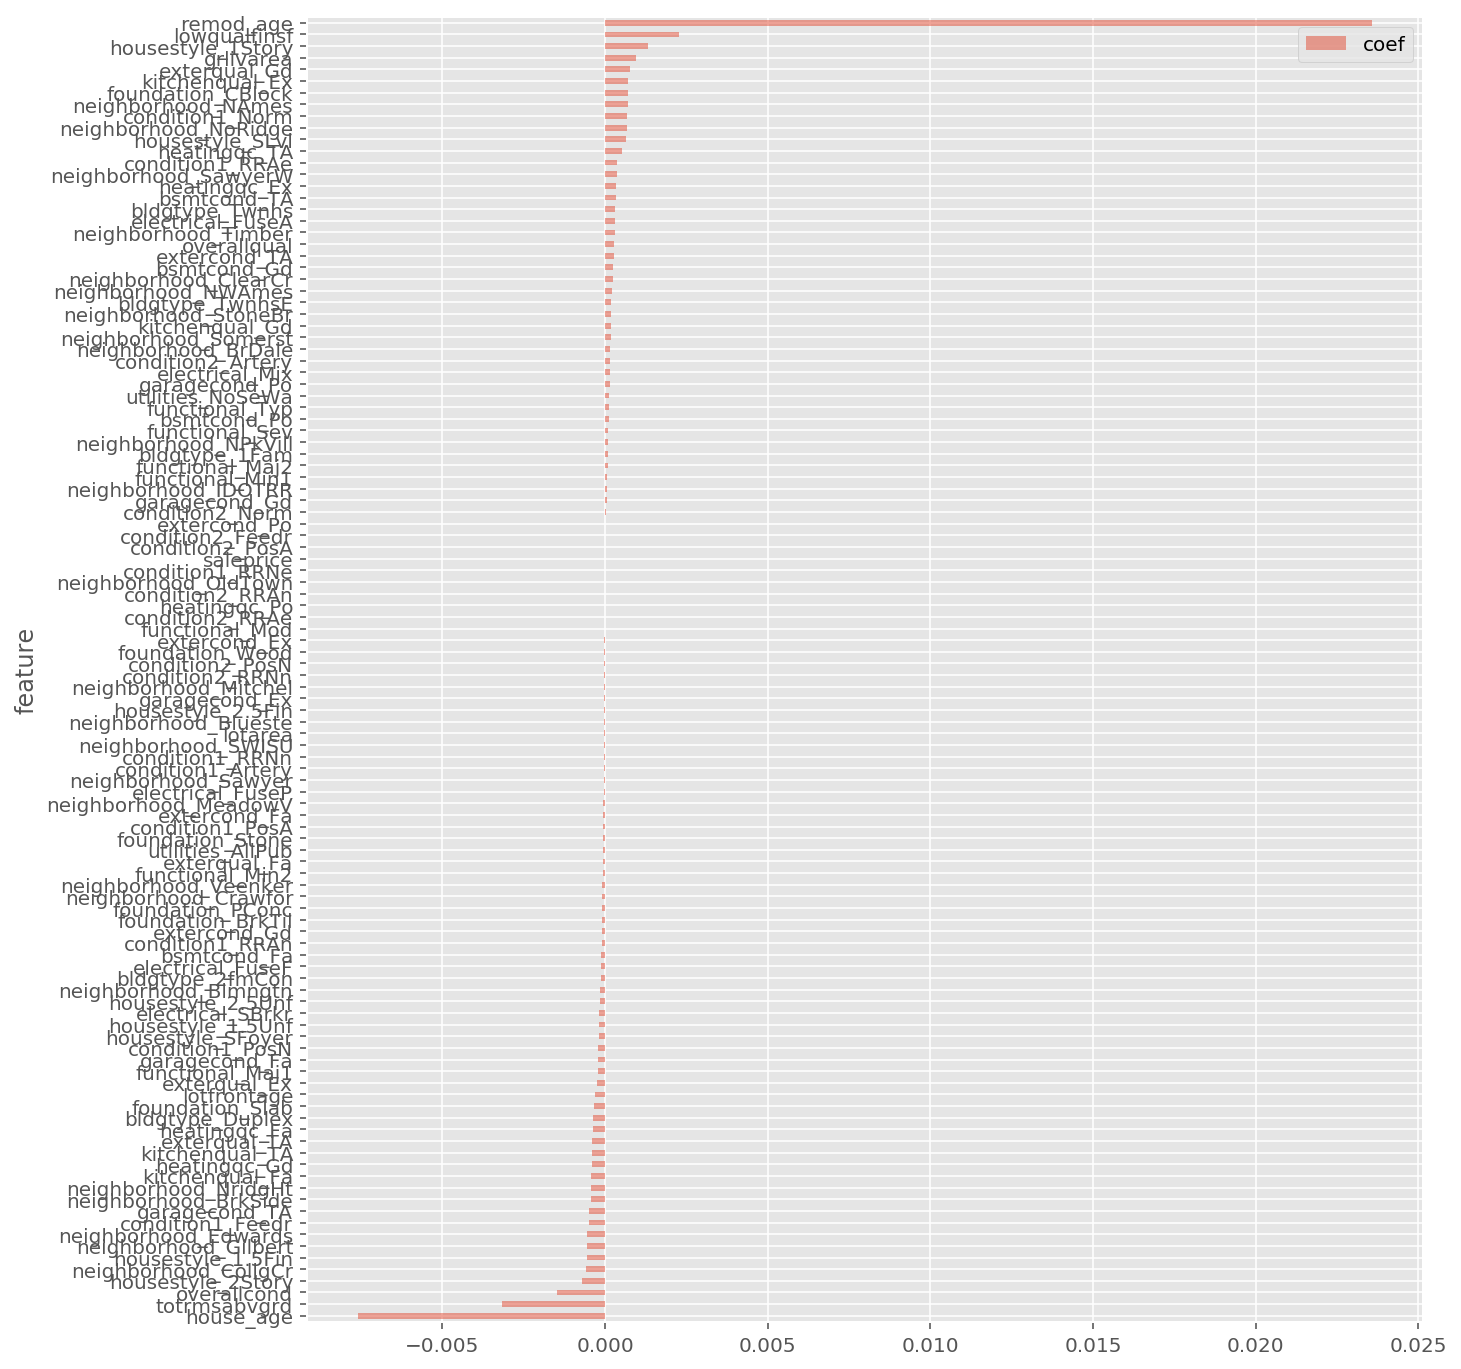

In [720]:
fig, ax =plt.subplots(figsize=(10,12))
coeffs3.sort_values(by='coef').plot(kind='barh',x='feature',y='coef',ax=ax,alpha=0.5);

In [721]:
coeffs3.sort_values(by='abs_effect',ascending=False)[0:20]

feature      coef  abs_effect
8              remod_age  0.023588    0.023588
7              house_age -0.007601    0.007601
6           totrmsabvgrd -0.003161    0.003161
4           lowqualfinsf  0.002283    0.002283
3            overallcond -0.001475    0.001475
61     housestyle_1Story  0.001305    0.001305
5              grlivarea  0.000958    0.000958
69          exterqual_Gd  0.000779    0.000779
64     housestyle_2Story -0.000708    0.000708
96        kitchenqual_Ex  0.000707    0.000707
77     foundation_CBlock  0.000698    0.000698
24    neighborhood_NAmes  0.000696    0.000696
39       condition1_Norm  0.000683    0.000683
27  neighborhood_NoRidge  0.000676    0.000676
66       housestyle_SLvl  0.000635    0.000635
17  neighborhood_CollgCr -0.000581    0.000581
59     housestyle_1.5Fin -0.000570    0.000570
20  neighborhood_Gilbert -0.000569    0.000569
19  neighborhood_Edwards -0.000552    0.000552
90          heatingqc_TA  0.000531    0.000531

It appears that the age of the house and how long ago it was remodelled have the greatest effect on the odds of a property being correctly identified.